In [1]:
import cv2
import mediapipe as mp
import numpy as np
import os
import datetime
import time 
from keras.models import load_model
from keras.layers import Input, Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten
from keras.models import Model
#%matplotlib inline 
import matplotlib.pyplot as plt
import copy
from keras.utils.vis_utils import plot_model
    
def DrawText(img,sText,x,y):
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    posf = (x,y)
    fontScale              = 5
    fontColor              = (255,255,255)
    thickness              = 1
    lineType               = 2
    print("Masuk")
    cv2.putText(img,sText, 
        posf, 
        font, 
        fontScale,
        fontColor,
        thickness,
        lineType)
    return copy.deepcopy(img)
    

def LoadCitraTraining(sDir,LabelKelas):
  
  JumlahKelas=len(LabelKelas)
  TargetKelas = np.eye(JumlahKelas)
  
  # Menyiapkan variabel list untuk data menampung citra dan data target
  X=[]#Menampung Data Citra
  T=[]#Menampung Target
  for i in range(len(LabelKelas)):    
    #Membaca file citra di setiap direktori data set  
    DirKelas = os.path.join(sDir, LabelKelas[i])
    files = os.listdir(DirKelas)
    
    for f in files:
      ff=f.lower()  
      print(f)
      #memilih citra dengan extensi jpg,jpeg,dan png
      if (ff.endswith('.jpg')|ff.endswith('.jpeg')|ff.endswith('.png')):
         NmFile = os.path.join(DirKelas,f)
         #membaca citra berwarna sebagai data bertipe double 
         img= np.double(cv2.imread(NmFile,1))
         img=cv2.resize(img,(128,128));
         #Normalisasi data citra menjadi sehingga maksimum menjadi 1
         img= np.asarray(img)/255;
         img=img.astype('float32')
         #Menambahkan citra dan target ke daftar
         X.append(img)
         T.append(TargetKelas[i])
     #--------akhir loop :Pfor f in files-----------------
  #-----akhir  loop :for i in range(len(LabelKelas))----
  
  #Mengubah List Menjadi numppy array
  X=np.array(X)
  T=np.array(T)
  X=X.astype('float32')
  T=T.astype('float32')
  return X,T

def ModelDeepLearningCNN(JumlahKelas):
    input_img = Input(shape=(128, 128, 3)) 
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)  
    x = MaxPooling2D((2, 2), padding='same')(x)   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)   
    x = MaxPooling2D((2, 2), padding='same')(x)   
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(100,activation='relu')(x)
    x = Dense(100,activation='relu')(x)
    x=Dense(JumlahKelas,activation='softmax')(x)
    ModelCNN = Model(input_img, x)  
    ModelCNN.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #ModelCNN.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    #plot_model(ModelCNN, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    return ModelCNN


def TrainingCNN(JumlahEpoh,DirektoriDataSet,LabelKelas,NamaFileBobot ='weight.h5' ):
    #Membaca Data training dan label Kelas 
    X,D=LoadCitraTraining(DirektoriDataSet,LabelKelas)
    JumlahKelas = len(LabelKelas)
    #Membuat Model CNN
    ModelCNN =ModelDeepLearningCNN(JumlahKelas)
    #Trainng
    history=ModelCNN.fit(X, D,epochs=JumlahEpoh,shuffle=True)
    #Menyimpan hasil learning
    ModelCNN.save(NamaFileBobot)
    #Mengembalikan output 
    return ModelCNN,history



##########################################################
def Klasifikasi(Image,ModelCNN):

  X=[]
  ls = [];

  img= copy.deepcopy(Image)
  img=cv2.resize(img,(128,128))
  img= np.asarray(img)/255
  img=img.astype('float32')
  X.append(img)  
  X=np.array(X)
  X=X.astype('float32')
  hs=ModelCNN.predict(X,verbose=0)

  if hs.max()>0.5:
      idx = np.max(np.where( hs == hs.max()))
  else:
    idx=-1
      
 
  return idx
def GetFileName():
        x = datetime.datetime.now()
        s = x.strftime('%Y-%m-%d-%H%M%S%f')
        return s
def CreateDir(path):
    ls = [];
    head_tail = os.path.split(path)
    ls.append(path)
    while len(head_tail[1])>0:
        head_tail = os.path.split(path)
        path = head_tail[0]
        ls.append(path)
        head_tail = os.path.split(path)   
    for i in range(len(ls)-2,-1,-1):
        sf =ls[i]
        isExist = os.path.exists(sf)
        if not isExist:
            os.makedirs(sf)
NamaDataSet = "TanganSamping"



def CreateDataSet(NoKamera,NamaDataSet):
    DirektoriData = "c:\\temp\\dataimage"+"\\"+NamaDataSet+"\\"+GetFileName()    
    CreateDir(DirektoriData)        
    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    imsize=(640, 480)
    height = imsize[1]
    width = imsize[0]
    TimeStart = time.time() 
    TimeNow = time.time() +10
    FrameRate = 5
    # For webcam input:
    cap = cv2.VideoCapture(NoKamera,cv2.CAP_DSHOW)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:
      
      while cap.isOpened():
        success, image = cap.read()
        if not success:
          print("Ignoring empty camera frame.")
          # If loading a video, use 'break' instead of 'continue'.
          continue
    
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        ori = copy.deepcopy(image)
       
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, imsize)
     
       
        results = pose.process(image)
        if not results.pose_landmarks:
         continue
        lm = []
        
    
        for lmark in results.pose_landmarks.landmark:
            print(lmark)
            if (lmark.x>0.01)and(lmark.x<1-0.01)and(lmark.y>0.01)and(lmark.y<1-0.01):
                m = [lmark.x*width  , lmark.y*height]
                lm.append(m)
        if len(lm) ==0:
            continue
        lm = np.array(lm)
        x = lm[:,0]
        y = lm[:,1]
        ymin = np.min(y)
        ymax = np.max(y)
        xmin =np.min(x)
        xmax =np.max(x)
            
                
            
        ymin = np.int32(np.min(y))-3
        ymax = np.int32(np.max(y))-3
        xmin = np.int32(np.min(x))+3
        xmax = np.int32(np.max(x))+3
    
        
        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        bimage = np.zeros((height,width,3), np.uint8)
        cv2.rectangle(bimage,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
        
        mp_drawing.draw_landmarks(
            bimage,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
 
        image = cv2.rectangle(image, (xmin,ymin),(xmax,ymax), (255,0,0),2)
                          
        cropped_image = bimage[ymin:ymax, xmin:xmax,:]
        dy =ymax -ymin
        dx = xmax -xmin
        print(dy,dx)
        print(cropped_image.shape)
        TimeNow = time.time() 
        if TimeNow-TimeStart>1/FrameRate:
            print(cropped_image.shape)
            TimeStart = TimeNow
            sFile = DirektoriData+"\\"+GetFileName()
            imsize2=(128,128)
            cropped_image = cv2.resize(cropped_image, imsize2)
            cv2.imwrite(sFile+'.jpg', cropped_image)
            cv2.imwrite(sFile+'.png', image)
            #cv2.imwrite(sFile+'.bmp', ori)
            
            
    
        cv2.imshow('MediaPipe Pose', cv2.flip(image, 1))
        if cv2.waitKey(5) & 0xFF == 27:
          break
    cap.release()
    cv2.destroyAllWindows()
    
def TesPosePrediction(DirDataSet,DirKlasifikasi,LabelKelas,ModelCNN=[]):
#Apabila parameter input ModelCNN tidak di isi maka
#   akan menggunakan bobot pada file 'weight.h5
  if not(ModelCNN):
      ModelCNN = load_model('weight.h5') 
      
#Menyiapkan Data input Yang akan di kasifikasikan
  X=[]
  ls = [];
  DirKelas = DirDataSet+"\\"+DirKlasifikasi
  print(DirKelas)
  files = os.listdir(DirKelas)
  n=0;
  for f in files:
      ff=f.lower()  
      print(f)
      if (ff.endswith('.jpg')|ff.endswith('.jpeg')|ff.endswith('.png')):
         ls.append(ff) 
         NmFile = os.path.join(DirKelas,f)
         img= cv2.imread(NmFile,1)
         img=cv2.resize(img,(128,128))
         img= np.asarray(img)/255
         img=img.astype('float32')
         X.append(img)
     #----Akhir if-------------
  #---Akhir For 
  X=np.array(X)
  X=X.astype('float32')
  #Melakukan prediksi Klasifikasi
  hs=ModelCNN.predict(X)
  
  LKlasifikasi=[];
  LKelasCitra =[];
  n = X.shape[0]
  for i in range(n):
      v=hs[i,:]
      if v.max()>0.5:
          idx = np.max(np.where( v == v.max()))
          LKelasCitra.append(LabelKelas[idx])
      else:
          idx=-1
          LKelasCitra.append("-")
      #------akhir if
      LKlasifikasi.append(idx);
  #----akhir for
  LKlasifikasi = np.array(LKlasifikasi)
  return ls, hs, LKelasCitra

def PredictPose(NoKamera,LabelKelas):
    ModelCNN = load_model('weight.h5') 
    

    mp_drawing = mp.solutions.drawing_utils
    mp_drawing_styles = mp.solutions.drawing_styles
    mp_pose = mp.solutions.pose
    imsize=(640, 480)
    height = imsize[1]
    width = imsize[0]

    # For webcam input:
    cap = cv2.VideoCapture(NoKamera,cv2.CAP_DSHOW)
    with mp_pose.Pose(
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5) as pose:
      
      while cap.isOpened():
        success, image = cap.read()
        if not success:
          print("Ignoring empty camera frame.")
          # If loading a video, use 'break' instead of 'continue'.
          continue
    
        # To improve performance, optionally mark the image as not writeable to
        # pass by reference.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, imsize)
     
        results = pose.process(image)
        if not results.pose_landmarks:
         continue
        lm = []
        
    
        for lmark in results.pose_landmarks.landmark:
            
            if (lmark.x>0.01)and(lmark.x<1-0.01)and(lmark.y>0.01)and(lmark.y<1-0.01):
                m = [lmark.x*width  , lmark.y*height]
                lm.append(m)
        if len(lm) ==0:
            continue
        lm = np.array(lm)
        x = lm[:,0]
        y = lm[:,1]
        ymin = np.min(y)
        ymax = np.max(y)
        xmin =np.min(x)
        xmax =np.max(x)
            
                
            
        ymin = np.int32(np.min(y))-3
        ymax = np.int32(np.max(y))-3
        xmin = np.int32(np.min(x))+3
        xmax = np.int32(np.max(x))+3
    
        
        # Draw the pose annotation on the image.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        bimage = np.zeros((height,width,3), np.uint8)
        cv2.rectangle(bimage,(xmin,ymin),(xmax,ymax),(0,255,0),2)
    
        mp_drawing.draw_landmarks(
            image,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        
        
        mp_drawing.draw_landmarks(
            bimage,
            results.pose_landmarks,
            mp_pose.POSE_CONNECTIONS,
            landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style())
        cropped_image = bimage[ymin:ymax, xmin:xmax,:]
        idx = Klasifikasi(cropped_image, ModelCNN)
        x=60
        y=60
        image= cv2.flip(image, 1)
    
        if idx>=0:
            cv2.putText(image,LabelKelas[idx], (x,y), cv2.FONT_HERSHEY_SIMPLEX,2.0, (255, 255, 0), 3)
        

        cv2.imshow('MediaPipe Pose', image)
                
       
        if cv2.waitKey(5) & 0xFF == 27:
          break
    cap.release()
    cv2.destroyAllWindows()

In [3]:
LabelKelas=['TAtas','TSamping']

PredictPose(1,LabelKelas)
    

In [3]:
CreateDataSet(0,"S")

x: 0.47469467
y: 0.5302414
z: -0.2653887
visibility: 0.99945503

x: 0.47788453
y: 0.51770246
z: -0.25033358
visibility: 0.9988262

x: 0.48042598
y: 0.51818895
z: -0.2504594
visibility: 0.9988738

x: 0.48301443
y: 0.5189902
z: -0.2505664
visibility: 0.9988662

x: 0.46865088
y: 0.51690876
z: -0.2533863
visibility: 0.99858236

x: 0.46490765
y: 0.5169188
z: -0.253408
visibility: 0.99848926

x: 0.46108562
y: 0.5172529
z: -0.253521
visibility: 0.99838257

x: 0.48470506
y: 0.5257771
z: -0.13976333
visibility: 0.9984908

x: 0.45333228
y: 0.52370304
z: -0.15509784
visibility: 0.9983752

x: 0.47962084
y: 0.54316956
z: -0.22184446
visibility: 0.9996779

x: 0.46777973
y: 0.54313713
z: -0.22608991
visibility: 0.9996106

x: 0.51474863
y: 0.6032115
z: -0.061614364
visibility: 0.9997863

x: 0.42136416
y: 0.60678506
z: -0.08792397
visibility: 0.9995183

x: 0.5241747
y: 0.7064288
z: -0.010690959
visibility: 0.95638275

x: 0.40719408
y: 0.70925117
z: -0.056188058
visibility: 0.95240295

x: 0.5181123
y: 0

207 80
(207, 80, 3)
(207, 80, 3)
x: 0.4680977
y: 0.52581984
z: -0.26156124
visibility: 0.9995164

x: 0.47192353
y: 0.51465005
z: -0.2465032
visibility: 0.99896836

x: 0.47434473
y: 0.5149177
z: -0.2466003
visibility: 0.9990046

x: 0.4766055
y: 0.5153226
z: -0.24668911
visibility: 0.9989947

x: 0.46427375
y: 0.51458114
z: -0.24750748
visibility: 0.99879634

x: 0.4614675
y: 0.5148521
z: -0.2475328
visibility: 0.9987294

x: 0.45866722
y: 0.5153123
z: -0.24760866
visibility: 0.9986575

x: 0.4791944
y: 0.5226225
z: -0.14105755
visibility: 0.9986269

x: 0.4517227
y: 0.5226438
z: -0.14787516
visibility: 0.9986368

x: 0.4732418
y: 0.53929245
z: -0.22146747
visibility: 0.9996942

x: 0.46174735
y: 0.5391348
z: -0.2229938
visibility: 0.9996527

x: 0.50776356
y: 0.6029982
z: -0.06094302
visibility: 0.9997343

x: 0.42062727
y: 0.60561216
z: -0.09588303
visibility: 0.9995633

x: 0.5193219
y: 0.7060653
z: -0.01652379
visibility: 0.95034224

x: 0.40453243
y: 0.7094638
z: -0.07880894
visibility: 0.9557

x: 0.4486169
y: 0.5251378
z: -0.2500408
visibility: 0.9995768

x: 0.4529844
y: 0.51482266
z: -0.23538008
visibility: 0.9990784

x: 0.45572203
y: 0.51499695
z: -0.23548153
visibility: 0.9991163

x: 0.45876712
y: 0.51534307
z: -0.23556212
visibility: 0.9991045

x: 0.44593993
y: 0.51495636
z: -0.23561516
visibility: 0.9989565

x: 0.44376245
y: 0.5152292
z: -0.23562863
visibility: 0.9989026

x: 0.44170603
y: 0.51557314
z: -0.23571765
visibility: 0.99884075

x: 0.46426597
y: 0.5230215
z: -0.1420825
visibility: 0.9987297

x: 0.4385352
y: 0.5224966
z: -0.1384109
visibility: 0.99876034

x: 0.45317322
y: 0.53855395
z: -0.21283133
visibility: 0.99971765

x: 0.44381818
y: 0.5378587
z: -0.21277682
visibility: 0.9996857

x: 0.49904078
y: 0.60366505
z: -0.08471772
visibility: 0.9997211

x: 0.40662676
y: 0.60581535
z: -0.08377934
visibility: 0.99961007

x: 0.50676525
y: 0.70683706
z: -0.041831344
visibility: 0.9532433

x: 0.39215615
y: 0.7096217
z: -0.055895526
visibility: 0.9524626

x: 0.50296617
y:

x: 0.4357254
y: 0.5247972
z: -0.26260883
visibility: 0.99967533

x: 0.44029817
y: 0.5141216
z: -0.24880567
visibility: 0.99926585

x: 0.44334927
y: 0.51419026
z: -0.24888
visibility: 0.99930483

x: 0.44661784
y: 0.51443166
z: -0.24894261
visibility: 0.9992912

x: 0.4325846
y: 0.5145068
z: -0.24662355
visibility: 0.999175

x: 0.4304397
y: 0.51482826
z: -0.24665277
visibility: 0.9991421

x: 0.4282515
y: 0.5151952
z: -0.24673024
visibility: 0.9990901

x: 0.45215377
y: 0.5220191
z: -0.15537204
visibility: 0.99898785

x: 0.42489347
y: 0.5220926
z: -0.14784978
visibility: 0.99896073

x: 0.44147372
y: 0.53778785
z: -0.22785752
visibility: 0.9997791

x: 0.43147105
y: 0.53737456
z: -0.22504167
visibility: 0.99974793

x: 0.48708272
y: 0.60349303
z: -0.09514922
visibility: 0.99975294

x: 0.3936978
y: 0.6086605
z: -0.09018325
visibility: 0.9996629

x: 0.49688873
y: 0.7068298
z: -0.047953792
visibility: 0.9623898

x: 0.38319993
y: 0.7127163
z: -0.055715866
visibility: 0.95071256

x: 0.49702454
y: 0

x: 0.434692
y: 0.5283839
z: -0.2770676
visibility: 0.99970573

x: 0.4388655
y: 0.5173202
z: -0.2618593
visibility: 0.9993129

x: 0.44162053
y: 0.5173208
z: -0.26194596
visibility: 0.9993596

x: 0.4444445
y: 0.5175372
z: -0.26200074
visibility: 0.99934745

x: 0.43132362
y: 0.51784486
z: -0.26239935
visibility: 0.9992108

x: 0.4287363
y: 0.5181903
z: -0.26244718
visibility: 0.9991775

x: 0.42595372
y: 0.51863086
z: -0.2625516
visibility: 0.9991086

x: 0.4478313
y: 0.5238925
z: -0.15538242
visibility: 0.9990526

x: 0.4210844
y: 0.5249199
z: -0.16356467
visibility: 0.99891365

x: 0.4406272
y: 0.5412268
z: -0.2379709
visibility: 0.9997971

x: 0.42940754
y: 0.5411565
z: -0.23897395
visibility: 0.99975204

x: 0.48172498
y: 0.6033803
z: -0.08727885
visibility: 0.9997876

x: 0.3900349
y: 0.60928786
z: -0.099762835
visibility: 0.9996436

x: 0.49533176
y: 0.7057529
z: -0.04074812
visibility: 0.9670439

x: 0.37935406
y: 0.7145531
z: -0.067345075
visibility: 0.94390726

x: 0.49757347
y: 0.79998195


x: 0.43472433
y: 0.5307726
z: -0.28450316
visibility: 0.99979097

x: 0.43969268
y: 0.5191066
z: -0.27058166
visibility: 0.99949485

x: 0.44247198
y: 0.5190026
z: -0.27063146
visibility: 0.9995332

x: 0.44518542
y: 0.51911396
z: -0.2706614
visibility: 0.9995112

x: 0.4304499
y: 0.5197843
z: -0.27234778
visibility: 0.99942315

x: 0.42727345
y: 0.5201735
z: -0.27236804
visibility: 0.9994074

x: 0.42423
y: 0.52067465
z: -0.27241445
visibility: 0.9993462

x: 0.44868892
y: 0.5248692
z: -0.16916616
visibility: 0.999292

x: 0.41857472
y: 0.52711284
z: -0.17887387
visibility: 0.999218

x: 0.44126862
y: 0.5431235
z: -0.24500188
visibility: 0.999847

x: 0.42840567
y: 0.54385954
z: -0.24754186
visibility: 0.9998168

x: 0.48212105
y: 0.60409385
z: -0.090209946
visibility: 0.99983346

x: 0.38969868
y: 0.6097754
z: -0.11144413
visibility: 0.99971604

x: 0.49571317
y: 0.70456654
z: -0.02897866
visibility: 0.97245383

x: 0.3788586
y: 0.7155608
z: -0.078825116
visibility: 0.954388

x: 0.49678683
y: 0.79

x: 0.4392752
y: 0.5332164
z: -0.30721346
visibility: 0.999821

x: 0.44259858
y: 0.5203349
z: -0.2925564
visibility: 0.99955916

x: 0.4446272
y: 0.52017254
z: -0.29262373
visibility: 0.99959356

x: 0.44698963
y: 0.52024573
z: -0.2926824
visibility: 0.99956584

x: 0.43397465
y: 0.521058
z: -0.29634768
visibility: 0.99949914

x: 0.43047315
y: 0.52146757
z: -0.29638588
visibility: 0.9994929

x: 0.42683563
y: 0.5221177
z: -0.29644078
visibility: 0.99943405

x: 0.4493776
y: 0.52570224
z: -0.18352208
visibility: 0.9993725

x: 0.41891307
y: 0.5290535
z: -0.2028279
visibility: 0.9993454

x: 0.4442616
y: 0.5457451
z: -0.2642708
visibility: 0.9998605

x: 0.43195343
y: 0.54642004
z: -0.26969835
visibility: 0.9998387

x: 0.48227602
y: 0.6039657
z: -0.10350289
visibility: 0.99984723

x: 0.3897119
y: 0.6100443
z: -0.1321163
visibility: 0.99974126

x: 0.49584657
y: 0.7041732
z: -0.034789182
visibility: 0.97426176

x: 0.3795977
y: 0.7179537
z: -0.09940181
visibility: 0.9608013

x: 0.49677974
y: 0.79517

x: 0.44066104
y: 0.53697723
z: -0.31509587
visibility: 0.9998504

x: 0.4433557
y: 0.52259153
z: -0.30196553
visibility: 0.9996308

x: 0.44529718
y: 0.5220503
z: -0.30203718
visibility: 0.9996571

x: 0.44770402
y: 0.5217522
z: -0.3021031
visibility: 0.9996304

x: 0.43494636
y: 0.5242216
z: -0.30554494
visibility: 0.9995827

x: 0.43150386
y: 0.5248363
z: -0.3055787
visibility: 0.99957925

x: 0.42795014
y: 0.52569145
z: -0.30562827
visibility: 0.999527

x: 0.44991556
y: 0.5262575
z: -0.1965088
visibility: 0.99946904

x: 0.41920775
y: 0.5325204
z: -0.21521723
visibility: 0.9994731

x: 0.4454802
y: 0.5486162
z: -0.2730856
visibility: 0.9998802

x: 0.43404832
y: 0.54923695
z: -0.27825212
visibility: 0.99986535

x: 0.48227143
y: 0.60292965
z: -0.11401968
visibility: 0.9998702

x: 0.38957584
y: 0.6110584
z: -0.14439121
visibility: 0.9997609

x: 0.49739367
y: 0.7037744
z: -0.04989154
visibility: 0.9774707

x: 0.38121724
y: 0.7208997
z: -0.11464646
visibility: 0.9665732

x: 0.4981354
y: 0.794862

x: 0.44141617
y: 0.53679293
z: -0.30518928
visibility: 0.9998637

x: 0.44357976
y: 0.522539
z: -0.29141462
visibility: 0.9996641

x: 0.44553056
y: 0.5219934
z: -0.29149276
visibility: 0.9996871

x: 0.4479824
y: 0.521617
z: -0.2915542
visibility: 0.9996608

x: 0.43537503
y: 0.5243612
z: -0.29555532
visibility: 0.9996201

x: 0.4320197
y: 0.5252095
z: -0.29558033
visibility: 0.99961877

x: 0.42864814
y: 0.5263378
z: -0.2956324
visibility: 0.9995676

x: 0.4498373
y: 0.52589697
z: -0.18617998
visibility: 0.9995133

x: 0.4196834
y: 0.53371906
z: -0.20815699
visibility: 0.9995336

x: 0.44619638
y: 0.54870975
z: -0.2636738
visibility: 0.9998879

x: 0.43541035
y: 0.5495558
z: -0.26953942
visibility: 0.9998762

x: 0.48259062
y: 0.6020578
z: -0.10716911
visibility: 0.99988115

x: 0.39042234
y: 0.6113648
z: -0.1390505
visibility: 0.9997578

x: 0.49752465
y: 0.70357215
z: -0.04692106
visibility: 0.9787169

x: 0.38309854
y: 0.7212357
z: -0.112098314
visibility: 0.96958005

x: 0.4985818
y: 0.7944159


x: 0.44253963
y: 0.53582084
z: -0.2938535
visibility: 0.9998893

x: 0.44431195
y: 0.5219156
z: -0.27920336
visibility: 0.99972945

x: 0.4465484
y: 0.5213647
z: -0.27926522
visibility: 0.99974924

x: 0.44926333
y: 0.520922
z: -0.27930802
visibility: 0.9997229

x: 0.43616056
y: 0.5237401
z: -0.28334332
visibility: 0.99969053

x: 0.43255004
y: 0.5246348
z: -0.28336236
visibility: 0.999693

x: 0.42885152
y: 0.52582794
z: -0.2834131
visibility: 0.99964243

x: 0.45092982
y: 0.5253262
z: -0.17254981
visibility: 0.99961

x: 0.41960827
y: 0.5329857
z: -0.19359678
visibility: 0.9996416

x: 0.44730288
y: 0.54781055
z: -0.2522252
visibility: 0.9999106

x: 0.4361435
y: 0.5490257
z: -0.25796303
visibility: 0.9999025

x: 0.4840831
y: 0.6018793
z: -0.09029361
visibility: 0.99990714

x: 0.39099082
y: 0.6121667
z: -0.13075899
visibility: 0.99978226

x: 0.4991235
y: 0.7025815
z: -0.02839475
visibility: 0.9823545

x: 0.3831547
y: 0.7210981
z: -0.101732634
visibility: 0.97625124

x: 0.49996883
y: 0.7948865

x: 0.44191185
y: 0.5339607
z: -0.28301048
visibility: 0.99989706

x: 0.4442266
y: 0.52096105
z: -0.26855335
visibility: 0.99974996

x: 0.44647282
y: 0.5205643
z: -0.26861542
visibility: 0.99976975

x: 0.4491934
y: 0.52025515
z: -0.2686541
visibility: 0.9997447

x: 0.4358159
y: 0.52239627
z: -0.27173615
visibility: 0.99971056

x: 0.4322347
y: 0.5231219
z: -0.27175206
visibility: 0.99971294

x: 0.4284276
y: 0.52414805
z: -0.27180454
visibility: 0.99966127

x: 0.45114875
y: 0.5251022
z: -0.1654417
visibility: 0.99964654

x: 0.41972774
y: 0.53138626
z: -0.1819685
visibility: 0.99966604

x: 0.44696134
y: 0.54611593
z: -0.24309818
visibility: 0.99991864

x: 0.43525773
y: 0.54747605
z: -0.24757652
visibility: 0.99990964

x: 0.4846937
y: 0.6018951
z: -0.08862825
visibility: 0.99991477

x: 0.391555
y: 0.6123314
z: -0.11998713
visibility: 0.9997836

x: 0.49925628
y: 0.70240283
z: -0.029132674
visibility: 0.983852

x: 0.3834348
y: 0.7205797
z: -0.090187475
visibility: 0.9769042

x: 0.5002269
y: 0

x: 0.4371983
y: 0.53325284
z: -0.28642267
visibility: 0.99990237

x: 0.44197068
y: 0.5210708
z: -0.27199027
visibility: 0.9997616

x: 0.44474363
y: 0.5207623
z: -0.2720615
visibility: 0.9997792

x: 0.4474129
y: 0.5206062
z: -0.2721061
visibility: 0.99975526

x: 0.4320708
y: 0.522259
z: -0.27596948
visibility: 0.9997255

x: 0.42843223
y: 0.52281964
z: -0.27598578
visibility: 0.9997276

x: 0.42520165
y: 0.52356166
z: -0.27603406
visibility: 0.99967915

x: 0.4509266
y: 0.5259123
z: -0.17225157
visibility: 0.9996585

x: 0.41922322
y: 0.5301623
z: -0.18489641
visibility: 0.999678

x: 0.44427234
y: 0.5453538
z: -0.24816029
visibility: 0.9999227

x: 0.43075386
y: 0.5464341
z: -0.25005463
visibility: 0.99991447

x: 0.4847199
y: 0.6019199
z: -0.09884062
visibility: 0.9999141

x: 0.39143485
y: 0.6123775
z: -0.12074222
visibility: 0.9997912

x: 0.4995142
y: 0.70236033
z: -0.04003241
visibility: 0.98496854

x: 0.38286403
y: 0.72051394
z: -0.08937831
visibility: 0.9773791

x: 0.50024223
y: 0.795084

201 78
(201, 78, 3)
(201, 78, 3)
x: 0.43608838
y: 0.53205043
z: -0.2910563
visibility: 0.9999092

x: 0.44098932
y: 0.5204574
z: -0.2767096
visibility: 0.99977463

x: 0.4439159
y: 0.5202548
z: -0.27675992
visibility: 0.99979043

x: 0.4465599
y: 0.52019054
z: -0.2767916
visibility: 0.9997676

x: 0.43083653
y: 0.5216412
z: -0.27887428
visibility: 0.9997455

x: 0.42724147
y: 0.5222272
z: -0.27890086
visibility: 0.99974835

x: 0.4241325
y: 0.522956
z: -0.27894816
visibility: 0.99970484

x: 0.45034403
y: 0.5260042
z: -0.17515656
visibility: 0.9996743

x: 0.41837686
y: 0.5295912
z: -0.18734641
visibility: 0.99969953

x: 0.44338936
y: 0.54427826
z: -0.25207284
visibility: 0.99992704

x: 0.42961773
y: 0.54524666
z: -0.25522345
visibility: 0.99991995

x: 0.484515
y: 0.60194653
z: -0.101419784
visibility: 0.9999111

x: 0.39039403
y: 0.61255455
z: -0.123895064
visibility: 0.9998033

x: 0.4994606
y: 0.702439
z: -0.03998698
visibility: 0.98572105

x: 0.38131005
y: 0.7208768
z: -0.09337777
visibility

201 79
(201, 79, 3)
x: 0.43757576
y: 0.53396034
z: -0.3046675
visibility: 0.9999136

x: 0.44125575
y: 0.5210898
z: -0.29121414
visibility: 0.9997863

x: 0.44397807
y: 0.52078724
z: -0.29126972
visibility: 0.9998004

x: 0.4466042
y: 0.5206625
z: -0.29130903
visibility: 0.99977857

x: 0.43156776
y: 0.5225998
z: -0.2936448
visibility: 0.9997609

x: 0.4279584
y: 0.5234183
z: -0.29367548
visibility: 0.99976313

x: 0.424581
y: 0.5244255
z: -0.29372486
visibility: 0.999723

x: 0.45010203
y: 0.5261324
z: -0.18844645
visibility: 0.99969405

x: 0.41830277
y: 0.5313448
z: -0.20241287
visibility: 0.99972284

x: 0.44392768
y: 0.54638964
z: -0.26473466
visibility: 0.99993044

x: 0.43103576
y: 0.5473639
z: -0.26827693
visibility: 0.99992454

x: 0.48445368
y: 0.601591
z: -0.10773575
visibility: 0.999914

x: 0.39002043
y: 0.6127702
z: -0.13515738
visibility: 0.99981064

x: 0.4994394
y: 0.7024694
z: -0.043385655
visibility: 0.986014

x: 0.38094485
y: 0.7213699
z: -0.103338934
visibility: 0.9777135

x: 0

201 79
(201, 79, 3)
x: 0.44174832
y: 0.5323374
z: -0.2799962
visibility: 0.9999227

x: 0.4441257
y: 0.5197675
z: -0.26456124
visibility: 0.99980974

x: 0.44680357
y: 0.5196174
z: -0.2646197
visibility: 0.9998226

x: 0.44961953
y: 0.51961297
z: -0.26465085
visibility: 0.99980223

x: 0.4362352
y: 0.52044004
z: -0.26858133
visibility: 0.99978566

x: 0.43270048
y: 0.5210024
z: -0.26859206
visibility: 0.99978894

x: 0.4290042
y: 0.52170247
z: -0.26863307
visibility: 0.99975127

x: 0.45165485
y: 0.52562064
z: -0.15960649
visibility: 0.9997228

x: 0.41997996
y: 0.52901644
z: -0.1805387
visibility: 0.99975514

x: 0.4463164
y: 0.5446859
z: -0.23984742
visibility: 0.99993765

x: 0.43490344
y: 0.545428
z: -0.24549155
visibility: 0.99993306

x: 0.48421374
y: 0.6015329
z: -0.082587734
visibility: 0.99992144

x: 0.39024293
y: 0.61267275
z: -0.11949049
visibility: 0.9998142

x: 0.49930662
y: 0.7023479
z: -0.026159484
visibility: 0.98612136

x: 0.38126227
y: 0.7214615
z: -0.09198766
visibility: 0.9793


x: 0.44656596
y: 0.5443547
z: -0.24996793
visibility: 0.9999469

x: 0.43499485
y: 0.54484653
z: -0.254403
visibility: 0.99994296

x: 0.48605675
y: 0.60252947
z: -0.09509749
visibility: 0.99993

x: 0.39096257
y: 0.61292446
z: -0.12335837
visibility: 0.9998244

x: 0.50090706
y: 0.7027819
z: -0.03895145
visibility: 0.98769087

x: 0.38250566
y: 0.7208233
z: -0.09323044
visibility: 0.9811355

x: 0.5022733
y: 0.79710424
z: -0.13520356
visibility: 0.98317385

x: 0.38229316
y: 0.81507736
z: -0.17648973
visibility: 0.92775947

x: 0.50499934
y: 0.8272899
z: -0.16849497
visibility: 0.9656425

x: 0.38223678
y: 0.84293586
z: -0.20581403
visibility: 0.88270223

x: 0.49816424
y: 0.8262678
z: -0.19799104
visibility: 0.96866894

x: 0.38986585
y: 0.84200776
z: -0.23754987
visibility: 0.8905041

x: 0.49513468
y: 0.8172706
z: -0.14859793
visibility: 0.9647714

x: 0.39153582
y: 0.8340461
z: -0.19049725
visibility: 0.8884532

x: 0.46780333
y: 0.80224836
z: 0.009398109
visibility: 0.9978814

x: 0.4131276
y:

x: 0.4406623
y: 0.5304528
z: -0.27556878
visibility: 0.9999398

x: 0.44497362
y: 0.5191563
z: -0.25938797
visibility: 0.9998547

x: 0.44795856
y: 0.51910806
z: -0.25944054
visibility: 0.9998622

x: 0.45100603
y: 0.51918095
z: -0.25946063
visibility: 0.99984723

x: 0.43576592
y: 0.5192305
z: -0.2614401
visibility: 0.9998365

x: 0.43197685
y: 0.51941717
z: -0.2614526
visibility: 0.99983746

x: 0.42779794
y: 0.5195946
z: -0.26150197
visibility: 0.9998097

x: 0.45382857
y: 0.52525586
z: -0.15432966
visibility: 0.99978137

x: 0.42064992
y: 0.52541995
z: -0.16787925
visibility: 0.99980736

x: 0.44620284
y: 0.54341066
z: -0.23605677
visibility: 0.9999537

x: 0.43314824
y: 0.5435937
z: -0.23920467
visibility: 0.99995106

x: 0.4872509
y: 0.603018
z: -0.086675525
visibility: 0.9999303

x: 0.39162022
y: 0.6132094
z: -0.110566355
visibility: 0.9998299

x: 0.501081
y: 0.70318425
z: -0.03213108
visibility: 0.9885412

x: 0.383154
y: 0.7200948
z: -0.08274587
visibility: 0.9817776

x: 0.5023681
y: 0.79

201 78
(201, 78, 3)
x: 0.44004458
y: 0.530733
z: -0.2746759
visibility: 0.9999472

x: 0.44481444
y: 0.5194537
z: -0.26013005
visibility: 0.99987274

x: 0.4477076
y: 0.51941836
z: -0.26018426
visibility: 0.99987835

x: 0.4507997
y: 0.5195031
z: -0.26020294
visibility: 0.99986523

x: 0.43530646
y: 0.5194031
z: -0.26164135
visibility: 0.999857

x: 0.43150514
y: 0.519535
z: -0.2616556
visibility: 0.999857

x: 0.42734605
y: 0.51967627
z: -0.2617014
visibility: 0.9998337

x: 0.45383078
y: 0.52551764
z: -0.16098456
visibility: 0.99980664

x: 0.42060608
y: 0.5253731
z: -0.1705384
visibility: 0.9998285

x: 0.44584003
y: 0.54361343
z: -0.23692961
visibility: 0.9999598

x: 0.43251842
y: 0.54379636
z: -0.2393163
visibility: 0.9999576

x: 0.4874521
y: 0.6032197
z: -0.0908346
visibility: 0.99993426

x: 0.39167786
y: 0.6128185
z: -0.109753504
visibility: 0.99984163

x: 0.50127643
y: 0.7036064
z: -0.035414144
visibility: 0.98905563

x: 0.38352352
y: 0.7199121
z: -0.08213757
visibility: 0.9820988

x: 0

x: 0.44046965
y: 0.53091216
z: -0.28278264
visibility: 0.99995005

x: 0.44488955
y: 0.5194895
z: -0.2692489
visibility: 0.9998784

x: 0.44770956
y: 0.5194681
z: -0.26929852
visibility: 0.999883

x: 0.4507987
y: 0.519569
z: -0.26932043
visibility: 0.9998704

x: 0.43597007
y: 0.5193698
z: -0.27069137
visibility: 0.99986494

x: 0.43249673
y: 0.5194889
z: -0.2707085
visibility: 0.99986476

x: 0.42878467
y: 0.51964533
z: -0.27075967
visibility: 0.9998443

x: 0.4538847
y: 0.525643
z: -0.17103615
visibility: 0.99981475

x: 0.42140394
y: 0.52554864
z: -0.18035375
visibility: 0.99984026

x: 0.44594288
y: 0.5437305
z: -0.24510777
visibility: 0.9999626

x: 0.43332464
y: 0.5435565
z: -0.2473604
visibility: 0.9999611

x: 0.48774576
y: 0.60315263
z: -0.10089357
visibility: 0.9999368

x: 0.39206997
y: 0.6122331
z: -0.118307434
visibility: 0.9998572

x: 0.5011898
y: 0.7038209
z: -0.04389001
visibility: 0.9891322

x: 0.38342446
y: 0.7192557
z: -0.08952824
visibility: 0.98330384

x: 0.50267583
y: 0.7976

x: 0.4409988
y: 0.530573
z: -0.24710166
visibility: 0.99995536

x: 0.4454193
y: 0.51944506
z: -0.22995415
visibility: 0.99989355

x: 0.44830567
y: 0.5194525
z: -0.23000705
visibility: 0.9998964

x: 0.45130444
y: 0.51961476
z: -0.23000976
visibility: 0.99988604

x: 0.43684644
y: 0.51927453
z: -0.22613665
visibility: 0.9998825

x: 0.43347636
y: 0.5193774
z: -0.22614226
visibility: 0.99988097

x: 0.4298734
y: 0.51952755
z: -0.22623125
visibility: 0.9998636

x: 0.45477524
y: 0.52583706
z: -0.13078022
visibility: 0.99984056

x: 0.42285118
y: 0.5253619
z: -0.14445959
visibility: 0.99986166

x: 0.44631687
y: 0.54327387
z: -0.21106848
visibility: 0.9999683

x: 0.4342007
y: 0.5429509
z: -0.20746526
visibility: 0.99996686

x: 0.48794612
y: 0.6031454
z: -0.08631567
visibility: 0.99994636

x: 0.39328855
y: 0.61136115
z: -0.086904354
visibility: 0.9998671

x: 0.5098399
y: 0.6966383
z: -0.04506412
visibility: 0.99066067

x: 0.37591082
y: 0.71226794
z: -0.054809727
visibility: 0.98454815

x: 0.501386

x: 0.44193015
y: 0.5303905
z: -0.19751458
visibility: 0.99988914

x: 0.4467857
y: 0.51946485
z: -0.18348828
visibility: 0.9997908

x: 0.44986778
y: 0.51951426
z: -0.18354404
visibility: 0.99978

x: 0.45295262
y: 0.5197626
z: -0.18358123
visibility: 0.9997488

x: 0.4377183
y: 0.51929545
z: -0.18292655
visibility: 0.9998132

x: 0.4342649
y: 0.51942503
z: -0.1829621
visibility: 0.9998129

x: 0.43060914
y: 0.51958406
z: -0.18304208
visibility: 0.9998092

x: 0.45706493
y: 0.5261689
z: -0.08552255
visibility: 0.9997253

x: 0.42509764
y: 0.52594227
z: -0.08462397
visibility: 0.9998332

x: 0.44751137
y: 0.54335463
z: -0.1596787
visibility: 0.99992555

x: 0.43512574
y: 0.5429302
z: -0.15939696
visibility: 0.9999451

x: 0.48818102
y: 0.60169095
z: -0.03799852
visibility: 0.9997734

x: 0.39643207
y: 0.607758
z: -0.036892273
visibility: 0.9998397

x: 0.5104247
y: 0.6884986
z: -0.120417915
visibility: 0.9905189

x: 0.36815548
y: 0.69383025
z: -0.13638508
visibility: 0.9857258

x: 0.43939048
y: 0.66

x: 0.44340587
y: 0.5315251
z: -0.1591585
visibility: 0.9978416

x: 0.4479677
y: 0.52007455
z: -0.1457893
visibility: 0.99602234

x: 0.45103636
y: 0.52023244
z: -0.14585426
visibility: 0.99623483

x: 0.4541641
y: 0.52057654
z: -0.14591289
visibility: 0.99574596

x: 0.4387172
y: 0.5196955
z: -0.14603849
visibility: 0.9965336

x: 0.43505716
y: 0.5197245
z: -0.14607269
visibility: 0.99667716

x: 0.4310382
y: 0.51984054
z: -0.14613798
visibility: 0.9965799

x: 0.45800954
y: 0.5265802
z: -0.05731123
visibility: 0.9968335

x: 0.42520514
y: 0.5261678
z: -0.058087964
visibility: 0.99773

x: 0.44855618
y: 0.54481703
z: -0.12427793
visibility: 0.99858344

x: 0.43623775
y: 0.54455537
z: -0.124568045
visibility: 0.9987775

x: 0.4869166
y: 0.598677
z: -0.024282012
visibility: 0.99902636

x: 0.39933932
y: 0.6018465
z: -0.023289284
visibility: 0.9994315

x: 0.4891153
y: 0.67994326
z: -0.10190463
visibility: 0.97963834

x: 0.39338884
y: 0.669341
z: -0.10831107
visibility: 0.9836916

x: 0.41636944
y: 0.

x: 0.44374698
y: 0.5321747
z: -0.14433822
visibility: 0.99503666

x: 0.44795108
y: 0.5203331
z: -0.13139825
visibility: 0.9906703

x: 0.45079288
y: 0.5204735
z: -0.13146265
visibility: 0.9913347

x: 0.45381695
y: 0.52073586
z: -0.1315239
visibility: 0.9907186

x: 0.43871647
y: 0.52042764
z: -0.131093
visibility: 0.9917646

x: 0.43504396
y: 0.52059174
z: -0.13111907
visibility: 0.9920453

x: 0.43095428
y: 0.52104115
z: -0.13118836
visibility: 0.99180955

x: 0.45775643
y: 0.52704513
z: -0.046227846
visibility: 0.9927719

x: 0.42514676
y: 0.52873427
z: -0.04393717
visibility: 0.99426866

x: 0.4492031
y: 0.54539853
z: -0.11064327
visibility: 0.9967617

x: 0.43699962
y: 0.54575044
z: -0.10996904
visibility: 0.9969426

x: 0.48858118
y: 0.5978866
z: -0.021614067
visibility: 0.9985178

x: 0.40103874
y: 0.6021566
z: -0.019721534
visibility: 0.9988915

x: 0.49184957
y: 0.6789573
z: -0.074545935
visibility: 0.96664107

x: 0.39700317
y: 0.67140895
z: -0.08087423
visibility: 0.97588116

x: 0.422606

x: 0.44305807
y: 0.52669007
z: -0.14612798
visibility: 0.99330205

x: 0.44770402
y: 0.51619047
z: -0.1323341
visibility: 0.9862952

x: 0.45048982
y: 0.5162539
z: -0.13241087
visibility: 0.9874222

x: 0.45337433
y: 0.5163802
z: -0.13248405
visibility: 0.98645204

x: 0.43793088
y: 0.51738846
z: -0.13333134
visibility: 0.9880851

x: 0.4340672
y: 0.51815236
z: -0.13336909
visibility: 0.98859274

x: 0.43032917
y: 0.5189893
z: -0.13344759
visibility: 0.9883508

x: 0.4576134
y: 0.5236384
z: -0.050060116
visibility: 0.98901623

x: 0.4251275
y: 0.52760816
z: -0.045862086
visibility: 0.9913161

x: 0.44951445
y: 0.54018295
z: -0.11276462
visibility: 0.9953405

x: 0.43668994
y: 0.54106605
z: -0.11292408
visibility: 0.99552685

x: 0.4907773
y: 0.5973651
z: -0.022665245
visibility: 0.99823725

x: 0.40159947
y: 0.6016846
z: -0.023998441
visibility: 0.9987202

x: 0.4946034
y: 0.678895
z: -0.07276617
visibility: 0.9621834

x: 0.39606053
y: 0.67207676
z: -0.10601737
visibility: 0.9755755

x: 0.42401996



x: 0.42689133
y: 1.0910947
z: 0.062160827
visibility: 0.36039707

199 63
(199, 63, 3)
x: 0.44280463
y: 0.5272097
z: -0.14277804
visibility: 0.9928735

x: 0.44767696
y: 0.5159718
z: -0.12997365
visibility: 0.9850382

x: 0.45042714
y: 0.5160977
z: -0.13002394
visibility: 0.98648477

x: 0.453216
y: 0.5162615
z: -0.13006386
visibility: 0.98533094

x: 0.43744177
y: 0.5172627
z: -0.12884004
visibility: 0.98675144

x: 0.43353447
y: 0.51820475
z: -0.1288782
visibility: 0.9873775

x: 0.43008012
y: 0.5191914
z: -0.12895842
visibility: 0.9869952

x: 0.45754418
y: 0.52316165
z: -0.04663807
visibility: 0.9882625

x: 0.4251017
y: 0.52736706
z: -0.040895995
visibility: 0.9900819

x: 0.44962996
y: 0.5404571
z: -0.11004164
visibility: 0.99496496

x: 0.43645495
y: 0.541669
z: -0.10871388
visibility: 0.9949549

x: 0.49076733
y: 0.59723884
z: -0.019639071
visibility: 0.9983141

x: 0.40172854
y: 0.60165805
z: -0.019252006
visibility: 0.9985981

x: 0.49478602
y: 0.6802251
z: -0.06923798
visibility: 0.96148

x: 0.4422186
y: 0.5280128
z: -0.14123987
visibility: 0.9922379

x: 0.4474542
y: 0.51639664
z: -0.12762518
visibility: 0.9829017

x: 0.4503182
y: 0.51649886
z: -0.12769455
visibility: 0.9848082

x: 0.45297876
y: 0.5166472
z: -0.12775747
visibility: 0.9831483

x: 0.4370307
y: 0.51769453
z: -0.12754534
visibility: 0.9849113

x: 0.43332085
y: 0.5185465
z: -0.12757936
visibility: 0.9857283

x: 0.43014964
y: 0.5194117
z: -0.12765548
visibility: 0.9851915

x: 0.45738727
y: 0.52322304
z: -0.039883375
visibility: 0.9870234

x: 0.4252429
y: 0.5272535
z: -0.038346827
visibility: 0.98859197

x: 0.4495142
y: 0.54100233
z: -0.10655369
visibility: 0.99446166

x: 0.43601328
y: 0.54229945
z: -0.10623032
visibility: 0.99426496

x: 0.48969227
y: 0.5970443
z: -0.011598535
visibility: 0.9985065

x: 0.40061316
y: 0.60147935
z: -0.01138353
visibility: 0.99862033

x: 0.4945081
y: 0.68144417
z: -0.053335745
visibility: 0.9625559

x: 0.39240366
y: 0.6738195
z: -0.0915697
visibility: 0.9755492

x: 0.42123786
y: 

199 67
(199, 67, 3)
x: 0.44749728
y: 0.49836716
z: -0.15389471
visibility: 0.992993

x: 0.45140415
y: 0.4874068
z: -0.13835327
visibility: 0.984241

x: 0.45423612
y: 0.4877103
z: -0.1383961
visibility: 0.9860286

x: 0.4570381
y: 0.4882189
z: -0.13842991
visibility: 0.9846084

x: 0.44269484
y: 0.48869506
z: -0.13790736
visibility: 0.986314

x: 0.43941632
y: 0.48965615
z: -0.13788603
visibility: 0.9870986

x: 0.4360617
y: 0.49077293
z: -0.13794051
visibility: 0.9867076

x: 0.46147352
y: 0.49704224
z: -0.052881908
visibility: 0.98743707

x: 0.4304602
y: 0.49994034
z: -0.048798185
visibility: 0.9891698

x: 0.4540132
y: 0.5144634
z: -0.12117276
visibility: 0.9945059

x: 0.44299188
y: 0.5152478
z: -0.12016229
visibility: 0.9943244

x: 0.49370056
y: 0.56835073
z: -0.037796628
visibility: 0.998453

x: 0.40575868
y: 0.5764646
z: -0.024199968
visibility: 0.9985967

x: 0.4971644
y: 0.6512627
z: -0.10152326
visibility: 0.95947087

x: 0.39306903
y: 0.64863217
z: -0.11145921
visibility: 0.97490835



x: 0.4565642
y: 0.3215254
z: -0.20962608
visibility: 0.9958773

x: 0.46124133
y: 0.30939278
z: -0.19185588
visibility: 0.99027795

x: 0.46423975
y: 0.30939355
z: -0.19186297
visibility: 0.9911719

x: 0.46722913
y: 0.3097124
z: -0.19184406
visibility: 0.9903133

x: 0.4512833
y: 0.31086215
z: -0.19346216
visibility: 0.99174225

x: 0.4479286
y: 0.31166458
z: -0.19348504
visibility: 0.9921568

x: 0.4449741
y: 0.3126584
z: -0.19349635
visibility: 0.992032

x: 0.47269535
y: 0.3186418
z: -0.08782334
visibility: 0.9914661

x: 0.44077978
y: 0.32120293
z: -0.0930513
visibility: 0.9927407

x: 0.46425858
y: 0.33657402
z: -0.16981544
visibility: 0.9962488

x: 0.45184845
y: 0.33719435
z: -0.17156199
visibility: 0.99621177

x: 0.50487673
y: 0.39404958
z: -0.0496714
visibility: 0.9986853

x: 0.41815025
y: 0.39936215
z: -0.052939165
visibility: 0.99906224

x: 0.51091856
y: 0.47868252
z: -0.11242964
visibility: 0.9569744

x: 0.40642866
y: 0.47112563
z: -0.10422045
visibility: 0.9754082

x: 0.4415258
y: 

x: 0.45672694
y: 0.23541312
z: -0.2248586
visibility: 0.9975499

x: 0.46178633
y: 0.2225302
z: -0.20816824
visibility: 0.99384737

x: 0.4650193
y: 0.22250772
z: -0.20816521
visibility: 0.99421304

x: 0.46786064
y: 0.22274533
z: -0.208141
visibility: 0.9936662

x: 0.4515217
y: 0.22441734
z: -0.21044092
visibility: 0.99485785

x: 0.4481358
y: 0.22546975
z: -0.21046248
visibility: 0.9950179

x: 0.4452661
y: 0.22662874
z: -0.21047787
visibility: 0.99498653

x: 0.47263512
y: 0.23182294
z: -0.10117545
visibility: 0.99376655

x: 0.44095206
y: 0.23508741
z: -0.104404315
visibility: 0.9947031

x: 0.46453792
y: 0.25103763
z: -0.18445185
visibility: 0.99737895

x: 0.45170683
y: 0.2523102
z: -0.18715662
visibility: 0.9973228

x: 0.5059178
y: 0.3086005
z: -0.06079186
visibility: 0.99897313

x: 0.4180057
y: 0.3152637
z: -0.06139319
visibility: 0.999336

x: 0.5137924
y: 0.392614
z: -0.12397305
visibility: 0.95776016

x: 0.40841722
y: 0.3874959
z: -0.11380465
visibility: 0.973185

x: 0.44367814
y: 0.3


x: 0.46592736
y: 0.41959766
z: -0.25155604
visibility: 0.86752635

x: 0.4187286
y: 0.42712227
z: -0.2694278
visibility: 0.74783313

x: 0.48400664
y: 0.41710982
z: -0.28354385
visibility: 0.74774677

x: 0.41713685
y: 0.4180883
z: -0.2633397
visibility: 0.7340948

x: 0.48662788
y: 0.4090874
z: -0.27676243
visibility: 0.7202675

x: 0.42322692
y: 0.4186327
z: -0.23630217
visibility: 0.68328166

x: 0.48001298
y: 0.40965912
z: -0.2506085
visibility: 0.6584223

x: 0.48005265
y: 0.53048575
z: -0.006800247
visibility: 0.99728525

x: 0.4288121
y: 0.5303748
z: 0.006843013
visibility: 0.9976024

x: 0.47563243
y: 0.65555304
z: 0.01649372
visibility: 0.98018086

x: 0.4329382
y: 0.6558711
z: 0.034695685
visibility: 0.9844948

x: 0.47346243
y: 0.7758244
z: 0.14993891
visibility: 0.9356396

x: 0.43636623
y: 0.778946
z: 0.17102933
visibility: 0.9264392

x: 0.4688572
y: 0.7903512
z: 0.15555848
visibility: 0.81741905

x: 0.44298092
y: 0.7931224
z: 0.1769385
visibility: 0.80658054

x: 0.48944908
y: 0.8258

276 70
(276, 70, 3)
x: 0.4401044
y: 0.2918242
z: -0.25014454
visibility: 0.9985201

x: 0.44543964
y: 0.2809679
z: -0.23314576
visibility: 0.9959672

x: 0.4491996
y: 0.2809044
z: -0.23315927
visibility: 0.99624085

x: 0.4528099
y: 0.28107235
z: -0.2331591
visibility: 0.99581575

x: 0.4350551
y: 0.281555
z: -0.23397946
visibility: 0.99645984

x: 0.43182382
y: 0.28190124
z: -0.23400214
visibility: 0.99649084

x: 0.4290761
y: 0.28247836
z: -0.23401704
visibility: 0.9961954

x: 0.4575724
y: 0.28553876
z: -0.12788919
visibility: 0.9958916

x: 0.4260993
y: 0.28855482
z: -0.12868223
visibility: 0.9952255

x: 0.44910735
y: 0.30595404
z: -0.2091072
visibility: 0.9982023

x: 0.4343925
y: 0.3061166
z: -0.2098625
visibility: 0.9978433

x: 0.48945984
y: 0.36169642
z: -0.08791805
visibility: 0.9993416

x: 0.40063968
y: 0.36835083
z: -0.078546986
visibility: 0.9993322

x: 0.4997429
y: 0.4484357
z: -0.13658778
visibility: 0.9717592

x: 0.3897622
y: 0.4440187
z: -0.12644143
visibility: 0.96126604

x: 0.

x: 0.44022354
y: 0.29407126
z: -0.27005655
visibility: 0.9990597

x: 0.44509816
y: 0.28237343
z: -0.25382325
visibility: 0.99737126

x: 0.4487718
y: 0.28219292
z: -0.25382355
visibility: 0.9975412

x: 0.45232934
y: 0.2821728
z: -0.25380605
visibility: 0.997234

x: 0.4351713
y: 0.28358778
z: -0.25488114
visibility: 0.9976633

x: 0.4320396
y: 0.2842397
z: -0.25490445
visibility: 0.9976709

x: 0.42909855
y: 0.28505507
z: -0.25492263
visibility: 0.99743676

x: 0.45691594
y: 0.2881463
z: -0.1482137
visibility: 0.9972139

x: 0.4261652
y: 0.29176024
z: -0.15193951
visibility: 0.99672014

x: 0.44899756
y: 0.30766436
z: -0.22915499
visibility: 0.9987764

x: 0.43491545
y: 0.30821052
z: -0.23038399
visibility: 0.9984962

x: 0.4902138
y: 0.36523762
z: -0.09977831
visibility: 0.9995028

x: 0.40018097
y: 0.3712058
z: -0.09885169
visibility: 0.9994609

x: 0.49905047
y: 0.45121655
z: -0.14041361
visibility: 0.97613025

x: 0.38820845
y: 0.44458777
z: -0.14685443
visibility: 0.96747774

x: 0.42421168
y:

276 71
(276, 71, 3)
x: 0.44186148
y: 0.29436547
z: -0.26257604
visibility: 0.9992723

x: 0.4458794
y: 0.28191623
z: -0.24566948
visibility: 0.99792516

x: 0.44929022
y: 0.2816335
z: -0.24567294
visibility: 0.99804395

x: 0.45259136
y: 0.2815823
z: -0.24564922
visibility: 0.9977658

x: 0.43645638
y: 0.28326407
z: -0.247004
visibility: 0.9981728

x: 0.4331935
y: 0.28395092
z: -0.2470295
visibility: 0.99817777

x: 0.43001145
y: 0.28488043
z: -0.24703905
visibility: 0.99799407

x: 0.45710832
y: 0.2880678
z: -0.14000434
visibility: 0.99768907

x: 0.42631704
y: 0.29207817
z: -0.14345565
visibility: 0.99746966

x: 0.44979477
y: 0.30782178
z: -0.2219524
visibility: 0.9989899

x: 0.43661824
y: 0.308644
z: -0.22259018
visibility: 0.99879724

x: 0.49039298
y: 0.36603585
z: -0.09395473
visibility: 0.9995292

x: 0.40012494
y: 0.37139133
z: -0.09007068
visibility: 0.99953955

x: 0.49871725
y: 0.45244673
z: -0.13417491
visibility: 0.97548807

x: 0.38791195
y: 0.44551802
z: -0.13880356
visibility: 0.9

276 71
(276, 71, 3)
x: 0.44253963
y: 0.29457515
z: -0.25067905
visibility: 0.99937755

x: 0.44650403
y: 0.28177628
z: -0.23364143
visibility: 0.9981852

x: 0.4498508
y: 0.2815309
z: -0.23364583
visibility: 0.9982755

x: 0.4529136
y: 0.2815431
z: -0.23362072
visibility: 0.9980069

x: 0.43703336
y: 0.28298515
z: -0.23516405
visibility: 0.99841875

x: 0.4337701
y: 0.28357232
z: -0.23517828
visibility: 0.99842256

x: 0.43051395
y: 0.28443658
z: -0.23519449
visibility: 0.9982649

x: 0.45717946
y: 0.28833386
z: -0.12778494
visibility: 0.9978828

x: 0.4263671
y: 0.29189816
z: -0.13330556
visibility: 0.9978122

x: 0.45013648
y: 0.3082234
z: -0.2098767
visibility: 0.999088

x: 0.43712097
y: 0.3090919
z: -0.21161744
visibility: 0.9989437

x: 0.49040478
y: 0.36648116
z: -0.08390464
visibility: 0.9995512

x: 0.3996342
y: 0.3713941
z: -0.08490211
visibility: 0.9995874

x: 0.4987139
y: 0.45251375
z: -0.12828897
visibility: 0.9754201

x: 0.38781264
y: 0.44560382
z: -0.14055409
visibility: 0.978012

x


x: 0.43645558
y: 0.81987846
z: 0.19262463
visibility: 0.8766955

x: 0.48422772
y: 0.8562562
z: 0.060084872
visibility: 0.9750249

x: 0.40757743
y: 0.85703313
z: 0.07326208
visibility: 0.9773803

277 71
(277, 71, 3)
x: 0.44278097
y: 0.29401883
z: -0.2590566
visibility: 0.9993795

x: 0.4467318
y: 0.28132895
z: -0.24231613
visibility: 0.99812615

x: 0.45002383
y: 0.2810853
z: -0.24232371
visibility: 0.998205

x: 0.4530599
y: 0.28114948
z: -0.24230225
visibility: 0.99789923

x: 0.4372979
y: 0.28252423
z: -0.24321024
visibility: 0.9984003

x: 0.4340853
y: 0.28305855
z: -0.24322918
visibility: 0.9984068

x: 0.43083254
y: 0.28385428
z: -0.24325264
visibility: 0.9982488

x: 0.45715985
y: 0.28793186
z: -0.13719326
visibility: 0.9977052

x: 0.42641813
y: 0.29158184
z: -0.14041308
visibility: 0.9977561

x: 0.4501733
y: 0.30777678
z: -0.21816447
visibility: 0.99904954

x: 0.43723068
y: 0.30874735
z: -0.2192518
visibility: 0.9989446

x: 0.490241
y: 0.36644194
z: -0.095354125
visibility: 0.999537



x: 0.4537228
y: 0.29320946
z: -0.23347473
visibility: 0.9995649

x: 0.45887274
y: 0.28156918
z: -0.22303602
visibility: 0.99865174

x: 0.4621814
y: 0.2813602
z: -0.22304161
visibility: 0.9987299

x: 0.46569315
y: 0.28144264
z: -0.22302882
visibility: 0.9984889

x: 0.44889632
y: 0.2828272
z: -0.21661739
visibility: 0.99889106

x: 0.4455176
y: 0.2833042
z: -0.21661004
visibility: 0.99891114

x: 0.4423035
y: 0.28391626
z: -0.21662004
visibility: 0.9988073

x: 0.4736739
y: 0.28852257
z: -0.13849029
visibility: 0.9984216

x: 0.4406495
y: 0.29094684
z: -0.10680629
visibility: 0.9983422

x: 0.4617558
y: 0.3077936
z: -0.19933887
visibility: 0.9992508

x: 0.44968218
y: 0.30791986
z: -0.19048528
visibility: 0.9991974

x: 0.5037857
y: 0.36373085
z: -0.12698466
visibility: 0.99951077

x: 0.42237848
y: 0.3720221
z: -0.017345952
visibility: 0.9995892

x: 0.49481717
y: 0.45692572
z: -0.1228167
visibility: 0.9735138

x: 0.39478463
y: 0.44713935
z: -0.08341882
visibility: 0.9775384

x: 0.42376047
y: 0.

271 79
(271, 79, 3)
x: 0.46104988
y: 0.29506013
z: -0.21108167
visibility: 0.9997197

x: 0.46794853
y: 0.2820069
z: -0.21048053
visibility: 0.9991428

x: 0.47209793
y: 0.2818917
z: -0.2105067
visibility: 0.999193

x: 0.4762783
y: 0.2819687
z: -0.21049996
visibility: 0.99903166

x: 0.45909864
y: 0.2826318
z: -0.19264993
visibility: 0.9993049

x: 0.4572197
y: 0.28296915
z: -0.19263843
visibility: 0.9993146

x: 0.45563787
y: 0.2832483
z: -0.19263396
visibility: 0.9992486

x: 0.48661774
y: 0.28789
z: -0.16572052
visibility: 0.99901694

x: 0.46203208
y: 0.28792906
z: -0.06892872
visibility: 0.9989296

x: 0.4709459
y: 0.3090852
z: -0.18652105
visibility: 0.9994995

x: 0.45919842
y: 0.30899864
z: -0.16182092
visibility: 0.9994629

x: 0.5137275
y: 0.36088288
z: -0.17580977
visibility: 0.9995775

x: 0.4547751
y: 0.36961424
z: 0.057976097
visibility: 0.9996483

x: 0.48309034
y: 0.45318496
z: -0.12089147
visibility: 0.97008944

x: 0.41617838
y: 0.4492364
z: -0.0042885793
visibility: 0.93926644

x

x: 0.46002468
y: 0.2985233
z: -0.09199196
visibility: 0.99978566

x: 0.46627206
y: 0.28467986
z: -0.10821627
visibility: 0.9993992

x: 0.4701395
y: 0.28448752
z: -0.10830444
visibility: 0.9994325

x: 0.4735292
y: 0.2843527
z: -0.10836959
visibility: 0.9993264

x: 0.45994043
y: 0.28453147
z: -0.076778986
visibility: 0.99950767

x: 0.4592967
y: 0.28440836
z: -0.07677118
visibility: 0.9995029

x: 0.45885977
y: 0.28424093
z: -0.07678776
visibility: 0.99945724

x: 0.48574692
y: 0.28931063
z: -0.11928259
visibility: 0.99932665

x: 0.47050872
y: 0.2882257
z: 0.022329751
visibility: 0.9991691

x: 0.46931535
y: 0.31235677
z: -0.09161281
visibility: 0.99961346

x: 0.46011695
y: 0.31196663
z: -0.050862987
visibility: 0.99954

x: 0.50710505
y: 0.35811746
z: -0.17594215
visibility: 0.9996626

x: 0.47249398
y: 0.36905158
z: 0.14876205
visibility: 0.99955946

x: 0.45850873
y: 0.4453653
z: -0.16018726
visibility: 0.9652832

x: 0.4489492
y: 0.45047668
z: 0.12342086
visibility: 0.7288966

x: 0.42325497


272 61
(272, 61, 3)
x: 0.4542299
y: 0.299187
z: -0.015283177
visibility: 0.9997492

x: 0.45896965
y: 0.28535807
z: -0.0416408
visibility: 0.9995117

x: 0.46025604
y: 0.2851123
z: -0.04168109
visibility: 0.9995417

x: 0.4617282
y: 0.28488746
z: -0.041717447
visibility: 0.9994819

x: 0.45859775
y: 0.2850703
z: -0.0064381575
visibility: 0.99956095

x: 0.4595448
y: 0.28477606
z: -0.0064194426
visibility: 0.99953765

x: 0.4608376
y: 0.2844549
z: -0.0064017572
visibility: 0.99952507

x: 0.47456104
y: 0.289425
z: -0.105890535
visibility: 0.99948674

x: 0.47173706
y: 0.2882417
z: 0.053023346
visibility: 0.99915683

x: 0.4594943
y: 0.3126793
z: -0.03458013
visibility: 0.9995346

x: 0.45877084
y: 0.31238642
z: 0.011030758
visibility: 0.9994137

x: 0.4829206
y: 0.35304978
z: -0.19208744
visibility: 0.99973875

x: 0.48287115
y: 0.36462575
z: 0.15633105
visibility: 0.9994397

x: 0.43205398
y: 0.43541172
z: -0.14061111
visibility: 0.9477454

x: 0.4572462
y: 0.4344979
z: 0.14682178
visibility: 0.4927

x: 0.4449175
y: 0.29750916
z: -0.032131977
visibility: 0.9997951

x: 0.45013466
y: 0.2842075
z: -0.059066676
visibility: 0.9996493

x: 0.45105663
y: 0.28406683
z: -0.059087485
visibility: 0.9996713

x: 0.4521308
y: 0.28394705
z: -0.059125632
visibility: 0.99963576

x: 0.4510929
y: 0.2840029
z: -0.022695499
visibility: 0.9996715

x: 0.45282593
y: 0.28377506
z: -0.022668317
visibility: 0.99964994

x: 0.45520878
y: 0.2835151
z: -0.022604495
visibility: 0.999649

x: 0.46417832
y: 0.2893845
z: -0.119658574
visibility: 0.9996406

x: 0.46789056
y: 0.28812864
z: 0.041170117
visibility: 0.9993517

x: 0.44867927
y: 0.31078607
z: -0.050957955
visibility: 0.9996311

x: 0.44927317
y: 0.31088728
z: -0.0039813346
visibility: 0.9995302

x: 0.46914673
y: 0.35269734
z: -0.21202567
visibility: 0.9998165

x: 0.4845193
y: 0.36249834
z: 0.15083598
visibility: 0.99954176

x: 0.41008943
y: 0.43689257
z: -0.13682756
visibility: 0.9438994

x: 0.45498663
y: 0.43488896
z: 0.10139731
visibility: 0.33897647

x: 0.4

x: 0.435419
y: 0.29856032
z: -0.061267935
visibility: 0.9998536

x: 0.44021583
y: 0.28490275
z: -0.090063564
visibility: 0.99976164

x: 0.44137302
y: 0.28477162
z: -0.09008946
visibility: 0.99977714

x: 0.4427406
y: 0.28463316
z: -0.090129524
visibility: 0.99975336

x: 0.4401892
y: 0.28446504
z: -0.05302731
visibility: 0.99977225

x: 0.4412598
y: 0.28404412
z: -0.052990727
visibility: 0.99975735

x: 0.44261527
y: 0.28357443
z: -0.0529391
visibility: 0.9997568

x: 0.45528823
y: 0.28955516
z: -0.15705618
visibility: 0.9997588

x: 0.45562
y: 0.28796184
z: 0.011827068
visibility: 0.99954945

x: 0.43933764
y: 0.3113374
z: -0.0797853
visibility: 0.99974203

x: 0.43872446
y: 0.3112877
z: -0.03243658
visibility: 0.9996693

x: 0.4612953
y: 0.3533766
z: -0.23784876
visibility: 0.9998744

x: 0.48153487
y: 0.3613403
z: 0.1272899
visibility: 0.9996647

x: 0.40425777
y: 0.4447854
z: -0.1597397
visibility: 0.9503699

x: 0.45222172
y: 0.43976504
z: 0.0775035
visibility: 0.25434485

x: 0.41089588
y: 0.

x: 0.43356243
y: 0.2938646
z: 0.07401474
visibility: 0.9997152

x: 0.43767142
y: 0.28154343
z: 0.0379181
visibility: 0.999628

x: 0.43741965
y: 0.28162274
z: 0.03789528
visibility: 0.99968296

x: 0.43684244
y: 0.28182313
z: 0.03787024
visibility: 0.9996206

x: 0.4393238
y: 0.2809933
z: 0.06031099
visibility: 0.99964327

x: 0.44227886
y: 0.28071275
z: 0.060324796
visibility: 0.9996612

x: 0.44539562
y: 0.2805597
z: 0.060249396
visibility: 0.9996326

x: 0.44117433
y: 0.2875228
z: -0.074949995
visibility: 0.99959916

x: 0.4549932
y: 0.28598225
z: 0.022416502
visibility: 0.9993896

x: 0.43661132
y: 0.30530003
z: 0.039982107
visibility: 0.9993945

x: 0.438402
y: 0.30573568
z: 0.06827415
visibility: 0.9993983

x: 0.43128195
y: 0.35573626
z: -0.17862824
visibility: 0.9998611

x: 0.49235636
y: 0.36170605
z: 0.07879177
visibility: 0.99954486

x: 0.39675835
y: 0.44960728
z: -0.088100664
visibility: 0.9395271

x: 0.47589725
y: 0.447281
z: 0.16269526
visibility: 0.19028306

x: 0.40779886
y: 0.4342

x: 0.44763675
y: 0.27911133
z: 0.1898704
visibility: 0.9996607

x: 0.44158822
y: 0.26966006
z: 0.15663831
visibility: 0.9995966

x: 0.4385353
y: 0.26983288
z: 0.1566404
visibility: 0.9996528

x: 0.43741727
y: 0.27023232
z: 0.15661708
visibility: 0.9995821

x: 0.45126492
y: 0.26965147
z: 0.15580155
visibility: 0.99963003

x: 0.45410833
y: 0.26971462
z: 0.15577918
visibility: 0.99966675

x: 0.4570991
y: 0.26990125
z: 0.15570003
visibility: 0.99961424

x: 0.43314728
y: 0.2780157
z: 0.049484637
visibility: 0.9995769

x: 0.46194658
y: 0.2774922
z: 0.042046033
visibility: 0.9994845

x: 0.44162363
y: 0.28975412
z: 0.15864578
visibility: 0.9993462

x: 0.4516078
y: 0.2900076
z: 0.15666036
visibility: 0.9994082

x: 0.39795336
y: 0.36073977
z: -0.0098702
visibility: 0.9997366

x: 0.49451843
y: 0.3562981
z: 0.0065075764
visibility: 0.9992653

x: 0.38629952
y: 0.4590948
z: 0.05918867
visibility: 0.89763194

x: 0.50346446
y: 0.45015827
z: 0.11365558
visibility: 0.4046376

x: 0.41620237
y: 0.47869712

x: 0.50133115
y: 0.2885687
z: 0.07470964
visibility: 0.9987783

x: 0.4937223
y: 0.27506468
z: 0.06762289
visibility: 0.99860704

x: 0.49159378
y: 0.27456087
z: 0.06764384
visibility: 0.9983223

x: 0.4892768
y: 0.27414423
z: 0.06770007
visibility: 0.9984591

x: 0.496476
y: 0.27537867
z: 0.041240163
visibility: 0.99906063

x: 0.49644527
y: 0.2751561
z: 0.04119031
visibility: 0.99905646

x: 0.4962546
y: 0.2749984
z: 0.041080777
visibility: 0.9991814

x: 0.47772107
y: 0.27940908
z: 0.044506103
visibility: 0.99775845

x: 0.4880117
y: 0.27962458
z: -0.06587334
visibility: 0.998837

x: 0.49731246
y: 0.29956722
z: 0.074841894
visibility: 0.9978772

x: 0.49974114
y: 0.29970533
z: 0.04091558
visibility: 0.99841154

x: 0.43645015
y: 0.36297265
z: 0.07904391
visibility: 0.9978389

x: 0.5003242
y: 0.35625225
z: -0.14722697
visibility: 0.99898714

x: 0.45060825
y: 0.44061565
z: 0.1615597
visibility: 0.5616915

x: 0.5459641
y: 0.4420852
z: -0.0858939
visibility: 0.527456

x: 0.48416162
y: 0.4658408
z

x: 0.5102432
y: 0.2923638
z: -0.045888834
visibility: 0.9980769

x: 0.50570756
y: 0.2775523
z: -0.035345055
visibility: 0.9978491

x: 0.5049442
y: 0.2770552
z: -0.03533382
visibility: 0.9974301

x: 0.5039442
y: 0.27651218
z: -0.035269614
visibility: 0.997496

x: 0.50402987
y: 0.27785194
z: -0.0726891
visibility: 0.9983697

x: 0.50204754
y: 0.2776552
z: -0.07275401
visibility: 0.99842346

x: 0.49983326
y: 0.27751538
z: -0.07286028
visibility: 0.9985624

x: 0.4912313
y: 0.28063133
z: 0.028532501
visibility: 0.9954494

x: 0.48784932
y: 0.28264183
z: -0.13524324
visibility: 0.99848783

x: 0.50790626
y: 0.30463952
z: -0.016747545
visibility: 0.9972709

x: 0.5054503
y: 0.3053601
z: -0.064962655
visibility: 0.99812645

x: 0.47836107
y: 0.36089084
z: 0.12974843
visibility: 0.99784976

x: 0.48199362
y: 0.3566656
z: -0.21727753
visibility: 0.9992579

x: 0.5041897
y: 0.44411466
z: 0.08096893
visibility: 0.38134703

x: 0.53428495
y: 0.44123328
z: -0.1773446
visibility: 0.66858625

x: 0.51662767
y:

x: 0.5075798
y: 0.3027243
z: -0.18456152
visibility: 0.9987434

x: 0.5079843
y: 0.28724495
z: -0.16099854
visibility: 0.99855983

x: 0.5100781
y: 0.28686914
z: -0.16099972
visibility: 0.99829036

x: 0.51215035
y: 0.28650796
z: -0.16092134
visibility: 0.99826103

x: 0.5008162
y: 0.28834394
z: -0.18000524
visibility: 0.998864

x: 0.49832487
y: 0.28870478
z: -0.18004575
visibility: 0.99892664

x: 0.49570337
y: 0.28914997
z: -0.18011609
visibility: 0.999005

x: 0.51116306
y: 0.29219657
z: -0.030413458
visibility: 0.9965339

x: 0.48556957
y: 0.2942382
z: -0.123623356
visibility: 0.99906445

x: 0.50901175
y: 0.31625924
z: -0.13497041
visibility: 0.9983207

x: 0.5007695
y: 0.3167782
z: -0.15909927
visibility: 0.9988756

x: 0.52264965
y: 0.36548617
z: 0.08107079
visibility: 0.99825895

x: 0.46474355
y: 0.3708192
z: -0.13921896
visibility: 0.9996046

x: 0.55366623
y: 0.4361382
z: -0.0243842
visibility: 0.40217432

x: 0.48552927
y: 0.45106438
z: -0.13797751
visibility: 0.82512146

x: 0.5148114
y

x: 0.48928198
y: 0.29991826
z: -0.23949888
visibility: 0.99891895

x: 0.49364454
y: 0.28660384
z: -0.2214505
visibility: 0.9982775

x: 0.49723324
y: 0.28653234
z: -0.22145894
visibility: 0.99798626

x: 0.5003843
y: 0.286613
z: -0.22143658
visibility: 0.9978315

x: 0.48281637
y: 0.28753296
z: -0.22592604
visibility: 0.9986656

x: 0.4792544
y: 0.28815064
z: -0.22596231
visibility: 0.99863744

x: 0.4756092
y: 0.28891924
z: -0.22597377
visibility: 0.9986952

x: 0.504903
y: 0.2933943
z: -0.1071138
visibility: 0.99646354

x: 0.47090483
y: 0.29605505
z: -0.120789036
visibility: 0.9986077

x: 0.4975129
y: 0.31565496
z: -0.19463804
visibility: 0.99847156

x: 0.48303133
y: 0.31668
z: -0.20009151
visibility: 0.9987661

x: 0.5326474
y: 0.3675606
z: -0.05189381
visibility: 0.99859464

x: 0.44496942
y: 0.37237895
z: -0.079593934
visibility: 0.9996541

x: 0.5489996
y: 0.4515869
z: -0.1088299
visibility: 0.66302735

x: 0.44188276
y: 0.45367995
z: -0.09285845
visibility: 0.89772826

x: 0.4774241
y: 0.4


x: 0.47404218
y: 0.44854456
z: -0.24576862
visibility: 0.8421958

x: 0.42512566
y: 0.45915455
z: -0.23841807
visibility: 0.65023315

x: 0.49216542
y: 0.4538702
z: -0.27908385
visibility: 0.7784582

x: 0.42216903
y: 0.44778043
z: -0.23803739
visibility: 0.64269507

x: 0.49532184
y: 0.44288456
z: -0.2721081
visibility: 0.7653025

x: 0.42898908
y: 0.44668898
z: -0.20750901
visibility: 0.60761845

x: 0.49006462
y: 0.44102904
z: -0.24464881
visibility: 0.7131902

x: 0.5020656
y: 0.55577886
z: -0.008277839
visibility: 0.99788773

x: 0.4472192
y: 0.56238973
z: 0.008259011
visibility: 0.9989762

x: 0.51013285
y: 0.69119114
z: -0.0064308583
visibility: 0.8863474

x: 0.46157104
y: 0.6982957
z: 0.04100142
visibility: 0.9844478

x: 0.514483
y: 0.80757874
z: 0.16814373
visibility: 0.9361716

x: 0.4737373
y: 0.81573594
z: 0.1952408
visibility: 0.98783475

x: 0.5084756
y: 0.8233448
z: 0.17825344
visibility: 0.90063757

x: 0.48430872
y: 0.8303495
z: 0.20394889
visibility: 0.92659354

x: 0.53131837
y:

x: 0.46353373
y: 0.283856
z: -0.21136642
visibility: 0.99946153

x: 0.46681404
y: 0.2716168
z: -0.19411127
visibility: 0.99881285

x: 0.47003025
y: 0.27154323
z: -0.19415286
visibility: 0.99868685

x: 0.47285175
y: 0.27166522
z: -0.19417599
visibility: 0.9984815

x: 0.4561328
y: 0.27282816
z: -0.19751227
visibility: 0.99913156

x: 0.4523086
y: 0.27374905
z: -0.19752291
visibility: 0.99909073

x: 0.4487039
y: 0.27500105
z: -0.19751933
visibility: 0.99906135

x: 0.47576475
y: 0.2792444
z: -0.086013004
visibility: 0.9981579

x: 0.44230217
y: 0.28415897
z: -0.0991764
visibility: 0.9989271

x: 0.47095466
y: 0.29945743
z: -0.16835809
visibility: 0.9991761

x: 0.45754248
y: 0.30171648
z: -0.17234392
visibility: 0.9992788

x: 0.5076417
y: 0.35978767
z: -0.054692667
visibility: 0.9993222

x: 0.41684133
y: 0.37058005
z: -0.026996652
visibility: 0.9997652

x: 0.5206509
y: 0.44797313
z: -0.08102387
visibility: 0.8729887

x: 0.40493608
y: 0.45096675
z: -0.079879075
visibility: 0.9549312

x: 0.44593

x: 0.4670363
y: 0.28303298
z: -0.2586044
visibility: 0.9995052

x: 0.4707234
y: 0.2689932
z: -0.24164304
visibility: 0.99878806

x: 0.47418427
y: 0.26867193
z: -0.24166882
visibility: 0.99873227

x: 0.47706255
y: 0.26872444
z: -0.24169171
visibility: 0.99848807

x: 0.46001554
y: 0.27042145
z: -0.24374051
visibility: 0.9991126

x: 0.4561872
y: 0.27132285
z: -0.24378975
visibility: 0.9990996

x: 0.45205945
y: 0.27252904
z: -0.24384503
visibility: 0.9990554

x: 0.47965002
y: 0.2761515
z: -0.1316588
visibility: 0.9983758

x: 0.4442165
y: 0.2817119
z: -0.1377044
visibility: 0.9990392

x: 0.47418657
y: 0.29855675
z: -0.21481559
visibility: 0.999331

x: 0.4613691
y: 0.30074674
z: -0.21678749
visibility: 0.9993741

x: 0.5143503
y: 0.35948792
z: -0.0879082
visibility: 0.9995182

x: 0.4187897
y: 0.3696031
z: -0.07079587
visibility: 0.9997972

x: 0.5332829
y: 0.45172092
z: -0.112864956
visibility: 0.9047939

x: 0.4071725
y: 0.45766646
z: -0.10471214
visibility: 0.9656543

x: 0.44899192
y: 0.46054

x: 0.4835679
y: 0.25924036
z: -0.27778968
visibility: 0.9984739

x: 0.4881266
y: 0.24554488
z: -0.25797603
visibility: 0.9960184

x: 0.49184257
y: 0.24520092
z: -0.25801152
visibility: 0.9961142

x: 0.4953835
y: 0.24507333
z: -0.2580405
visibility: 0.9952234

x: 0.47703022
y: 0.24799506
z: -0.25798577
visibility: 0.99666595

x: 0.47275242
y: 0.2493638
z: -0.25803807
visibility: 0.9968441

x: 0.46832648
y: 0.25089186
z: -0.25810963
visibility: 0.9966526

x: 0.4991769
y: 0.2541853
z: -0.13523063
visibility: 0.9953125

x: 0.46032158
y: 0.26108348
z: -0.133405
visibility: 0.99664956

x: 0.49095827
y: 0.2772969
z: -0.22972174
visibility: 0.9987219

x: 0.4780284
y: 0.27871436
z: -0.22887798
visibility: 0.9983296

x: 0.5393722
y: 0.34941941
z: -0.086867176
visibility: 0.9995477

x: 0.43046397
y: 0.35513875
z: -0.08671497
visibility: 0.9996695

x: 0.55252755
y: 0.44779497
z: -0.1478757
visibility: 0.91045845

x: 0.41690493
y: 0.44488594
z: -0.17846517
visibility: 0.97076005

x: 0.4648963
y: 0.

359 89
(359, 89, 3)
x: 0.49064112
y: 0.2434896
z: -0.36246952
visibility: 0.9987662

x: 0.49435854
y: 0.22928025
z: -0.34080893
visibility: 0.9967772

x: 0.49783245
y: 0.22906043
z: -0.34079435
visibility: 0.9968343

x: 0.50148267
y: 0.2290939
z: -0.3407439
visibility: 0.996029

x: 0.4831409
y: 0.23118095
z: -0.34740454
visibility: 0.9973558

x: 0.4783296
y: 0.23240931
z: -0.3474935
visibility: 0.99751556

x: 0.4735403
y: 0.23388611
z: -0.34762314
visibility: 0.9973855

x: 0.50463825
y: 0.23884113
z: -0.19591206
visibility: 0.99611753

x: 0.46365413
y: 0.2453067
z: -0.22269134
visibility: 0.9973702

x: 0.49728864
y: 0.2638562
z: -0.30569252
visibility: 0.99891275

x: 0.48371714
y: 0.2656175
z: -0.31366026
visibility: 0.9987004

x: 0.54475707
y: 0.34235904
z: -0.106490456
visibility: 0.99931777

x: 0.43375984
y: 0.34584138
z: -0.17222477
visibility: 0.99969846

x: 0.55897397
y: 0.44967666
z: -0.19451848
visibility: 0.91892105

x: 0.41672117
y: 0.44493037
z: -0.22063465
visibility: 0.977

x: 0.49249393
y: 0.23896885
z: -0.3987107
visibility: 0.9991146

x: 0.49475828
y: 0.22228202
z: -0.37608582
visibility: 0.99767923

x: 0.4978559
y: 0.22193024
z: -0.37604403
visibility: 0.9976957

x: 0.5012516
y: 0.22165035
z: -0.376007
visibility: 0.9970327

x: 0.48334828
y: 0.224098
z: -0.3848642
visibility: 0.9981418

x: 0.47832847
y: 0.22522826
z: -0.38495868
visibility: 0.9982615

x: 0.47341937
y: 0.22682287
z: -0.38507876
visibility: 0.99817

x: 0.50413126
y: 0.23127504
z: -0.22343118
visibility: 0.99716675

x: 0.46196666
y: 0.24035971
z: -0.2610244
visibility: 0.9981821

x: 0.49844137
y: 0.25987622
z: -0.33839142
visibility: 0.99920547

x: 0.48456016
y: 0.26314932
z: -0.34944603
visibility: 0.9991017

x: 0.54229176
y: 0.33952972
z: -0.122932695
visibility: 0.9993017

x: 0.42572966
y: 0.34359238
z: -0.20888309
visibility: 0.9997768

x: 0.55837333
y: 0.45180145
z: -0.18322733
visibility: 0.92173207

x: 0.40970248
y: 0.44926453
z: -0.23545721
visibility: 0.98241466

x: 0.46373788
y

x: 0.41622013
y: 0.32873282
z: -0.22987351
visibility: 0.9997963

x: 0.55903405
y: 0.4483646
z: -0.14790693
visibility: 0.9154762

x: 0.4058147
y: 0.44659048
z: -0.30117342
visibility: 0.9863315

x: 0.4622396
y: 0.45303282
z: -0.2733239
visibility: 0.7765557

x: 0.51106167
y: 0.43251857
z: -0.3306247
visibility: 0.9296048

x: 0.43707865
y: 0.45201522
z: -0.30933565
visibility: 0.62822133

x: 0.53409016
y: 0.43525943
z: -0.3604531
visibility: 0.8444731

x: 0.43117896
y: 0.43764284
z: -0.29666
visibility: 0.6089193

x: 0.53638756
y: 0.4226147
z: -0.34762937
visibility: 0.8222461

x: 0.4390692
y: 0.43812045
z: -0.27035192
visibility: 0.55832684

x: 0.52941674
y: 0.42185715
z: -0.32295173
visibility: 0.7559207

x: 0.52055615
y: 0.5887236
z: 0.03757692
visibility: 0.9980265

x: 0.44670683
y: 0.5911916
z: -0.037519556
visibility: 0.9993704

x: 0.5397781
y: 0.76177233
z: -0.07031141
visibility: 0.9749772

x: 0.45921606
y: 0.7879276
z: -0.03684963
visibility: 0.9916819

x: 0.5032269
y: 0.90256

384 105
(384, 105, 3)
x: 0.52838254
y: 0.20143767
z: -0.1182732
visibility: 0.99909747

x: 0.5226202
y: 0.18245468
z: -0.10166738
visibility: 0.99805915

x: 0.5224082
y: 0.1819177
z: -0.10168268
visibility: 0.9979771

x: 0.52205426
y: 0.18152376
z: -0.1016499
visibility: 0.9974097

x: 0.5166841
y: 0.18325458
z: -0.14238097
visibility: 0.99851245

x: 0.51233447
y: 0.18347786
z: -0.14245115
visibility: 0.99861896

x: 0.5078687
y: 0.18414643
z: -0.14251071
visibility: 0.9985412

x: 0.50496465
y: 0.19189781
z: 0.0034932073
visibility: 0.99775153

x: 0.48866567
y: 0.19655675
z: -0.17248692
visibility: 0.99881923

x: 0.52440727
y: 0.2243946
z: -0.07493557
visibility: 0.9993061

x: 0.51627856
y: 0.22719659
z: -0.12718603
visibility: 0.9993635

x: 0.5276997
y: 0.31457284
z: 0.11710918
visibility: 0.9987782

x: 0.45426112
y: 0.31694272
z: -0.23984078
visibility: 0.99981457

x: 0.5276109
y: 0.4267974
z: 0.03388258
visibility: 0.7831289

x: 0.5050083
y: 0.44141018
z: -0.18047686
visibility: 0.984

x: 0.5992118
y: 0.43509188
z: 0.29954666
visibility: 0.260558

x: 0.6084989
y: 0.40045133
z: 0.13267216
visibility: 0.64408886

x: 0.6038171
y: 0.42220753
z: 0.28378397
visibility: 0.25541103

x: 0.5967726
y: 0.3924322
z: 0.124922134
visibility: 0.634351

x: 0.60177094
y: 0.42204648
z: 0.2791757
visibility: 0.23975478

x: 0.5932199
y: 0.3964159
z: 0.120420076
visibility: 0.5922229

x: 0.5313842
y: 0.59288853
z: 0.13479641
visibility: 0.9977876

x: 0.5704299
y: 0.60037327
z: -0.13502386
visibility: 0.99843603

x: 0.5537789
y: 0.77397275
z: 0.28890195
visibility: 0.7540904

x: 0.6004199
y: 0.781135
z: -0.036604848
visibility: 0.9797311

x: 0.5334409
y: 0.9517744
z: 0.41253608
visibility: 0.8873911

x: 0.52558225
y: 0.9375504
z: 0.018606456
visibility: 0.97436583

x: 0.5214632
y: 0.97582155
z: 0.41802043
visibility: 0.841213

x: 0.49996138
y: 0.94009835
z: 0.037330408
visibility: 0.87172973

x: 0.58704543
y: 0.97817135
z: 0.4315334
visibility: 0.9121844

x: 0.55971277
y: 0.9797687
z: 0.05

394 103
(394, 103, 3)
x: 0.5970714
y: 0.18036328
z: 0.16703907
visibility: 0.9944979

x: 0.5922482
y: 0.16596334
z: 0.113633014
visibility: 0.99465925

x: 0.5880037
y: 0.16653916
z: 0.11355835
visibility: 0.99376905

x: 0.58343667
y: 0.16758405
z: 0.113439515
visibility: 0.9941233

x: 0.60437125
y: 0.16481431
z: 0.11963509
visibility: 0.99527925

x: 0.60913074
y: 0.16443913
z: 0.11966246
visibility: 0.9949189

x: 0.61431336
y: 0.16433148
z: 0.1195188
visibility: 0.99542725

x: 0.57845587
y: 0.17710856
z: -0.056138832
visibility: 0.99257

x: 0.62375546
y: 0.17349485
z: -0.025697391
visibility: 0.99610114

x: 0.59210986
y: 0.19587137
z: 0.119870685
visibility: 0.9948604

x: 0.6037992
y: 0.19507569
z: 0.1269695
visibility: 0.99600595

x: 0.5326617
y: 0.29401094
z: -0.11788259
visibility: 0.9970098

x: 0.685492
y: 0.3016594
z: -0.061210483
visibility: 0.9982744

x: 0.5187253
y: 0.43565968
z: 0.016383782
visibility: 0.34162405

x: 0.681987
y: 0.44079435
z: 0.065008916
visibility: 0.63462925

394 131
(394, 131, 3)
x: 0.5995824
y: 0.1800782
z: 0.10462544
visibility: 0.9961506

x: 0.5965892
y: 0.16427143
z: 0.0394955
visibility: 0.99625033

x: 0.59328264
y: 0.16494575
z: 0.039451547
visibility: 0.99567205

x: 0.5897338
y: 0.16590422
z: 0.039332997
visibility: 0.99586856

x: 0.6066057
y: 0.16255537
z: 0.064679086
visibility: 0.9966905

x: 0.6102473
y: 0.16215858
z: 0.064759076
visibility: 0.9964518

x: 0.61392194
y: 0.16218345
z: 0.06463748
visibility: 0.9967715

x: 0.5894241
y: 0.17444547
z: -0.12667839
visibility: 0.9949279

x: 0.6236948
y: 0.17350084
z: -0.04340716
visibility: 0.9972672

x: 0.59595066
y: 0.19701959
z: 0.049588457
visibility: 0.9963023

x: 0.60550934
y: 0.19560653
z: 0.08642388
visibility: 0.9971324

x: 0.5486115
y: 0.29326424
z: -0.18509783
visibility: 0.9976685

x: 0.68585026
y: 0.29717845
z: -0.04807896
visibility: 0.9985274

x: 0.51653236
y: 0.4377034
z: -0.032481488
visibility: 0.46624163

x: 0.685635
y: 0.44736245
z: 0.067625776
visibility: 0.60629714


393 107
(393, 107, 3)
x: 0.5781785
y: 0.18105945
z: 0.10884774
visibility: 0.99614227

x: 0.5851104
y: 0.1626154
z: 0.056740653
visibility: 0.99640924

x: 0.58518773
y: 0.16316022
z: 0.056670357
visibility: 0.9960343

x: 0.58521354
y: 0.16390103
z: 0.056557454
visibility: 0.9959734

x: 0.5901271
y: 0.16076918
z: 0.09452099
visibility: 0.99671674

x: 0.5938428
y: 0.1603746
z: 0.09450677
visibility: 0.9965168

x: 0.59764206
y: 0.16049519
z: 0.094369575
visibility: 0.99676025

x: 0.59163815
y: 0.17286368
z: -0.094311126
visibility: 0.99552065

x: 0.61725175
y: 0.17236367
z: 0.034765556
visibility: 0.9974181

x: 0.5821248
y: 0.1983657
z: 0.06569875
visibility: 0.9950913

x: 0.58781874
y: 0.19797786
z: 0.11694926
visibility: 0.99636966

x: 0.567413
y: 0.28250873
z: -0.18284914
visibility: 0.9977883

x: 0.67701566
y: 0.28924942
z: 0.076331094
visibility: 0.9985049

x: 0.51265496
y: 0.43471688
z: -0.061151147
visibility: 0.5825513

x: 0.672741
y: 0.43961093
z: 0.20416813
visibility: 0.4890028

x: 0.5383079
y: 0.17969649
z: -0.034660578
visibility: 0.9972137

x: 0.5494241
y: 0.15977523
z: -0.069735594
visibility: 0.99750954

x: 0.5526764
y: 0.15976477
z: -0.06983527
visibility: 0.99731827

x: 0.55627775
y: 0.15982598
z: -0.06997825
visibility: 0.99725133

x: 0.54671603
y: 0.15885378
z: -0.022869337
visibility: 0.9974933

x: 0.5478963
y: 0.1581432
z: -0.022843286
visibility: 0.9972689

x: 0.5493251
y: 0.15743627
z: -0.022817627
visibility: 0.9974713

x: 0.58123267
y: 0.1692391
z: -0.14563057
visibility: 0.99711066

x: 0.5709442
y: 0.16620237
z: 0.059502702
visibility: 0.9979599

x: 0.5477483
y: 0.2002822
z: -0.05619505
visibility: 0.9964645

x: 0.54345787
y: 0.20049231
z: 0.003079906
visibility: 0.99719757

x: 0.5912162
y: 0.26818356
z: -0.26593715
visibility: 0.9986445

x: 0.5857801
y: 0.28047368
z: 0.19631664
visibility: 0.99859244

x: 0.502087
y: 0.41584906
z: -0.15731548
visibility: 0.75673604

x: 0.5300989
y: 0.41513723
z: 0.048520952
visibility: 0.32112366

x: 0.50997543

x: 0.52070606
y: 0.16965249
z: -0.21379595
visibility: 0.99792945

x: 0.53491944
y: 0.15135726
z: -0.22802532
visibility: 0.99806786

x: 0.5403955
y: 0.15219076
z: -0.22818737
visibility: 0.9979867

x: 0.5459943
y: 0.15324
z: -0.22832577
visibility: 0.9979553

x: 0.52515894
y: 0.14937995
z: -0.1964092
visibility: 0.9980037

x: 0.5237781
y: 0.14873284
z: -0.1963525
visibility: 0.9978085

x: 0.52257544
y: 0.14810877
z: -0.19636407
visibility: 0.99791616

x: 0.5672197
y: 0.16615653
z: -0.20457721
visibility: 0.9979702

x: 0.539671
y: 0.16082731
z: -0.059682168
visibility: 0.99814945

x: 0.53494406
y: 0.1961404
z: -0.19714081
visibility: 0.99746364

x: 0.52201045
y: 0.19370629
z: -0.1560564
visibility: 0.9978137

x: 0.5963148
y: 0.27198583
z: -0.2705646
visibility: 0.99900085

x: 0.5316843
y: 0.28050134
z: 0.1303921
visibility: 0.99876827

x: 0.5347172
y: 0.41193137
z: -0.2533662
visibility: 0.81961656

x: 0.50750625
y: 0.41957167
z: 0.12533338
visibility: 0.24629833

x: 0.4463641
y: 0.430

403 115
(403, 115, 3)
x: 0.5009094
y: 0.1731928
z: -0.3027869
visibility: 0.998319

x: 0.50881135
y: 0.15751982
z: -0.28677967
visibility: 0.997166

x: 0.515467
y: 0.15786262
z: -0.2868481
visibility: 0.99740326

x: 0.5218501
y: 0.1585167
z: -0.286868
visibility: 0.9970133

x: 0.49364322
y: 0.15826866
z: -0.28001484
visibility: 0.9976245

x: 0.48884162
y: 0.159287
z: -0.28002813
visibility: 0.9975922

x: 0.48366362
y: 0.16023897
z: -0.28008124
visibility: 0.99744433

x: 0.5331049
y: 0.1703978
z: -0.17724904
visibility: 0.9975435

x: 0.48089558
y: 0.17377204
z: -0.13757263
visibility: 0.9972826

x: 0.51549137
y: 0.19817497
z: -0.25621757
visibility: 0.9980236

x: 0.4953587
y: 0.19819859
z: -0.24716635
visibility: 0.9980252

x: 0.58883715
y: 0.28208596
z: -0.149151
visibility: 0.99903315

x: 0.44696942
y: 0.3074296
z: -0.04951211
visibility: 0.99897105

x: 0.5841261
y: 0.42654008
z: -0.16730623
visibility: 0.8892188

x: 0.4126709
y: 0.43859592
z: -0.15628263
visibility: 0.5530194

x: 0.4

388 108
(388, 108, 3)
x: 0.48976177
y: 0.19482316
z: -0.34126407
visibility: 0.9983669

x: 0.4982687
y: 0.17604542
z: -0.32537293
visibility: 0.9966691

x: 0.5046602
y: 0.17542405
z: -0.3254016
visibility: 0.9969184

x: 0.5106611
y: 0.17503588
z: -0.3253828
visibility: 0.9964019

x: 0.4822771
y: 0.17914109
z: -0.3189569
visibility: 0.9972763

x: 0.47889838
y: 0.1803942
z: -0.3189721
visibility: 0.99727446

x: 0.47488132
y: 0.18165737
z: -0.3190392
visibility: 0.99709666

x: 0.5227752
y: 0.1840508
z: -0.20133814
visibility: 0.9967783

x: 0.4732644
y: 0.19320543
z: -0.17243584
visibility: 0.9966382

x: 0.50636584
y: 0.21389222
z: -0.29258347
visibility: 0.99804217

x: 0.48418814
y: 0.21747664
z: -0.2841559
visibility: 0.9980627

x: 0.5790655
y: 0.28969118
z: -0.15945561
visibility: 0.998998

x: 0.44688788
y: 0.31171185
z: -0.10600404
visibility: 0.9990611

x: 0.58828914
y: 0.42757404
z: -0.2026221
visibility: 0.9163242

x: 0.4221887
y: 0.4409242
z: -0.22363667
visibility: 0.6939906

x: 0

x: 0.514696
y: 0.23570935
z: -0.3710549
visibility: 0.99866503

x: 0.52446294
y: 0.21918578
z: -0.35386065
visibility: 0.99686587

x: 0.52962494
y: 0.21926504
z: -0.3538391
visibility: 0.9969728

x: 0.53463703
y: 0.21920153
z: -0.3537426
visibility: 0.9965265

x: 0.5101106
y: 0.21925358
z: -0.34995478
visibility: 0.9975593

x: 0.50572217
y: 0.21912722
z: -0.35000327
visibility: 0.9974854

x: 0.5019879
y: 0.21902739
z: -0.35006553
visibility: 0.99739176

x: 0.54429156
y: 0.22657624
z: -0.21650632
visibility: 0.99615

x: 0.5029584
y: 0.2260011
z: -0.20012765
visibility: 0.9954964

x: 0.5284737
y: 0.25635654
z: -0.31723166
visibility: 0.9981209

x: 0.5091685
y: 0.25619763
z: -0.31276894
visibility: 0.9983326

x: 0.594519
y: 0.31942204
z: -0.15323779
visibility: 0.99877656

x: 0.4731626
y: 0.33414593
z: -0.11125132
visibility: 0.999239

x: 0.5982373
y: 0.44986215
z: -0.22625062
visibility: 0.9503305

x: 0.45358524
y: 0.4512699
z: -0.21914724
visibility: 0.83291477

x: 0.4990376
y: 0.443009

x: 0.52825725
y: 0.24127163
z: -0.3550609
visibility: 0.99888664

x: 0.53669465
y: 0.22720036
z: -0.3345432
visibility: 0.9972609

x: 0.54099995
y: 0.22755904
z: -0.3345323
visibility: 0.9973099

x: 0.54575336
y: 0.2280309
z: -0.33449236
visibility: 0.99698704

x: 0.5228585
y: 0.22649208
z: -0.33462372
visibility: 0.9978772

x: 0.5179203
y: 0.22640221
z: -0.33466563
visibility: 0.9977873

x: 0.51286995
y: 0.22659136
z: -0.3347078
visibility: 0.9977309

x: 0.5537752
y: 0.23619899
z: -0.19712749
visibility: 0.9962985

x: 0.5091324
y: 0.2353835
z: -0.19717534
visibility: 0.9957248

x: 0.5388118
y: 0.2624982
z: -0.30231747
visibility: 0.998226

x: 0.5210074
y: 0.26163262
z: -0.3026567
visibility: 0.9984295

x: 0.59680116
y: 0.32518345
z: -0.14293395
visibility: 0.9986835

x: 0.4791667
y: 0.33450907
z: -0.12937745
visibility: 0.99924934

x: 0.60067993
y: 0.451301
z: -0.22101183
visibility: 0.9607498

x: 0.47162223
y: 0.44898137
z: -0.216718
visibility: 0.87443864

x: 0.5074696
y: 0.4435263


x: 0.5102358
y: 0.27367285
z: -0.26109785
visibility: 0.9984349

x: 0.51537716
y: 0.25513104
z: -0.2439698
visibility: 0.99579597

x: 0.51921195
y: 0.2550477
z: -0.24399586
visibility: 0.9959967

x: 0.52303547
y: 0.2549685
z: -0.24400076
visibility: 0.9957926

x: 0.503996
y: 0.25495252
z: -0.2475448
visibility: 0.99620485

x: 0.49998647
y: 0.2548242
z: -0.24755612
visibility: 0.99620795

x: 0.496103
y: 0.25504893
z: -0.24756756
visibility: 0.9960549

x: 0.5262511
y: 0.25918582
z: -0.122785315
visibility: 0.99450934

x: 0.48671407
y: 0.26016375
z: -0.1374993
visibility: 0.99351

x: 0.51780903
y: 0.29075325
z: -0.21254079
visibility: 0.9978171

x: 0.50123924
y: 0.2899934
z: -0.2171274
visibility: 0.9977019

x: 0.5590634
y: 0.33933365
z: -0.08604338
visibility: 0.99909216

x: 0.45401168
y: 0.34332982
z: -0.08282932
visibility: 0.9991118

x: 0.5682777
y: 0.44369665
z: -0.12840061
visibility: 0.95963705

x: 0.45278937
y: 0.4445533
z: -0.16321638
visibility: 0.91404957

x: 0.4887448
y: 0.448

x: 0.48422498
y: 0.26300195
z: -0.2622263
visibility: 0.9978815

x: 0.4917783
y: 0.24691062
z: -0.24658641
visibility: 0.99395466

x: 0.49645224
y: 0.2470244
z: -0.24659395
visibility: 0.9943798

x: 0.5008195
y: 0.24712434
z: -0.2465702
visibility: 0.9941741

x: 0.4796881
y: 0.24672319
z: -0.24201362
visibility: 0.9945057

x: 0.47692752
y: 0.24703379
z: -0.24202816
visibility: 0.99467283

x: 0.47430873
y: 0.2476228
z: -0.24204202
visibility: 0.9946447

x: 0.51033103
y: 0.25391713
z: -0.13771611
visibility: 0.99223965

x: 0.4736599
y: 0.25559592
z: -0.113282025
visibility: 0.99004376

x: 0.49548894
y: 0.27973458
z: -0.21911533
visibility: 0.9970056

x: 0.4794252
y: 0.28100076
z: -0.2127991
visibility: 0.99663585

x: 0.550393
y: 0.33854464
z: -0.10664256
visibility: 0.9991352

x: 0.44701496
y: 0.34553814
z: -0.036920153
visibility: 0.9989548

x: 0.5549375
y: 0.4405281
z: -0.13978055
visibility: 0.9565762

x: 0.43074352
y: 0.44337896
z: -0.12326968
visibility: 0.9234497

x: 0.4732449
y: 0

317 91
(317, 91, 3)
x: 0.484229
y: 0.26688477
z: -0.17093597
visibility: 0.99819314

x: 0.49196586
y: 0.2508123
z: -0.16502109
visibility: 0.9945966

x: 0.4965922
y: 0.2502617
z: -0.16505073
visibility: 0.9950207

x: 0.5012982
y: 0.24985862
z: -0.16504723
visibility: 0.9946607

x: 0.48079634
y: 0.25233713
z: -0.15013972
visibility: 0.9955145

x: 0.47800803
y: 0.25285032
z: -0.15015563
visibility: 0.99563533

x: 0.47573954
y: 0.25318977
z: -0.15015739
visibility: 0.9957083

x: 0.51109636
y: 0.2562782
z: -0.092269786
visibility: 0.9938577

x: 0.47910148
y: 0.2585297
z: -0.022726346
visibility: 0.99111706

x: 0.49608803
y: 0.2819737
z: -0.14014898
visibility: 0.9969004

x: 0.48091874
y: 0.28370354
z: -0.12036598
visibility: 0.99663234

x: 0.54939663
y: 0.33839744
z: -0.11833137
visibility: 0.9991039

x: 0.46630853
y: 0.350177
z: 0.091673285
visibility: 0.99902165

x: 0.5210874
y: 0.4360464
z: -0.13039584
visibility: 0.96138877

x: 0.4294222
y: 0.4466612
z: 0.0022008952
visibility: 0.91181

x: 0.48475844
y: 0.2704657
z: -0.13596794
visibility: 0.9988255

x: 0.49221572
y: 0.254713
z: -0.14530142
visibility: 0.9968497

x: 0.49562788
y: 0.25427502
z: -0.14544009
visibility: 0.99709195

x: 0.4995064
y: 0.25389975
z: -0.14552385
visibility: 0.9969004

x: 0.4880778
y: 0.2549256
z: -0.11933781
visibility: 0.9973775

x: 0.48793402
y: 0.25467247
z: -0.11935632
visibility: 0.9973715

x: 0.48781198
y: 0.25434282
z: -0.119372405
visibility: 0.9974199

x: 0.5175599
y: 0.25924292
z: -0.15717413
visibility: 0.99661493

x: 0.50324214
y: 0.25863144
z: -0.0042627673
visibility: 0.9943853

x: 0.49401084
y: 0.28615966
z: -0.12521751
visibility: 0.99783105

x: 0.48812127
y: 0.28612232
z: -0.08911134
visibility: 0.9973238

x: 0.5467637
y: 0.33824053
z: -0.20356992
visibility: 0.9991646

x: 0.505144
y: 0.34506953
z: 0.12927689
visibility: 0.9989632

x: 0.5010131
y: 0.43767992
z: -0.185082
visibility: 0.95178854

x: 0.4807641
y: 0.44382942
z: 0.103374556
visibility: 0.5886742

x: 0.45049104
y: 0

x: 0.48826218
y: 0.2706145
z: -0.18067773
visibility: 0.99901354

x: 0.49584484
y: 0.2553354
z: -0.18376954
visibility: 0.99752223

x: 0.4998075
y: 0.25495642
z: -0.18384966
visibility: 0.99776137

x: 0.5042579
y: 0.25468913
z: -0.18389353
visibility: 0.997621

x: 0.48918027
y: 0.2561659
z: -0.16189733
visibility: 0.9978459

x: 0.48830336
y: 0.25644746
z: -0.16188778
visibility: 0.9977963

x: 0.48807675
y: 0.25671965
z: -0.16187581
visibility: 0.997726

x: 0.51908004
y: 0.26181835
z: -0.1329465
visibility: 0.9975886

x: 0.49845806
y: 0.2626949
z: -0.042079423
visibility: 0.995097

x: 0.4984437
y: 0.28621572
z: -0.16119446
visibility: 0.99834013

x: 0.48952785
y: 0.28661668
z: -0.13243608
visibility: 0.9976325

x: 0.551612
y: 0.34139234
z: -0.16246237
visibility: 0.99940306

x: 0.47936544
y: 0.3577571
z: 0.1011078
visibility: 0.99894685

x: 0.5208008
y: 0.43838677
z: -0.18168935
visibility: 0.9624364

x: 0.45865902
y: 0.4521251
z: 0.04111495
visibility: 0.46700782

x: 0.43718114
y: 0.44

x: 0.49330205
y: 0.26894552
z: -0.2751788
visibility: 0.9991469

x: 0.4990428
y: 0.2574816
z: -0.2574259
visibility: 0.99761844

x: 0.5031311
y: 0.25793192
z: -0.25743753
visibility: 0.997876

x: 0.507258
y: 0.2585248
z: -0.25743866
visibility: 0.9976768

x: 0.48894936
y: 0.25783032
z: -0.25760466
visibility: 0.9980591

x: 0.48651806
y: 0.25858647
z: -0.25762755
visibility: 0.9980784

x: 0.48313484
y: 0.25948742
z: -0.25764653
visibility: 0.99798584

x: 0.5143483
y: 0.26703736
z: -0.1426479
visibility: 0.9976622

x: 0.4767012
y: 0.26864448
z: -0.14595851
visibility: 0.99575764

x: 0.50191456
y: 0.28733018
z: -0.23217344
visibility: 0.99847907

x: 0.48876858
y: 0.28633156
z: -0.23250306
visibility: 0.99793774

x: 0.545009
y: 0.35079083
z: -0.12276541
visibility: 0.9994532

x: 0.44633356
y: 0.3584944
z: -0.069370955
visibility: 0.9991238

x: 0.5446845
y: 0.44947818
z: -0.13843314
visibility: 0.9640823

x: 0.42822042
y: 0.4505616
z: -0.1352523
visibility: 0.6302999

x: 0.46561593
y: 0.455

x: 0.5062305
y: 0.2687379
z: -0.23150626
visibility: 0.9989483

x: 0.50556904
y: 0.25648895
z: -0.21464959
visibility: 0.99724025

x: 0.5073765
y: 0.2567925
z: -0.21463954
visibility: 0.997216

x: 0.50939095
y: 0.257168
z: -0.214594
visibility: 0.99686617

x: 0.49811006
y: 0.25721416
z: -0.23875907
visibility: 0.99784875

x: 0.49414387
y: 0.25816122
z: -0.23886152
visibility: 0.99778193

x: 0.48958492
y: 0.25934002
z: -0.23903385
visibility: 0.99766695

x: 0.5087554
y: 0.2664851
z: -0.09935518
visibility: 0.9961928

x: 0.47675484
y: 0.27036843
z: -0.16307583
visibility: 0.9961883

x: 0.509241
y: 0.28696734
z: -0.18795563
visibility: 0.99824554

x: 0.49900126
y: 0.2876073
z: -0.22332299
visibility: 0.99796677

x: 0.538583
y: 0.35379985
z: -0.027747985
visibility: 0.99922144

x: 0.44663033
y: 0.35854176
z: -0.1510788
visibility: 0.9993204

x: 0.55904067
y: 0.44856027
z: -0.08886868
visibility: 0.95553875

x: 0.4582141
y: 0.45121735
z: -0.1363016
visibility: 0.74845785

x: 0.49547482
y: 0

x: 0.52365273
y: 0.2761583
z: -0.124766946
visibility: 0.9988684

x: 0.5206519
y: 0.26078644
z: -0.10447253
visibility: 0.99738574

x: 0.5212835
y: 0.26057827
z: -0.10442022
visibility: 0.997242

x: 0.5217937
y: 0.26034296
z: -0.104344785
visibility: 0.99695784

x: 0.51506484
y: 0.26176867
z: -0.13044673
visibility: 0.9978789

x: 0.51193905
y: 0.2623456
z: -0.13048652
visibility: 0.99776745

x: 0.50858486
y: 0.2631264
z: -0.13052686
visibility: 0.99768376

x: 0.51183045
y: 0.2685885
z: 0.013302009
visibility: 0.9959713

x: 0.4935308
y: 0.27346355
z: -0.10073747
visibility: 0.996815

x: 0.52379066
y: 0.2923115
z: -0.07891256
visibility: 0.99839985

x: 0.5165584
y: 0.29341418
z: -0.112004444
visibility: 0.9982466

x: 0.5350239
y: 0.3573653
z: 0.09817513
visibility: 0.9991579

x: 0.46309143
y: 0.3573017
z: -0.13723323
visibility: 0.99948287

x: 0.5608934
y: 0.43940198
z: -0.01672248
visibility: 0.9008311

x: 0.48263517
y: 0.44454655
z: -0.122334
visibility: 0.8268482

x: 0.5205265
y: 0.45


x: 0.5314752
y: 0.45391196
z: -0.17684928
visibility: 0.5490158

x: 0.55879515
y: 0.4271271
z: 0.02063811
visibility: 0.7887114

x: 0.5306928
y: 0.45964268
z: -0.21139148
visibility: 0.4700252

x: 0.5578287
y: 0.4276591
z: 0.018406188
visibility: 0.71748763

x: 0.52999425
y: 0.4536981
z: -0.21168096
visibility: 0.47017166

x: 0.55330706
y: 0.42106235
z: 0.008495307
visibility: 0.7077045

x: 0.5283984
y: 0.44906327
z: -0.18783073
visibility: 0.43824005

x: 0.552357
y: 0.42123622
z: 0.023976477
visibility: 0.65121096

x: 0.5281332
y: 0.55818504
z: 0.11617327
visibility: 0.9985615

x: 0.51005864
y: 0.5624272
z: -0.11643313
visibility: 0.999077

x: 0.521756
y: 0.69567394
z: 0.22384873
visibility: 0.8804193

x: 0.51462924
y: 0.69970137
z: -0.058805086
visibility: 0.98683923

x: 0.5147253
y: 0.82823396
z: 0.35647509
visibility: 0.95824

x: 0.4710706
y: 0.8247274
z: 0.057129346
visibility: 0.9884907

x: 0.4994912
y: 0.8497012
z: 0.36495155
visibility: 0.91497844

x: 0.45129114
y: 0.8462029
z

x: 0.55457175
y: 0.28155702
z: -0.035487086
visibility: 0.99860555

x: 0.54725206
y: 0.26564258
z: -0.022472298
visibility: 0.99798936

x: 0.54610646
y: 0.26510277
z: -0.02249683
visibility: 0.9977947

x: 0.54476804
y: 0.26462492
z: -0.022443186
visibility: 0.99764013

x: 0.54607874
y: 0.26625386
z: -0.061853193
visibility: 0.99820447

x: 0.54422265
y: 0.26611865
z: -0.061921574
visibility: 0.99825704

x: 0.5420743
y: 0.2661374
z: -0.062010847
visibility: 0.9982507

x: 0.5317262
y: 0.27110928
z: 0.049085766
visibility: 0.99516183

x: 0.5295587
y: 0.2741061
z: -0.1294083
visibility: 0.9982044

x: 0.55211604
y: 0.29587653
z: -0.004722711
visibility: 0.9977979

x: 0.54989415
y: 0.29690734
z: -0.055576973
visibility: 0.9983002

x: 0.5193032
y: 0.3512933
z: 0.15598801
visibility: 0.99890816

x: 0.5208701
y: 0.34964994
z: -0.21879634
visibility: 0.9997434

x: 0.5344831
y: 0.44862843
z: 0.12197945
visibility: 0.3707045

x: 0.5561185
y: 0.44093052
z: -0.1815827
visibility: 0.90049523

x: 0.553

x: 0.56259537
y: 0.27788022
z: 0.03666922
visibility: 0.99688935

x: 0.55498827
y: 0.26373443
z: 0.041890435
visibility: 0.9965799

x: 0.553325
y: 0.26337993
z: 0.041865736
visibility: 0.9959824

x: 0.5514244
y: 0.26315197
z: 0.041877337
visibility: 0.99628055

x: 0.5561105
y: 0.26431707
z: 0.0056430125
visibility: 0.9969809

x: 0.5554379
y: 0.26425314
z: 0.0055791987
visibility: 0.9970955

x: 0.5545987
y: 0.2643496
z: 0.005459472
visibility: 0.99743444

x: 0.53910387
y: 0.2707178
z: 0.07225435
visibility: 0.99034554

x: 0.54472584
y: 0.27158624
z: -0.09006609
visibility: 0.9973559

x: 0.559689
y: 0.29224524
z: 0.053394925
visibility: 0.9948467

x: 0.5603708
y: 0.2926899
z: 0.006694416
visibility: 0.9965745

x: 0.5101064
y: 0.35152346
z: 0.15991531
visibility: 0.99844605

x: 0.5450529
y: 0.3472366
z: -0.18745065
visibility: 0.99976647

x: 0.5228012
y: 0.44623765
z: 0.22953947
visibility: 0.23144317

x: 0.5845431
y: 0.44289833
z: -0.1453068
visibility: 0.9133308

x: 0.5569805
y: 0.46602

x: 0.5674206
y: 0.27128237
z: 0.089335084
visibility: 0.9942987

x: 0.55961645
y: 0.25823268
z: 0.084433
visibility: 0.994333

x: 0.55731213
y: 0.25817433
z: 0.08441635
visibility: 0.99291503

x: 0.5549938
y: 0.25828758
z: 0.084409855
visibility: 0.993961

x: 0.5633256
y: 0.25799987
z: 0.0525698
visibility: 0.9954022

x: 0.5638541
y: 0.25776383
z: 0.05251666
visibility: 0.99545234

x: 0.5642912
y: 0.2576106
z: 0.05238228
visibility: 0.99634296

x: 0.5449528
y: 0.26547524
z: 0.07525138
visibility: 0.9852295

x: 0.5586048
y: 0.26367712
z: -0.065633215
visibility: 0.9957047

x: 0.5636734
y: 0.28409198
z: 0.09269459
visibility: 0.99192715

x: 0.5671032
y: 0.28391173
z: 0.0517024
visibility: 0.9946042

x: 0.5104174
y: 0.3421422
z: 0.1517757
visibility: 0.9977164

x: 0.57072496
y: 0.34389693
z: -0.16990595
visibility: 0.9996756

x: 0.5322707
y: 0.42577955
z: 0.2631094
visibility: 0.16698828

x: 0.6132576
y: 0.4374307
z: -0.09837411
visibility: 0.86697215

x: 0.57430315
y: 0.41882876
z: 0.343

x: 0.566544
y: 0.2606723
z: 0.1604763
visibility: 0.99489164

x: 0.55861634
y: 0.24809498
z: 0.13706276
visibility: 0.9950449

x: 0.5562863
y: 0.2479805
z: 0.13707207
visibility: 0.9938323

x: 0.55423915
y: 0.24820757
z: 0.1370494
visibility: 0.99470323

x: 0.56546193
y: 0.24855834
z: 0.12287507
visibility: 0.99605054

x: 0.56788075
y: 0.24861804
z: 0.122824326
visibility: 0.9961169

x: 0.5706408
y: 0.24868584
z: 0.122675955
visibility: 0.99690133

x: 0.5454551
y: 0.25661907
z: 0.07335044
visibility: 0.98773617

x: 0.5724784
y: 0.2550343
z: 0.003278336
visibility: 0.9963726

x: 0.5635065
y: 0.2729904
z: 0.14221777
visibility: 0.9930337

x: 0.56863385
y: 0.27338895
z: 0.12412126
visibility: 0.99531496

x: 0.51118535
y: 0.3396073
z: 0.101479426
visibility: 0.9973945

x: 0.5949554
y: 0.34316617
z: -0.08701677
visibility: 0.99959207

x: 0.53554523
y: 0.42313388
z: 0.22774108
visibility: 0.13315141

x: 0.62003464
y: 0.43756706
z: 0.015735686
visibility: 0.814129

x: 0.5862887
y: 0.4101725
z

311 77
(311, 77, 3)
x: 0.5622781
y: 0.25620732
z: 0.24739654
visibility: 0.9958613

x: 0.55758417
y: 0.24374679
z: 0.21066299
visibility: 0.99603486

x: 0.5537629
y: 0.24390623
z: 0.21064603
visibility: 0.99527276

x: 0.5499412
y: 0.24430765
z: 0.21059339
visibility: 0.99575657

x: 0.5678715
y: 0.24365789
z: 0.2096736
visibility: 0.9967974

x: 0.57002723
y: 0.24366234
z: 0.20962131
visibility: 0.99690807

x: 0.5729367
y: 0.24372888
z: 0.20950238
visibility: 0.99743396

x: 0.54509026
y: 0.25282657
z: 0.09527566
visibility: 0.9913734

x: 0.5773268
y: 0.25073588
z: 0.08511895
visibility: 0.9972106

x: 0.55737275
y: 0.26873064
z: 0.21294768
visibility: 0.9945036

x: 0.56762934
y: 0.2684953
z: 0.21108201
visibility: 0.9962667

x: 0.5094376
y: 0.3363677
z: 0.02824544
visibility: 0.99794585

x: 0.60878044
y: 0.34667838
z: 0.028485551
visibility: 0.99924487

x: 0.5118327
y: 0.43709546
z: 0.028409552
visibility: 0.24657157

x: 0.6220011
y: 0.44767845
z: 0.09600446
visibility: 0.74016047

x: 0.5

x: 0.53031504
y: 0.25866947
z: 0.15676416
visibility: 0.9977779

x: 0.52803946
y: 0.24568637
z: 0.12231523
visibility: 0.9977614

x: 0.5260241
y: 0.24574725
z: 0.12229296
visibility: 0.9974471

x: 0.52382505
y: 0.24606238
z: 0.122256674
visibility: 0.997594

x: 0.5350649
y: 0.24594463
z: 0.11650684
visibility: 0.9981971

x: 0.5380391
y: 0.24613322
z: 0.11638238
visibility: 0.9983001

x: 0.541243
y: 0.24648753
z: 0.11615612
visibility: 0.99850476

x: 0.521555
y: 0.2539123
z: 0.0044860085
visibility: 0.9956313

x: 0.5476432
y: 0.25597194
z: 0.028816923
visibility: 0.9983962

x: 0.5272216
y: 0.2706265
z: 0.12762652
visibility: 0.9970275

x: 0.532784
y: 0.27121368
z: 0.12065591
visibility: 0.9979708

x: 0.48325977
y: 0.34065896
z: -0.09003906
visibility: 0.99880534

x: 0.5837142
y: 0.34967965
z: 0.021840971
visibility: 0.9992583

x: 0.46716705
y: 0.4515087
z: -0.097830385
visibility: 0.50513303

x: 0.5790522
y: 0.46402845
z: -0.015971808
visibility: 0.63110274

x: 0.4965228
y: 0.5152519
z:

x: 0.5074394
y: 0.2621335
z: 0.15972981
visibility: 0.9980742

x: 0.5055355
y: 0.24845034
z: 0.12002971
visibility: 0.9978509

x: 0.50367737
y: 0.2484395
z: 0.11998278
visibility: 0.9977547

x: 0.5016969
y: 0.24861112
z: 0.11995052
visibility: 0.9976205

x: 0.51271766
y: 0.24879651
z: 0.12747134
visibility: 0.99828666

x: 0.5158981
y: 0.24906124
z: 0.12748256
visibility: 0.9984819

x: 0.519281
y: 0.24959679
z: 0.12744561
visibility: 0.99850947

x: 0.50229156
y: 0.25572065
z: -0.024775844
visibility: 0.99656713

x: 0.5273234
y: 0.25944096
z: 0.030233428
visibility: 0.9984574

x: 0.50521916
y: 0.27380317
z: 0.12172196
visibility: 0.9974257

x: 0.5121304
y: 0.27541608
z: 0.1298748
visibility: 0.99823594

x: 0.466592
y: 0.3442972
z: -0.12508002
visibility: 0.9990141

x: 0.5634994
y: 0.35114324
z: 0.025924414
visibility: 0.9992291

x: 0.44394636
y: 0.45232677
z: -0.09537164
visibility: 0.63909775

x: 0.5586964
y: 0.46370527
z: 0.041903615
visibility: 0.52117544

x: 0.4154009
y: 0.4702128
z:

x: 0.48393926
y: 0.269536
z: 0.11093507
visibility: 0.99804527

x: 0.4853453
y: 0.2548227
z: 0.06890593
visibility: 0.997723

x: 0.48415637
y: 0.2546592
z: 0.068859264
visibility: 0.9977015

x: 0.48289317
y: 0.25455227
z: 0.06883103
visibility: 0.9973955

x: 0.49106383
y: 0.2551187
z: 0.088881716
visibility: 0.99818105

x: 0.493913
y: 0.25522518
z: 0.0888671
visibility: 0.99841577

x: 0.4969077
y: 0.25544313
z: 0.088777535
visibility: 0.99837804

x: 0.4872733
y: 0.2614514
z: -0.068868116
visibility: 0.99656993

x: 0.5083312
y: 0.2641476
z: 0.020502869
visibility: 0.99803364

x: 0.48267955
y: 0.28112984
z: 0.069053106
visibility: 0.9967618

x: 0.48904258
y: 0.2828204
z: 0.09421015
visibility: 0.9975869

x: 0.45813185
y: 0.34465784
z: -0.1707537
visibility: 0.9990045

x: 0.5514718
y: 0.3556706
z: 0.049187627
visibility: 0.9989205

x: 0.42725244
y: 0.44538793
z: -0.08101981
visibility: 0.74411243

x: 0.5471982
y: 0.46156427
z: 0.15349531
visibility: 0.4711119

x: 0.4054523
y: 0.45757532
z

x: 0.47353444
y: 0.27177075
z: 0.03626234
visibility: 0.9974834

x: 0.47842628
y: 0.2572082
z: -7.3352465e-05
visibility: 0.99723095

x: 0.47866806
y: 0.25707835
z: -0.00011427124
visibility: 0.9973055

x: 0.47888574
y: 0.25696674
z: -0.00014348145
visibility: 0.99705946

x: 0.48115152
y: 0.25738412
z: 0.0318176
visibility: 0.99764276

x: 0.48341504
y: 0.25730032
z: 0.031817593
visibility: 0.99793214

x: 0.4857983
y: 0.2572599
z: 0.031776786
visibility: 0.9980327

x: 0.48738867
y: 0.26471117
z: -0.109006085
visibility: 0.99602956

x: 0.49926645
y: 0.26601586
z: 0.03288981
visibility: 0.9966638

x: 0.47532064
y: 0.2846961
z: 0.002779384
visibility: 0.99518687

x: 0.4780232
y: 0.2859273
z: 0.043852143
visibility: 0.9961416

x: 0.46719223
y: 0.3436568
z: -0.2193151
visibility: 0.9991667

x: 0.5344347
y: 0.35644013
z: 0.1234983
visibility: 0.9986214

x: 0.4250211
y: 0.44447792
z: -0.116187215
visibility: 0.7827883

x: 0.5039047
y: 0.4505396
z: 0.19523789
visibility: 0.32827696

x: 0.413426

x: 0.46653217
y: 0.27299282
z: -0.06375169
visibility: 0.99829227

x: 0.47341776
y: 0.2584101
z: -0.09241009
visibility: 0.9981475

x: 0.4747563
y: 0.25833383
z: -0.09245125
visibility: 0.9981964

x: 0.4760918
y: 0.25829008
z: -0.092484646
visibility: 0.9980394

x: 0.47382012
y: 0.25848952
z: -0.0521579
visibility: 0.9984066

x: 0.47531334
y: 0.25836655
z: -0.05213238
visibility: 0.9985938

x: 0.47690454
y: 0.25820407
z: -0.052099664
visibility: 0.9986697

x: 0.48743993
y: 0.26594105
z: -0.15929803
visibility: 0.997359

x: 0.4893825
y: 0.26627144
z: 0.021436412
visibility: 0.99770343

x: 0.47087613
y: 0.28639564
z: -0.08449574
visibility: 0.99676484

x: 0.47087154
y: 0.28708678
z: -0.032457
visibility: 0.9973736

x: 0.48873633
y: 0.34058055
z: -0.25258687
visibility: 0.99942607

x: 0.50221866
y: 0.3506523
z: 0.14900047
visibility: 0.99890697

x: 0.43120846
y: 0.4354083
z: -0.15964618
visibility: 0.8254171

x: 0.46628633
y: 0.4335769
z: 0.11279694
visibility: 0.23080486

x: 0.41699895
y

x: 0.46573526
y: 0.2797068
z: -0.10415582
visibility: 0.99869496

x: 0.47338495
y: 0.26494312
z: -0.12562776
visibility: 0.99862516

x: 0.47542587
y: 0.26495948
z: -0.12569645
visibility: 0.99865544

x: 0.47745442
y: 0.265029
z: -0.12574302
visibility: 0.9985941

x: 0.47062406
y: 0.26425925
z: -0.0895467
visibility: 0.9987462

x: 0.47087246
y: 0.26384094
z: -0.089530244
visibility: 0.9987974

x: 0.4712851
y: 0.2632642
z: -0.08952213
visibility: 0.998886

x: 0.4888722
y: 0.27154693
z: -0.15569745
visibility: 0.9980851

x: 0.4839688
y: 0.26926312
z: 0.007220187
visibility: 0.99776244

x: 0.47222847
y: 0.2956417
z: -0.11009659
visibility: 0.99761486

x: 0.4686078
y: 0.29458144
z: -0.06325944
visibility: 0.9978195

x: 0.49970096
y: 0.34336722
z: -0.22880137
visibility: 0.99959856

x: 0.49321836
y: 0.35157147
z: 0.1477674
visibility: 0.9987636

x: 0.45266405
y: 0.43352488
z: -0.16205396
visibility: 0.84877706

x: 0.46426734
y: 0.43457612
z: 0.17482784
visibility: 0.16997321

x: 0.4228577
y:

x: 0.467369
y: 0.28069875
z: -0.20094068
visibility: 0.9990851

x: 0.47592384
y: 0.26631588
z: -0.19748363
visibility: 0.9990322

x: 0.48053026
y: 0.26652008
z: -0.19754316
visibility: 0.99905

x: 0.48526758
y: 0.26692533
z: -0.19757661
visibility: 0.9990148

x: 0.47001702
y: 0.26556244
z: -0.17745495
visibility: 0.999101

x: 0.4688936
y: 0.2653047
z: -0.17746674
visibility: 0.9991025

x: 0.4675656
y: 0.26485878
z: -0.17743322
visibility: 0.9991475

x: 0.4985338
y: 0.27502218
z: -0.13410002
visibility: 0.99866253

x: 0.4769276
y: 0.27093986
z: -0.037750565
visibility: 0.9980958

x: 0.4761425
y: 0.2980098
z: -0.17172614
visibility: 0.99832433

x: 0.46829313
y: 0.29690543
z: -0.14572774
visibility: 0.9983243

x: 0.5196985
y: 0.3499284
z: -0.16121463
visibility: 0.99971074

x: 0.4671939
y: 0.35701042
z: 0.12599204
visibility: 0.99845135

x: 0.48648483
y: 0.43631956
z: -0.13373294
visibility: 0.8873195

x: 0.43970674
y: 0.4479195
z: 0.058859896
visibility: 0.16717152

x: 0.429637
y: 0.4477

x: 0.48144603
y: 0.27592978
z: -0.23052363
visibility: 0.9993759

x: 0.48990744
y: 0.2641033
z: -0.21900523
visibility: 0.9991859

x: 0.4945094
y: 0.26468763
z: -0.2190485
visibility: 0.9992145

x: 0.49908504
y: 0.265525
z: -0.2190642
visibility: 0.9991172

x: 0.47851148
y: 0.26346007
z: -0.21162626
visibility: 0.9992868

x: 0.47538787
y: 0.26362973
z: -0.21166551
visibility: 0.9992904

x: 0.47273335
y: 0.26369253
z: -0.21168056
visibility: 0.9992837

x: 0.5069005
y: 0.27443847
z: -0.12410023
visibility: 0.99901515

x: 0.47742462
y: 0.27123272
z: -0.09483557
visibility: 0.99850947

x: 0.4918546
y: 0.29491225
z: -0.19460945
visibility: 0.9988721

x: 0.47666454
y: 0.29201615
z: -0.18495408
visibility: 0.99881506

x: 0.53662354
y: 0.35537943
z: -0.12730059
visibility: 0.999741

x: 0.45554513
y: 0.36175194
z: -0.0012763885
visibility: 0.9989544

x: 0.52389306
y: 0.44291905
z: -0.1427652
visibility: 0.92304564

x: 0.4244798
y: 0.44798142
z: -0.09575602
visibility: 0.4507867

x: 0.4481113
y:

x: 0.49925002
y: 0.27033505
z: -0.25068003
visibility: 0.99941504

x: 0.50667673
y: 0.2596845
z: -0.23764274
visibility: 0.998821

x: 0.5106243
y: 0.26064375
z: -0.23768851
visibility: 0.99891067

x: 0.51427007
y: 0.26181886
z: -0.23770478
visibility: 0.99861085

x: 0.49414223
y: 0.25865552
z: -0.23270032
visibility: 0.99911684

x: 0.48978597
y: 0.25893658
z: -0.23274083
visibility: 0.9991624

x: 0.48593917
y: 0.2594644
z: -0.232779
visibility: 0.99908406

x: 0.5209168
y: 0.27222368
z: -0.14748359
visibility: 0.9988497

x: 0.48176566
y: 0.2699415
z: -0.12023226
visibility: 0.99843454

x: 0.5078455
y: 0.28837782
z: -0.21358891
visibility: 0.9989317

x: 0.49285808
y: 0.28877625
z: -0.20689258
visibility: 0.998839

x: 0.55143225
y: 0.35552737
z: -0.13201156
visibility: 0.999629

x: 0.45650285
y: 0.36148795
z: -0.04509669
visibility: 0.999237

x: 0.53876877
y: 0.44590712
z: -0.14055634
visibility: 0.94083095

x: 0.42852968
y: 0.44755015
z: -0.14079407
visibility: 0.66063595

x: 0.45976868


x: 0.5039779
y: 0.26966447
z: -0.25904632
visibility: 0.9994393

x: 0.5114583
y: 0.2592382
z: -0.24550614
visibility: 0.99862576

x: 0.5157456
y: 0.2600791
z: -0.24554119
visibility: 0.998751

x: 0.51995796
y: 0.26111618
z: -0.24556601
visibility: 0.9983833

x: 0.49925154
y: 0.25813276
z: -0.24167946
visibility: 0.9989722

x: 0.49503613
y: 0.25828898
z: -0.24172013
visibility: 0.99903196

x: 0.4912974
y: 0.25867972
z: -0.24173407
visibility: 0.9988974

x: 0.52755433
y: 0.27039573
z: -0.15059611
visibility: 0.99877083

x: 0.48904783
y: 0.26772794
z: -0.12834229
visibility: 0.998336

x: 0.5129491
y: 0.28649572
z: -0.21995103
visibility: 0.99901867

x: 0.49797788
y: 0.28725296
z: -0.21458681
visibility: 0.998858

x: 0.55957776
y: 0.35413918
z: -0.11225047
visibility: 0.9996323

x: 0.45811367
y: 0.3600788
z: -0.046987813
visibility: 0.99936503

x: 0.55562395
y: 0.45127964
z: -0.13000183
visibility: 0.9492508

x: 0.4398206
y: 0.44751585
z: -0.11775006
visibility: 0.7602704

x: 0.4735002
y: 

x: 0.5025294
y: 0.26578563
z: -0.3058835
visibility: 0.99944264

x: 0.5109875
y: 0.25444475
z: -0.29573104
visibility: 0.99843615

x: 0.5162514
y: 0.25523704
z: -0.29575816
visibility: 0.9985733

x: 0.5209991
y: 0.25621173
z: -0.2957515
visibility: 0.9981004

x: 0.49861947
y: 0.25354403
z: -0.28758404
visibility: 0.99890137

x: 0.49509534
y: 0.2537328
z: -0.28763908
visibility: 0.9989696

x: 0.49206877
y: 0.2541336
z: -0.28769898
visibility: 0.9988105

x: 0.5292821
y: 0.26512325
z: -0.20204356
visibility: 0.9986124

x: 0.49062723
y: 0.2633188
z: -0.16260113
visibility: 0.9982528

x: 0.51452607
y: 0.28414145
z: -0.26757252
visibility: 0.998957

x: 0.498349
y: 0.28435043
z: -0.25669038
visibility: 0.9988162

x: 0.5613991
y: 0.35240114
z: -0.18013045
visibility: 0.9993882

x: 0.4612545
y: 0.35834348
z: -0.07256056
visibility: 0.9994265

x: 0.549325
y: 0.4497724
z: -0.22111014
visibility: 0.9564789

x: 0.44037575
y: 0.44618988
z: -0.17886142
visibility: 0.82906264

x: 0.45809698
y: 0.45274

307 77
(307, 77, 3)
x: 0.47263202
y: 0.26764613
z: -0.18441588
visibility: 0.99957436

x: 0.4807529
y: 0.25451842
z: -0.18230662
visibility: 0.9987602

x: 0.4850587
y: 0.25474343
z: -0.1823573
visibility: 0.99886787

x: 0.48987666
y: 0.25509495
z: -0.18237339
visibility: 0.99847007

x: 0.4719277
y: 0.25418574
z: -0.16585957
visibility: 0.99915653

x: 0.4697184
y: 0.25438118
z: -0.16584304
visibility: 0.9992043

x: 0.46769103
y: 0.25476053
z: -0.16580646
visibility: 0.9990791

x: 0.503043
y: 0.26311013
z: -0.119507596
visibility: 0.99897087

x: 0.476341
y: 0.2624551
z: -0.042724438
visibility: 0.99861825

x: 0.4828263
y: 0.28550345
z: -0.15665963
visibility: 0.9992166

x: 0.47191888
y: 0.28601876
z: -0.13506758
visibility: 0.99908817

x: 0.5265662
y: 0.34838444
z: -0.14066951
visibility: 0.9994206

x: 0.45696396
y: 0.35726753
z: 0.08469909
visibility: 0.999575

x: 0.49638382
y: 0.4400151
z: -0.11570475
visibility: 0.9634638

x: 0.42842788
y: 0.44634733
z: 0.0024531048
visibility: 0.8639

x: 0.45190603
y: 0.26926598
z: -0.08146873
visibility: 0.99971604

x: 0.45875946
y: 0.25444534
z: -0.099538065
visibility: 0.9991805

x: 0.46191245
y: 0.25440612
z: -0.099611945
visibility: 0.999251

x: 0.46550107
y: 0.25442463
z: -0.09968682
visibility: 0.99899

x: 0.454014
y: 0.25435436
z: -0.0641833
visibility: 0.9994401

x: 0.45357162
y: 0.2543629
z: -0.06419651
visibility: 0.9994687

x: 0.45332083
y: 0.25436488
z: -0.06415548
visibility: 0.9993864

x: 0.48170668
y: 0.26183966
z: -0.11182617
visibility: 0.9993214

x: 0.46855888
y: 0.2603484
z: 0.04839305
visibility: 0.9990638

x: 0.46218425
y: 0.2873272
z: -0.08095391
visibility: 0.99947447

x: 0.4553934
y: 0.2879937
z: -0.035131384
visibility: 0.9993802

x: 0.50311774
y: 0.34152716
z: -0.1886957
visibility: 0.99960154

x: 0.4623936
y: 0.3518006
z: 0.2042263
visibility: 0.99966294

x: 0.4558174
y: 0.42988166
z: -0.131347
visibility: 0.9666916

x: 0.43511018
y: 0.4430956
z: 0.16005707
visibility: 0.65656275

x: 0.41548234
y: 0.43879

x: 0.44147268
y: 0.27130374
z: -0.061941933
visibility: 0.9997951

x: 0.4473586
y: 0.25537723
z: -0.0899439
visibility: 0.9994455

x: 0.44952622
y: 0.255119
z: -0.090018116
visibility: 0.999492

x: 0.45185548
y: 0.25490463
z: -0.09007617
visibility: 0.99932176

x: 0.44474357
y: 0.25531742
z: -0.050822355
visibility: 0.9996129

x: 0.4450758
y: 0.25512093
z: -0.050788444
visibility: 0.9996235

x: 0.4455389
y: 0.25484172
z: -0.05077526
visibility: 0.9995714

x: 0.4672494
y: 0.26096943
z: -0.13847408
visibility: 0.9995429

x: 0.46020478
y: 0.25932962
z: 0.03316099
visibility: 0.9993151

x: 0.44912964
y: 0.28852233
z: -0.07655852
visibility: 0.99961114

x: 0.44506297
y: 0.2885624
z: -0.025864104
visibility: 0.99952585

x: 0.4850553
y: 0.33796132
z: -0.22721091
visibility: 0.9997209

x: 0.47161198
y: 0.34814194
z: 0.16925918
visibility: 0.9997045

x: 0.42373377
y: 0.4304733
z: -0.15157571
visibility: 0.9444814

x: 0.44297534
y: 0.44228992
z: 0.13855647
visibility: 0.45956337

x: 0.41069174
y


x: 0.45150456
y: 0.9187066
z: -0.20215392
visibility: 0.9933474

x: 0.41931826
y: 0.86394584
z: 0.55354774
visibility: 0.97303236

319 72
(319, 72, 3)
(319, 72, 3)
x: 0.44002485
y: 0.26866654
z: -0.06533791
visibility: 0.9998683

x: 0.4453016
y: 0.2526611
z: -0.09653935
visibility: 0.99966514

x: 0.44680652
y: 0.25221372
z: -0.09658079
visibility: 0.99969286

x: 0.44846264
y: 0.2517474
z: -0.09662657
visibility: 0.99959254

x: 0.44445434
y: 0.2526973
z: -0.05430476
visibility: 0.99976206

x: 0.44531965
y: 0.2523186
z: -0.054261006
visibility: 0.9997664

x: 0.4462777
y: 0.25184268
z: -0.054216273
visibility: 0.9997363

x: 0.46293706
y: 0.25640464
z: -0.16972275
visibility: 0.99972385

x: 0.4602422
y: 0.25546685
z: 0.02527661
visibility: 0.99957126

x: 0.4463914
y: 0.28389043
z: -0.08516224
visibility: 0.99975485

x: 0.4446899
y: 0.28375208
z: -0.03101849
visibility: 0.999699

x: 0.47580257
y: 0.33141333
z: -0.26797244
visibility: 0.99982816

x: 0.48798275
y: 0.33955133
z: 0.15442453
vi


x: 0.5152284
y: 0.33756214
z: 0.16115567
visibility: 0.9997661

x: 0.42403555
y: 0.43591413
z: -0.1693568
visibility: 0.92890066

x: 0.4877983
y: 0.43264487
z: 0.15354264
visibility: 0.19649753

x: 0.41181803
y: 0.43199673
z: 0.10150732
visibility: 0.6044655

x: 0.4457709
y: 0.4535059
z: 0.040363602
visibility: 0.1932031

x: 0.41072768
y: 0.4314328
z: 0.099484906
visibility: 0.5788294

x: 0.4319632
y: 0.45336026
z: 0.03691393
visibility: 0.20098996

x: 0.4182251
y: 0.4234286
z: 0.09533642
visibility: 0.59552926

x: 0.43168813
y: 0.4482245
z: 0.012838361
visibility: 0.19982612

x: 0.42360538
y: 0.42363814
z: 0.107399955
visibility: 0.54616374

x: 0.43516892
y: 0.44859752
z: 0.025192067
visibility: 0.19094595

x: 0.4792089
y: 0.56663215
z: -0.13827716
visibility: 0.9997261

x: 0.50315136
y: 0.5622459
z: 0.13813335
visibility: 0.9996963

x: 0.49018407
y: 0.7241434
z: -0.10985017
visibility: 0.9901625

x: 0.48864502
y: 0.7040385
z: 0.34618747
visibility: 0.76182747

x: 0.51220596
y: 0.882

x: 0.46416593
y: 0.26693735
z: -0.15137683
visibility: 0.9998915

x: 0.46967357
y: 0.24988693
z: -0.17657195
visibility: 0.999855

x: 0.47213903
y: 0.24943982
z: -0.17661461
visibility: 0.9998635

x: 0.47476625
y: 0.24905665
z: -0.1766667
visibility: 0.99983597

x: 0.4673725
y: 0.24986355
z: -0.13735496
visibility: 0.99987596

x: 0.46798438
y: 0.2494602
z: -0.13735111
visibility: 0.9998705

x: 0.468814
y: 0.2490166
z: -0.13731554
visibility: 0.9998685

x: 0.49013034
y: 0.2538779
z: -0.21106923
visibility: 0.99987954

x: 0.48440093
y: 0.253025
z: -0.035796694
visibility: 0.9997548

x: 0.47213262
y: 0.28175074
z: -0.15835111
visibility: 0.9998341

x: 0.46934786
y: 0.2814268
z: -0.10765996
visibility: 0.9998006

x: 0.49824268
y: 0.32947606
z: -0.26684904
visibility: 0.9999118

x: 0.5156649
y: 0.3369796
z: 0.1160631
visibility: 0.99960995

x: 0.44835076
y: 0.43872362
z: -0.19494642
visibility: 0.9204154

x: 0.47836846
y: 0.43165073
z: 0.13373367
visibility: 0.11255342

x: 0.43934798
y: 0.4

x: 0.4674388
y: 0.2709516
z: -0.16221443
visibility: 0.9999013

x: 0.4732203
y: 0.25442368
z: -0.18369192
visibility: 0.9998858

x: 0.4760852
y: 0.25393134
z: -0.18375859
visibility: 0.9998916

x: 0.47925663
y: 0.25347963
z: -0.183839
visibility: 0.9998726

x: 0.46957675
y: 0.2545717
z: -0.14575903
visibility: 0.99989986

x: 0.4696413
y: 0.25421703
z: -0.14574239
visibility: 0.9998896

x: 0.4699174
y: 0.2537146
z: -0.14571199
visibility: 0.9998856

x: 0.49456143
y: 0.2576845
z: -0.21536836
visibility: 0.99990547

x: 0.48569733
y: 0.25669053
z: -0.033838354
visibility: 0.99978155

x: 0.476669
y: 0.28636122
z: -0.16219021
visibility: 0.9998303

x: 0.4721865
y: 0.28613806
z: -0.11287203
visibility: 0.9997842

x: 0.5052396
y: 0.33370563
z: -0.2561075
visibility: 0.99990845

x: 0.5136441
y: 0.34160227
z: 0.12427473
visibility: 0.99933165

x: 0.46014538
y: 0.43810794
z: -0.19309708
visibility: 0.9034212

x: 0.49952358
y: 0.43137655
z: 0.19500759
visibility: 0.07978519

x: 0.44997773
y: 0.446

x: 0.46309456
y: 0.27516803
z: -0.15113783
visibility: 0.99990135

x: 0.46888798
y: 0.25940213
z: -0.16484967
visibility: 0.99989474

x: 0.47199097
y: 0.25891522
z: -0.1649468
visibility: 0.9998955

x: 0.47558016
y: 0.2584318
z: -0.16504437
visibility: 0.9998853

x: 0.4640557
y: 0.25971046
z: -0.12896736
visibility: 0.99990594

x: 0.463547
y: 0.2594535
z: -0.12894593
visibility: 0.999884

x: 0.46321088
y: 0.2589653
z: -0.12893748
visibility: 0.9998788

x: 0.4917199
y: 0.26202658
z: -0.16111234
visibility: 0.9999058

x: 0.47769064
y: 0.26057205
z: 0.0057675135
visibility: 0.9997061

x: 0.47414207
y: 0.29118016
z: -0.14115474
visibility: 0.9997647

x: 0.46746716
y: 0.29128486
z: -0.093808524
visibility: 0.99966395

x: 0.506784
y: 0.33633345
z: -0.21491218
visibility: 0.9998752

x: 0.5000834
y: 0.34395567
z: 0.17573449
visibility: 0.9987964

x: 0.4670605
y: 0.4328884
z: -0.15925506
visibility: 0.88022876

x: 0.492797
y: 0.43885916
z: 0.22243175
visibility: 0.057910003

x: 0.43936926
y: 0.

x: 0.4313671
y: 0.28017533
z: -0.098283336
visibility: 0.9999297

x: 0.43649697
y: 0.2631616
z: -0.12189124
visibility: 0.9999266

x: 0.43893576
y: 0.26263097
z: -0.121964775
visibility: 0.99992776

x: 0.44182572
y: 0.26211163
z: -0.12204286
visibility: 0.99992263

x: 0.43325323
y: 0.26328772
z: -0.08388625
visibility: 0.99993306

x: 0.43328637
y: 0.26282924
z: -0.083885804
visibility: 0.99991405

x: 0.43352675
y: 0.26218417
z: -0.083866686
visibility: 0.99990976

x: 0.45800704
y: 0.264279
z: -0.15221164
visibility: 0.9999366

x: 0.45021218
y: 0.2641842
z: 0.015436846
visibility: 0.9997689

x: 0.44000116
y: 0.29468483
z: -0.10467599
visibility: 0.99983263

x: 0.43552953
y: 0.29470202
z: -0.05585606
visibility: 0.9997461

x: 0.47726846
y: 0.33934525
z: -0.19899783
visibility: 0.999896

x: 0.46542525
y: 0.3455144
z: 0.1652821
visibility: 0.99887675

x: 0.42437202
y: 0.4486328
z: -0.13797054
visibility: 0.9015523

x: 0.4426902
y: 0.45081055
z: 0.13543123
visibility: 0.055143055

x: 0.4115

x: 0.40843844
y: 0.27630976
z: -0.10341011
visibility: 0.9999396

x: 0.4141291
y: 0.26099592
z: -0.123475775
visibility: 0.9999427

x: 0.41684967
y: 0.26055065
z: -0.12355286
visibility: 0.999944

x: 0.41961208
y: 0.26010475
z: -0.12364735
visibility: 0.9999408

x: 0.41060275
y: 0.26083562
z: -0.0857338
visibility: 0.99994445

x: 0.41072363
y: 0.26035374
z: -0.08570902
visibility: 0.9999279

x: 0.4110818
y: 0.25973928
z: -0.085671045
visibility: 0.9999248

x: 0.43516412
y: 0.263073
z: -0.13816902
visibility: 0.9999517

x: 0.42820916
y: 0.2627782
z: 0.03058294
visibility: 0.9998097

x: 0.41764298
y: 0.2925202
z: -0.10152874
visibility: 0.99985224

x: 0.4127783
y: 0.29227114
z: -0.053256612
visibility: 0.99977213

x: 0.44672617
y: 0.33648863
z: -0.207727
visibility: 0.9999046

x: 0.44850573
y: 0.34466633
z: 0.18490477
visibility: 0.9990097

x: 0.3968746
y: 0.44649884
z: -0.13023403
visibility: 0.9090406

x: 0.4369944
y: 0.44708458
z: 0.16546872
visibility: 0.04489486

x: 0.38960505
y: 0.

x: 0.38248947
y: 0.2672804
z: -0.04885033
visibility: 0.9999044

x: 0.3888089
y: 0.25208947
z: -0.080443844
visibility: 0.999925

x: 0.39142698
y: 0.25193307
z: -0.08049415
visibility: 0.9999321

x: 0.39423102
y: 0.2519183
z: -0.08057001
visibility: 0.9999326

x: 0.38687134
y: 0.25190145
z: -0.03907474
visibility: 0.99991256

x: 0.38789108
y: 0.25149852
z: -0.0390102
visibility: 0.9998952

x: 0.38924968
y: 0.2510594
z: -0.038993143
visibility: 0.9998976

x: 0.41135913
y: 0.25868493
z: -0.14962144
visibility: 0.9999476

x: 0.40698355
y: 0.25688466
z: 0.03387025
visibility: 0.999775

x: 0.39134914
y: 0.28552166
z: -0.069879964
visibility: 0.9998369

x: 0.38807043
y: 0.28542462
z: -0.016352478
visibility: 0.9997476

x: 0.42536038
y: 0.3349179
z: -0.24477963
visibility: 0.9999227

x: 0.4219665
y: 0.3415042
z: 0.15336548
visibility: 0.9992114

x: 0.37027618
y: 0.43845338
z: -0.15558475
visibility: 0.9073194

x: 0.40505356
y: 0.43095118
z: 0.12395476
visibility: 0.0447522

x: 0.36649165
y: 0

320 64
(320, 64, 3)
(320, 64, 3)
x: 0.3635146
y: 0.26416686
z: -0.03219694
visibility: 0.9999082

x: 0.37062544
y: 0.25033176
z: -0.061436594
visibility: 0.9999261

x: 0.3731125
y: 0.2503558
z: -0.061480682
visibility: 0.9999348

x: 0.37594172
y: 0.25050735
z: -0.061551917
visibility: 0.99993575

x: 0.36793622
y: 0.25011578
z: -0.021496717
visibility: 0.99991626

x: 0.36843988
y: 0.2499087
z: -0.021442266
visibility: 0.99990034

x: 0.3692009
y: 0.2496809
z: -0.021442438
visibility: 0.99990374

x: 0.39226475
y: 0.25804883
z: -0.12690596
visibility: 0.9999522

x: 0.38562357
y: 0.25591892
z: 0.053246446
visibility: 0.9997894

x: 0.37133986
y: 0.28141662
z: -0.050790317
visibility: 0.99984276

x: 0.36775964
y: 0.28158796
z: 0.000963128
visibility: 0.99976164

x: 0.40570298
y: 0.33453137
z: -0.22085361
visibility: 0.9999268

x: 0.4004181
y: 0.34179974
z: 0.17166981
visibility: 0.9993685

x: 0.35456997
y: 0.43854326
z: -0.13101527
visibility: 0.9135981

x: 0.38851902
y: 0.44031334
z: 0.13838


x: 0.3686751
y: 0.28555444
z: -0.055948466
visibility: 0.9997743

x: 0.4115049
y: 0.33579713
z: -0.21222039
visibility: 0.99989843

x: 0.39756438
y: 0.34430256
z: 0.15540965
visibility: 0.9994587

x: 0.3645596
y: 0.43396106
z: -0.15234843
visibility: 0.91445017

x: 0.39409357
y: 0.44195703
z: 0.1564755
visibility: 0.04716992

x: 0.3643936
y: 0.43612236
z: 0.071391866
visibility: 0.49117696

x: 0.37661022
y: 0.4673797
z: 0.017599903
visibility: 0.0523868

x: 0.36302122
y: 0.43504745
z: 0.07449238
visibility: 0.48765346

x: 0.37533158
y: 0.4742327
z: 0.0074333847
visibility: 0.07739182

x: 0.3669486
y: 0.42506203
z: 0.06553749
visibility: 0.5056403

x: 0.3742515
y: 0.46633276
z: -0.016178217
visibility: 0.083088696

x: 0.37143475
y: 0.4246938
z: 0.07520135
visibility: 0.471212

x: 0.37556726
y: 0.46157634
z: 0.0011962742
visibility: 0.084028855

x: 0.411659
y: 0.5572385
z: -0.12576994
visibility: 0.9996623

x: 0.3902399
y: 0.5599006
z: 0.12572965
visibility: 0.9994615

x: 0.40426993
y: 

312 110
(312, 110, 3)
x: 0.4501502
y: 0.27730206
z: -0.246001
visibility: 0.99995774

x: 0.45746487
y: 0.26113698
z: -0.24872383
visibility: 0.9999617

x: 0.4620594
y: 0.26090166
z: -0.24883416
visibility: 0.9999621

x: 0.46701074
y: 0.2608484
z: -0.24893188
visibility: 0.999963

x: 0.44827995
y: 0.2617406
z: -0.21814103
visibility: 0.99995786

x: 0.4464367
y: 0.26190072
z: -0.21812184
visibility: 0.9999454

x: 0.44477874
y: 0.2620575
z: -0.2181041
visibility: 0.99994755

x: 0.47766352
y: 0.26702887
z: -0.19076657
visibility: 0.99997205

x: 0.45268136
y: 0.26539367
z: -0.053455997
visibility: 0.999868

x: 0.46192718
y: 0.29454455
z: -0.22025958
visibility: 0.9999044

x: 0.45040745
y: 0.2954028
z: -0.18063827
visibility: 0.99985397

x: 0.49370676
y: 0.34506026
z: -0.22008505
visibility: 0.99984646

x: 0.47444695
y: 0.3534636
z: 0.1411903
visibility: 0.99937993

x: 0.44830188
y: 0.44932592
z: -0.14744869
visibility: 0.91867334

x: 0.46452147
y: 0.46001345
z: 0.14944926
visibility: 0.0498


x: 0.4265217
y: 0.451398
z: -0.06627937
visibility: 0.61576647

x: 0.45673656
y: 0.46909493
z: -0.09111729
visibility: 0.13611177

x: 0.4309373
y: 0.44315702
z: -0.079554506
visibility: 0.6351658

x: 0.45833087
y: 0.45436984
z: -0.10602989
visibility: 0.14438686

x: 0.43684262
y: 0.44257972
z: -0.058027394
visibility: 0.5864269

x: 0.46107492
y: 0.45299953
z: -0.08331789
visibility: 0.14513302

x: 0.5236243
y: 0.565263
z: -0.11836214
visibility: 0.99922043

x: 0.49762693
y: 0.5618102
z: 0.118291736
visibility: 0.9990514

x: 0.5122119
y: 0.7122377
z: -0.077118404
visibility: 0.98752844

x: 0.5129017
y: 0.7061361
z: 0.21550581
visibility: 0.8018939

x: 0.52653486
y: 0.86251926
z: -0.013063053
visibility: 0.99034905

x: 0.5306769
y: 0.84531343
z: 0.3462504
visibility: 0.93399733

x: 0.53808105
y: 0.8944934
z: -0.0106665585
visibility: 0.97194207

x: 0.54318625
y: 0.87347704
z: 0.35423666
visibility: 0.9205284

x: 0.4751874
y: 0.9029362
z: -0.11625326
visibility: 0.9906714

x: 0.48035893


x: 0.49661335
y: 0.2644951
z: -0.23924711
visibility: 0.9999542

x: 0.5053901
y: 0.25056827
z: -0.23221143
visibility: 0.9999477

x: 0.5107118
y: 0.25093248
z: -0.2323436
visibility: 0.99994427

x: 0.51590323
y: 0.25182793
z: -0.23245542
visibility: 0.99993825

x: 0.49447647
y: 0.2507686
z: -0.21167764
visibility: 0.99995285

x: 0.49188048
y: 0.2509664
z: -0.21165523
visibility: 0.9999348

x: 0.48928857
y: 0.25125247
z: -0.2116622
visibility: 0.999927

x: 0.52598673
y: 0.2621386
z: -0.14063743
visibility: 0.9999589

x: 0.49281517
y: 0.25839746
z: -0.052748006
visibility: 0.9998036

x: 0.5071399
y: 0.28533104
z: -0.20621614
visibility: 0.99988407

x: 0.49317527
y: 0.28250137
z: -0.17813426
visibility: 0.9998233

x: 0.54287887
y: 0.34336573
z: -0.19014893
visibility: 0.99970055

x: 0.4907605
y: 0.34934676
z: 0.13716872
visibility: 0.9986584

x: 0.49786466
y: 0.4366471
z: -0.18106374
visibility: 0.93288004

x: 0.468613
y: 0.44143447
z: 0.113267764
visibility: 0.05263005

x: 0.4422408
y: 0

x: 0.49545187
y: 0.2627464
z: -0.20718566
visibility: 0.9998924

x: 0.50308424
y: 0.24914183
z: -0.1966702
visibility: 0.99985

x: 0.5084053
y: 0.24950211
z: -0.19677445
visibility: 0.9998483

x: 0.5133413
y: 0.25033823
z: -0.19686413
visibility: 0.9998324

x: 0.49184698
y: 0.2498258
z: -0.17994604
visibility: 0.99986994

x: 0.48884806
y: 0.2503039
z: -0.17993928
visibility: 0.9998219

x: 0.48598623
y: 0.25091308
z: -0.17992483
visibility: 0.9997919

x: 0.5223398
y: 0.2610337
z: -0.107600585
visibility: 0.9998962

x: 0.48802024
y: 0.2589546
z: -0.03259184
visibility: 0.99946225

x: 0.50596106
y: 0.2827965
z: -0.17181958
visibility: 0.9997529

x: 0.49146715
y: 0.28182968
z: -0.15073894
visibility: 0.9995907

x: 0.53835917
y: 0.3426457
z: -0.16644464
visibility: 0.9997559

x: 0.48399806
y: 0.35335648
z: 0.14350908
visibility: 0.9979787

x: 0.49662715
y: 0.4346088
z: -0.18095514
visibility: 0.95389885

x: 0.46040106
y: 0.4460424
z: 0.10692996
visibility: 0.06864541

x: 0.42914432
y: 0.447

x: 0.4942369
y: 0.26129
z: -0.29448742
visibility: 0.99978673

x: 0.5021713
y: 0.24883562
z: -0.27796397
visibility: 0.99948215

x: 0.5070017
y: 0.2496795
z: -0.27801138
visibility: 0.99949366

x: 0.5115487
y: 0.25066864
z: -0.27803773
visibility: 0.99934113

x: 0.48885852
y: 0.24812171
z: -0.274317
visibility: 0.9996451

x: 0.48519167
y: 0.24846752
z: -0.27435338
visibility: 0.9996413

x: 0.48202413
y: 0.24914423
z: -0.27440876
visibility: 0.9996179

x: 0.51634824
y: 0.26048458
z: -0.16448036
visibility: 0.99957883

x: 0.478309
y: 0.2585793
z: -0.14757973
visibility: 0.9993972

x: 0.5040549
y: 0.28223553
z: -0.2498034
visibility: 0.99966466

x: 0.4871233
y: 0.2795884
z: -0.24533471
visibility: 0.99958694

x: 0.5427109
y: 0.3485552
z: -0.14014685
visibility: 0.999682

x: 0.4516644
y: 0.35941163
z: -0.05835397
visibility: 0.9989041

x: 0.52838516
y: 0.44804373
z: -0.14956306
visibility: 0.96013653

x: 0.42150372
y: 0.4498291
z: -0.15751807
visibility: 0.5208122

x: 0.44220185
y: 0.45438

325 82
(325, 82, 3)
x: 0.49683914
y: 0.26129618
z: -0.24433021
visibility: 0.9996136

x: 0.50377715
y: 0.24859247
z: -0.22744791
visibility: 0.99884963

x: 0.5079235
y: 0.24945195
z: -0.22749905
visibility: 0.99886996

x: 0.51135117
y: 0.25037184
z: -0.22751836
visibility: 0.99857986

x: 0.49016437
y: 0.24746247
z: -0.22570221
visibility: 0.9991688

x: 0.485682
y: 0.24765934
z: -0.22572592
visibility: 0.999221

x: 0.48148337
y: 0.24819309
z: -0.22579968
visibility: 0.99921095

x: 0.5146014
y: 0.25989163
z: -0.11855966
visibility: 0.9989339

x: 0.47517514
y: 0.2576774
z: -0.10902996
visibility: 0.9990236

x: 0.50551695
y: 0.2814909
z: -0.20092455
visibility: 0.9995498

x: 0.48869053
y: 0.27986977
z: -0.1983243
visibility: 0.99946064

x: 0.54561245
y: 0.34859022
z: -0.10613283
visibility: 0.99969625

x: 0.4430228
y: 0.3569861
z: -0.034432672
visibility: 0.999236

x: 0.54459846
y: 0.44719914
z: -0.14536563
visibility: 0.9548301

x: 0.41578013
y: 0.44525295
z: -0.12861887
visibility: 0.704

328 86
(328, 86, 3)
x: 0.4867761
y: 0.2593303
z: -0.26059806
visibility: 0.99928385

x: 0.4923644
y: 0.24668543
z: -0.24095686
visibility: 0.9975764

x: 0.49627104
y: 0.24717127
z: -0.24095523
visibility: 0.9976071

x: 0.49994618
y: 0.24792619
z: -0.24092579
visibility: 0.99708873

x: 0.47977942
y: 0.24608603
z: -0.24263792
visibility: 0.9982838

x: 0.4754309
y: 0.24628606
z: -0.24268481
visibility: 0.9984442

x: 0.4720343
y: 0.24675581
z: -0.2427377
visibility: 0.9984574

x: 0.5030788
y: 0.25786895
z: -0.124751106
visibility: 0.9973507

x: 0.46498314
y: 0.2565852
z: -0.13337515
visibility: 0.99806786

x: 0.49509233
y: 0.27990788
z: -0.21580191
visibility: 0.99913156

x: 0.47856516
y: 0.27862424
z: -0.21859062
visibility: 0.999079

x: 0.53784835
y: 0.34863964
z: -0.08941897
visibility: 0.9995779

x: 0.42803878
y: 0.35238904
z: -0.06438542
visibility: 0.9994041

x: 0.54624546
y: 0.4487921
z: -0.13970761
visibility: 0.9512056

x: 0.41090646
y: 0.44333324
z: -0.15322255
visibility: 0.8147

x: 0.47729793
y: 0.2589134
z: -0.2346392
visibility: 0.9992012

x: 0.4822564
y: 0.24508266
z: -0.21169296
visibility: 0.99734205

x: 0.4858788
y: 0.24531345
z: -0.21172604
visibility: 0.9973598

x: 0.48939544
y: 0.24583945
z: -0.21174219
visibility: 0.99685794

x: 0.47004852
y: 0.24493977
z: -0.21467951
visibility: 0.99803364

x: 0.4654149
y: 0.245204
z: -0.21469581
visibility: 0.9982128

x: 0.46129268
y: 0.24571851
z: -0.21470554
visibility: 0.9982476

x: 0.49070454
y: 0.25511798
z: -0.08152388
visibility: 0.9970331

x: 0.4530933
y: 0.25506866
z: -0.09408918
visibility: 0.9977887

x: 0.48436055
y: 0.27959818
z: -0.18521175
visibility: 0.999071

x: 0.46863756
y: 0.2787135
z: -0.18899544
visibility: 0.99903506

x: 0.5193244
y: 0.34819734
z: -0.04238511
visibility: 0.9995888

x: 0.41495633
y: 0.34891906
z: -0.033235494
visibility: 0.9994722

x: 0.5444099
y: 0.44579646
z: -0.106580116
visibility: 0.9568051

x: 0.40026116
y: 0.44205365
z: -0.121035516
visibility: 0.8705702

x: 0.459654
y: 

328 87
(328, 87, 3)
(328, 87, 3)
x: 0.46024925
y: 0.2564941
z: -0.29932648
visibility: 0.99929994

x: 0.46373287
y: 0.24239303
z: -0.27847534
visibility: 0.99768335

x: 0.46695167
y: 0.24255635
z: -0.2785058
visibility: 0.9976618

x: 0.46939626
y: 0.24287632
z: -0.27851298
visibility: 0.99722666

x: 0.45188183
y: 0.24242595
z: -0.283708
visibility: 0.99823624

x: 0.4472178
y: 0.24277647
z: -0.28373197
visibility: 0.9983537

x: 0.44279748
y: 0.24333803
z: -0.283762
visibility: 0.99837804

x: 0.47058374
y: 0.2516672
z: -0.14580543
visibility: 0.9972192

x: 0.43356952
y: 0.25260773
z: -0.16800922
visibility: 0.99797076

x: 0.46625057
y: 0.27605966
z: -0.24723628
visibility: 0.99914306

x: 0.45113525
y: 0.27630255
z: -0.25417185
visibility: 0.9991461

x: 0.49885684
y: 0.3462912
z: -0.09068795
visibility: 0.99961436

x: 0.3946745
y: 0.34797528
z: -0.10646687
visibility: 0.9995556

x: 0.51236594
y: 0.44518647
z: -0.14081398
visibility: 0.95778847

x: 0.38476616
y: 0.4413496
z: -0.18219665
vi

x: 0.45098233
y: 0.25315884
z: -0.30297446
visibility: 0.9994977

x: 0.45361605
y: 0.23959921
z: -0.28345877
visibility: 0.99841434

x: 0.45671397
y: 0.23970315
z: -0.28345647
visibility: 0.9983462

x: 0.46014515
y: 0.2399385
z: -0.2834315
visibility: 0.9980256

x: 0.4431428
y: 0.23961084
z: -0.28813362
visibility: 0.99877846

x: 0.43833438
y: 0.23997995
z: -0.2881612
visibility: 0.9988402

x: 0.43324858
y: 0.2405542
z: -0.28818107
visibility: 0.9988656

x: 0.46217623
y: 0.24889332
z: -0.15621324
visibility: 0.9978174

x: 0.42299175
y: 0.25153083
z: -0.17640091
visibility: 0.9986515

x: 0.45646772
y: 0.27195272
z: -0.25320178
visibility: 0.99936503

x: 0.4428176
y: 0.27255362
z: -0.25937104
visibility: 0.99941814

x: 0.49645668
y: 0.34477198
z: -0.09392621
visibility: 0.999519

x: 0.39219877
y: 0.34815705
z: -0.11589952
visibility: 0.99967486

x: 0.5120053
y: 0.44650763
z: -0.136404
visibility: 0.95459235

x: 0.3800426
y: 0.44207942
z: -0.15203503
visibility: 0.9540111

x: 0.4288822
y:


x: 0.49022824
y: 0.42763063
z: -0.17327018
visibility: 0.75704086

x: 0.41243824
y: 0.43436262
z: -0.20841806
visibility: 0.6695341

x: 0.48379818
y: 0.42678455
z: -0.15100236
visibility: 0.69282365

x: 0.48152256
y: 0.5703462
z: 0.005052279
visibility: 0.99906725

x: 0.41996536
y: 0.57606375
z: -0.0050066146
visibility: 0.99921924

x: 0.4857343
y: 0.7243099
z: 0.05430301
visibility: 0.993861

x: 0.4299876
y: 0.72911763
z: 0.055374034
visibility: 0.9864883

x: 0.49985248
y: 0.859724
z: 0.26593047
visibility: 0.9903388

x: 0.4335359
y: 0.8665966
z: 0.2556713
visibility: 0.9882075

x: 0.49048024
y: 0.87849575
z: 0.2797919
visibility: 0.9022963

x: 0.44021973
y: 0.8821996
z: 0.2683515
visibility: 0.8886462

x: 0.5169934
y: 0.91867155
z: 0.1410872
visibility: 0.9832761

x: 0.41824588
y: 0.9244651
z: 0.12916097
visibility: 0.98365754

329 86
(329, 86, 3)
x: 0.45143875
y: 0.25249872
z: -0.29760855
visibility: 0.99958247

x: 0.45482033
y: 0.23926346
z: -0.27754056
visibility: 0.9987207

x: 0

329 85
(329, 85, 3)
x: 0.45309272
y: 0.2514861
z: -0.2792504
visibility: 0.9996325

x: 0.45856133
y: 0.23877034
z: -0.2587417
visibility: 0.9988959

x: 0.4622499
y: 0.23879609
z: -0.25874764
visibility: 0.9988389

x: 0.46562162
y: 0.23894244
z: -0.25872654
visibility: 0.99862266

x: 0.44693393
y: 0.239035
z: -0.26274773
visibility: 0.9991269

x: 0.44195658
y: 0.23944046
z: -0.26276174
visibility: 0.9991399

x: 0.43686008
y: 0.23996021
z: -0.26276034
visibility: 0.99914426

x: 0.46982068
y: 0.24771915
z: -0.13151345
visibility: 0.9983442

x: 0.42769796
y: 0.24998572
z: -0.1486536
visibility: 0.9989498

x: 0.46002048
y: 0.27024686
z: -0.23019376
visibility: 0.9994611

x: 0.44563395
y: 0.27079856
z: -0.23549807
visibility: 0.9995322

x: 0.5024608
y: 0.34312776
z: -0.077282295
visibility: 0.9995047

x: 0.39731663
y: 0.34893456
z: -0.08099164
visibility: 0.9996597

x: 0.51656765
y: 0.44588932
z: -0.115835324
visibility: 0.9629193

x: 0.38543853
y: 0.44416633
z: -0.11901738
visibility: 0.968

x: 0.44947332
y: 0.24215867
z: -0.22240552
visibility: 0.99892163

x: 0.45247626
y: 0.24176598
z: -0.22236335
visibility: 0.99870694

x: 0.43567857
y: 0.24590388
z: -0.22931585
visibility: 0.99917597

x: 0.4314722
y: 0.2474295
z: -0.22933188
visibility: 0.99917984

x: 0.4274827
y: 0.24910806
z: -0.22932306
visibility: 0.99916613

x: 0.45427474
y: 0.24952252
z: -0.105221674
visibility: 0.9984408

x: 0.41985816
y: 0.2601956
z: -0.13382356
visibility: 0.99903494

x: 0.4537758
y: 0.2763603
z: -0.19198537
visibility: 0.99947625

x: 0.43970412
y: 0.28020418
z: -0.20009387
visibility: 0.9995238

x: 0.49847206
y: 0.34099343
z: -0.040423833
visibility: 0.99955314

x: 0.39471906
y: 0.35563695
z: -0.083608456
visibility: 0.9996911

x: 0.5224772
y: 0.43459192
z: -0.08387584
visibility: 0.96383023

x: 0.39413446
y: 0.45555443
z: -0.064614184
visibility: 0.9757233

x: 0.43676668
y: 0.45199606
z: -0.18124723
visibility: 0.8953739

x: 0.47705895
y: 0.43014586
z: -0.0034019041
visibility: 0.8982643

x:

321 90
(321, 90, 3)
x: 0.4088543
y: 0.2812361
z: -0.22596808
visibility: 0.99949884

x: 0.40899277
y: 0.26232514
z: -0.21005774
visibility: 0.9984953

x: 0.41310748
y: 0.26030964
z: -0.21006422
visibility: 0.99853116

x: 0.4171327
y: 0.25850624
z: -0.21004304
visibility: 0.99821997

x: 0.39821917
y: 0.26856855
z: -0.2092295
visibility: 0.9986374

x: 0.39427876
y: 0.27111968
z: -0.20925696
visibility: 0.9987112

x: 0.3906134
y: 0.27388528
z: -0.20924714
visibility: 0.9985682

x: 0.42346644
y: 0.26136
z: -0.09917942
visibility: 0.9983107

x: 0.38549834
y: 0.2842145
z: -0.089474425
visibility: 0.9983258

x: 0.42212695
y: 0.29511374
z: -0.18118775
visibility: 0.99939454

x: 0.40538493
y: 0.30076638
z: -0.1786542
visibility: 0.9991802

x: 0.48014227
y: 0.3332085
z: -0.052316003
visibility: 0.9996676

x: 0.37697428
y: 0.3788431
z: -0.028637815
visibility: 0.99966806

x: 0.5181313
y: 0.41966143
z: -0.08782397
visibility: 0.9664831

x: 0.39530239
y: 0.4745005
z: -0.0763653
visibility: 0.976450

x: 0.38745904
y: 0.27353293
z: -0.1380296
visibility: 0.99696296

x: 0.35373053
y: 0.30237308
z: -0.122070394
visibility: 0.99478614

x: 0.38489035
y: 0.30444285
z: -0.21327579
visibility: 0.9989239

x: 0.3704969
y: 0.3134607
z: -0.20874412
visibility: 0.99786425

x: 0.45068502
y: 0.32686573
z: -0.09001388
visibility: 0.99972814

x: 0.3598686
y: 0.3980588
z: -0.059030004
visibility: 0.9995262

x: 0.5011193
y: 0.40710634
z: -0.12632348
visibility: 0.96783936

x: 0.38367644
y: 0.4896303
z: -0.12709835
visibility: 0.9712529

x: 0.42377925
y: 0.46276522
z: -0.17119208
visibility: 0.8917844

x: 0.4562687
y: 0.42617115
z: -0.21419148
visibility: 0.90710557

x: 0.40513325
y: 0.47505483
z: -0.19214907
visibility: 0.76416564

x: 0.47527844
y: 0.41080752
z: -0.24410327
visibility: 0.803588

x: 0.39968213
y: 0.466996
z: -0.18443383
visibility: 0.74624985

x: 0.47400165
y: 0.401145
z: -0.23081943
visibility: 0.7741262

x: 0.40317717
y: 0.46361977
z: -0.16534075
visibility: 0.70320547

x: 0.4677177

311 103
(311, 103, 3)
x: 0.36727157
y: 0.29812744
z: -0.2698117
visibility: 0.9987459

x: 0.36812726
y: 0.28054774
z: -0.25691745
visibility: 0.99595416

x: 0.3721521
y: 0.27767953
z: -0.256899
visibility: 0.9961829

x: 0.37582687
y: 0.27527434
z: -0.2568509
visibility: 0.995645

x: 0.3571026
y: 0.2896292
z: -0.25256485
visibility: 0.9961583

x: 0.35419482
y: 0.29247147
z: -0.2525964
visibility: 0.9965315

x: 0.35087106
y: 0.29573193
z: -0.25261694
visibility: 0.9961161

x: 0.38477647
y: 0.27700108
z: -0.15244028
visibility: 0.9963922

x: 0.35111636
y: 0.30517986
z: -0.12837675
visibility: 0.9940788

x: 0.38243002
y: 0.30773562
z: -0.2274055
visibility: 0.9986122

x: 0.36645144
y: 0.31759426
z: -0.22045383
visibility: 0.99744135

x: 0.4471199
y: 0.32661426
z: -0.10660342
visibility: 0.99969745

x: 0.35638183
y: 0.39978588
z: -0.059873544
visibility: 0.9994369

x: 0.49534804
y: 0.40659395
z: -0.14490624
visibility: 0.9667671

x: 0.37678427
y: 0.49316618
z: -0.13702038
visibility: 0.9702

312 101
(312, 101, 3)
x: 0.37263203
y: 0.2899534
z: -0.2884967
visibility: 0.99865556

x: 0.37595373
y: 0.2744206
z: -0.27363342
visibility: 0.9957242

x: 0.3797485
y: 0.2725125
z: -0.27361077
visibility: 0.99591047

x: 0.3827625
y: 0.271008
z: -0.27355906
visibility: 0.99537164

x: 0.3635133
y: 0.28199962
z: -0.2707899
visibility: 0.9960892

x: 0.3599518
y: 0.284576
z: -0.270826
visibility: 0.9965259

x: 0.35674095
y: 0.28702432
z: -0.27085522
visibility: 0.9962683

x: 0.3903675
y: 0.27392924
z: -0.16369185
visibility: 0.9958853

x: 0.35554543
y: 0.2970052
z: -0.14668962
visibility: 0.99406147

x: 0.38700336
y: 0.30002052
z: -0.24442613
visibility: 0.99835724

x: 0.36956772
y: 0.30955553
z: -0.23968855
visibility: 0.99729526

x: 0.44961882
y: 0.32678714
z: -0.113445625
visibility: 0.99961483

x: 0.35765302
y: 0.3917704
z: -0.07453042
visibility: 0.9994152

x: 0.49621826
y: 0.4098722
z: -0.15520106
visibility: 0.96438825

x: 0.37478688
y: 0.48763362
z: -0.14408761
visibility: 0.9711429


x: 0.41705328
y: 0.45119986
z: -0.24608617
visibility: 0.8414575

x: 0.4548897
y: 0.43459755
z: -0.24843116
visibility: 0.8857389

x: 0.39851916
y: 0.4552128
z: -0.27991658
visibility: 0.7088063

x: 0.4753675
y: 0.43755344
z: -0.28123957
visibility: 0.7687243

x: 0.39449915
y: 0.4388645
z: -0.26922685
visibility: 0.68752766

x: 0.47637677
y: 0.42519966
z: -0.27324966
visibility: 0.73867273

x: 0.39902127
y: 0.4368677
z: -0.24301605
visibility: 0.6383924

x: 0.47081703
y: 0.42369613
z: -0.24591735
visibility: 0.66998494

x: 0.4824871
y: 0.5673241
z: -0.006129672
visibility: 0.9992161

x: 0.42180067
y: 0.5790449
z: 0.0060727275
visibility: 0.99921274

x: 0.48779863
y: 0.7260972
z: 0.029402565
visibility: 0.99181867

x: 0.429748
y: 0.73286355
z: 0.06374441
visibility: 0.9952222

x: 0.49590364
y: 0.85820156
z: 0.27852628
visibility: 0.9868544

x: 0.43158212
y: 0.8656755
z: 0.30073017
visibility: 0.99155664

x: 0.49052835
y: 0.8750551
z: 0.2963856
visibility: 0.88073826

x: 0.44022045
y: 0

x: 0.5170668
y: 0.29452363
z: -0.3422196
visibility: 0.99907374

x: 0.52733105
y: 0.28554162
z: -0.32260787
visibility: 0.99729884

x: 0.5305102
y: 0.28800425
z: -0.32265905
visibility: 0.9970976

x: 0.5333791
y: 0.29030216
z: -0.32273355
visibility: 0.99673736

x: 0.5166005
y: 0.2758223
z: -0.3268991
visibility: 0.99769634

x: 0.5129399
y: 0.27209982
z: -0.32693473
visibility: 0.99776226

x: 0.5091342
y: 0.2684396
z: -0.3269814
visibility: 0.9978618

x: 0.53353316
y: 0.29619414
z: -0.18853897
visibility: 0.99615

x: 0.50033814
y: 0.26806653
z: -0.2108361
visibility: 0.9969962

x: 0.51604044
y: 0.3116306
z: -0.28933793
visibility: 0.9987132

x: 0.50466454
y: 0.30345032
z: -0.29637596
visibility: 0.9987044

x: 0.53166074
y: 0.3856822
z: -0.13834025
visibility: 0.99930596

x: 0.43839413
y: 0.33421823
z: -0.12214415
visibility: 0.99965245

x: 0.5100656
y: 0.49068043
z: -0.19844773
visibility: 0.9531957

x: 0.39547476
y: 0.41875964
z: -0.20177338
visibility: 0.9532148

x: 0.43040705
y: 0.4


x: 0.47363383
y: 0.57936764
z: 0.006526258
visibility: 0.9988895

x: 0.41070953
y: 0.5662288
z: -0.0067098043
visibility: 0.9991281

x: 0.47686845
y: 0.73082936
z: 0.020487702
visibility: 0.9945266

x: 0.4180985
y: 0.73349833
z: 0.020007437
visibility: 0.9951005

x: 0.49653587
y: 0.860077
z: 0.22045788
visibility: 0.9908696

x: 0.42769828
y: 0.868687
z: 0.2369705
visibility: 0.99212384

x: 0.4901529
y: 0.8741779
z: 0.2348917
visibility: 0.8942545

x: 0.43634504
y: 0.8844641
z: 0.25355268
visibility: 0.8984903

x: 0.5115739
y: 0.91969675
z: 0.09799734
visibility: 0.984151

x: 0.41578546
y: 0.9275724
z: 0.12044337
visibility: 0.9857178

309 97
(309, 97, 3)
x: 0.5483362
y: 0.31380516
z: -0.30411038
visibility: 0.99921846

x: 0.55907
y: 0.30779478
z: -0.28492713
visibility: 0.99767536

x: 0.5617355
y: 0.31071034
z: -0.2849545
visibility: 0.997473

x: 0.5642611
y: 0.31333214
z: -0.2849939
visibility: 0.997159

x: 0.54978913
y: 0.2960977
z: -0.29141074
visibility: 0.9980552

x: 0.54649186
y

x: 0.5470785
y: 0.31511918
z: -0.3176502
visibility: 0.9992918

x: 0.5586382
y: 0.30960062
z: -0.29809466
visibility: 0.9977889

x: 0.5612821
y: 0.3129531
z: -0.29811487
visibility: 0.99756706

x: 0.563655
y: 0.31582376
z: -0.29815203
visibility: 0.99722695

x: 0.5506754
y: 0.2972682
z: -0.30397967
visibility: 0.99825925

x: 0.5475954
y: 0.2923829
z: -0.30400878
visibility: 0.9981807

x: 0.54441965
y: 0.28743336
z: -0.30404088
visibility: 0.99831563

x: 0.5629827
y: 0.32027692
z: -0.17591177
visibility: 0.9962424

x: 0.53368306
y: 0.28529128
z: -0.2055062
visibility: 0.99765956

x: 0.54368055
y: 0.3298884
z: -0.2696419
visibility: 0.9989939

x: 0.53339654
y: 0.3182465
z: -0.27863678
visibility: 0.99926764

x: 0.55116534
y: 0.40504128
z: -0.13767529
visibility: 0.9993575

x: 0.46140322
y: 0.3340844
z: -0.14119741
visibility: 0.9997855

x: 0.5150627
y: 0.50133455
z: -0.15889892
visibility: 0.9469249

x: 0.41106796
y: 0.40533105
z: -0.21131119
visibility: 0.9479774

x: 0.44354337
y: 0.443

309 94
(309, 94, 3)
(309, 94, 3)
x: 0.5376196
y: 0.3042435
z: -0.2912101
visibility: 0.99925315

x: 0.54670495
y: 0.29375088
z: -0.27268714
visibility: 0.99747986

x: 0.549632
y: 0.29598677
z: -0.27270517
visibility: 0.9972405

x: 0.55256975
y: 0.29836842
z: -0.27271745
visibility: 0.9968655

x: 0.53651726
y: 0.28557923
z: -0.27597147
visibility: 0.9981539

x: 0.5320958
y: 0.28208435
z: -0.27598575
visibility: 0.99803406

x: 0.52789086
y: 0.27876785
z: -0.27599892
visibility: 0.9981969

x: 0.55385244
y: 0.3059025
z: -0.15854008
visibility: 0.9955535

x: 0.5187817
y: 0.27902147
z: -0.17109229
visibility: 0.99744904

x: 0.53800637
y: 0.32226565
z: -0.24657309
visibility: 0.99892414

x: 0.5241098
y: 0.3124887
z: -0.251178
visibility: 0.99933183

x: 0.5500637
y: 0.3988708
z: -0.12522139
visibility: 0.9994068

x: 0.45637378
y: 0.3338753
z: -0.111384846
visibility: 0.9998195

x: 0.51810795
y: 0.49644622
z: -0.14348952
visibility: 0.9459602

x: 0.40983504
y: 0.410008
z: -0.17705299
visibility

x: 0.4840707
y: 0.7297999
z: 0.025815595
visibility: 0.99469286

x: 0.43089136
y: 0.73034793
z: 0.045599125
visibility: 0.99441004

x: 0.4971412
y: 0.8641426
z: 0.2392141
visibility: 0.99046475

x: 0.43150106
y: 0.8715211
z: 0.2472343
visibility: 0.99002784

x: 0.48954782
y: 0.8792593
z: 0.25336814
visibility: 0.88740885

x: 0.44002438
y: 0.88716716
z: 0.26067746
visibility: 0.8845904

x: 0.50991356
y: 0.91931176
z: 0.10624917
visibility: 0.9834357

x: 0.4151013
y: 0.92724574
z: 0.123481855
visibility: 0.98165005

327 88
(327, 88, 3)
x: 0.4894421
y: 0.25972113
z: -0.30779603
visibility: 0.9994623

x: 0.49727648
y: 0.2491363
z: -0.28903016
visibility: 0.99809366

x: 0.5016716
y: 0.25115502
z: -0.28904936
visibility: 0.99800026

x: 0.50556433
y: 0.25316423
z: -0.28906435
visibility: 0.997694

x: 0.48545155
y: 0.24548689
z: -0.28997326
visibility: 0.9985997

x: 0.481881
y: 0.24519931
z: -0.2899982
visibility: 0.99854404

x: 0.47772422
y: 0.24505922
z: -0.29000363
visibility: 0.99860936

x

326 82
(326, 82, 3)
x: 0.45393914
y: 0.26796117
z: -0.20622043
visibility: 0.999063

x: 0.4598114
y: 0.2578725
z: -0.1841597
visibility: 0.99711025

x: 0.46377316
y: 0.2584583
z: -0.18420057
visibility: 0.9972106

x: 0.46773466
y: 0.2592885
z: -0.18421331
visibility: 0.99692327

x: 0.4492461
y: 0.25985363
z: -0.18366198
visibility: 0.99745065

x: 0.44610935
y: 0.2613605
z: -0.18365137
visibility: 0.99731547

x: 0.44291663
y: 0.26306018
z: -0.18365018
visibility: 0.99697655

x: 0.4729477
y: 0.2689007
z: -0.06488463
visibility: 0.99655753

x: 0.4386106
y: 0.2747637
z: -0.060589135
visibility: 0.99485826

x: 0.4626251
y: 0.2858642
z: -0.16161957
visibility: 0.9987149

x: 0.4475678
y: 0.28513438
z: -0.16073439
visibility: 0.9984425

x: 0.5068514
y: 0.3543139
z: -0.055443846
visibility: 0.9995676

x: 0.4057024
y: 0.364492
z: -0.019891746
visibility: 0.99939096

x: 0.51953614
y: 0.43500555
z: -0.17223784
visibility: 0.9656022

x: 0.39131638
y: 0.43240017
z: -0.12943652
visibility: 0.9648552


294 80
(294, 80, 3)
x: 0.44663888
y: 0.32950148
z: -0.16225845
visibility: 0.9916971

x: 0.45386654
y: 0.31801197
z: -0.14019011
visibility: 0.9795656

x: 0.45788202
y: 0.31839162
z: -0.14020097
visibility: 0.98033804

x: 0.4612747
y: 0.31892723
z: -0.14020309
visibility: 0.97989964

x: 0.44207984
y: 0.3187602
z: -0.1401037
visibility: 0.9793037

x: 0.4387229
y: 0.31952798
z: -0.14010207
visibility: 0.9779853

x: 0.4354678
y: 0.32037196
z: -0.14011355
visibility: 0.9752002

x: 0.46751767
y: 0.3244559
z: -0.026105862
visibility: 0.9820683

x: 0.43156123
y: 0.3271841
z: -0.023852844
visibility: 0.96223456

x: 0.45532793
y: 0.34013927
z: -0.11941308
visibility: 0.99196166

x: 0.44026533
y: 0.3407339
z: -0.119104005
visibility: 0.9883981

x: 0.50192773
y: 0.39498156
z: -0.030369505
visibility: 0.99920946

x: 0.39911154
y: 0.39798588
z: -0.013958035
visibility: 0.99814886

x: 0.5134181
y: 0.4390747
z: -0.19972873
visibility: 0.9678075

x: 0.38956589
y: 0.4323674
z: -0.21892035
visibility: 0

x: 0.44991916
y: 0.2809746
z: -0.18220852
visibility: 0.9934034

x: 0.45574754
y: 0.26947314
z: -0.1624926
visibility: 0.983264

x: 0.4590342
y: 0.26982164
z: -0.16250935
visibility: 0.98365575

x: 0.46245593
y: 0.27044234
z: -0.16248336
visibility: 0.9827188

x: 0.44538814
y: 0.2714127
z: -0.16205272
visibility: 0.98374575

x: 0.44177157
y: 0.27323043
z: -0.16205274
visibility: 0.9828451

x: 0.43828836
y: 0.27529716
z: -0.1620746
visibility: 0.98090816

x: 0.46879286
y: 0.28097484
z: -0.047179006
visibility: 0.98513246

x: 0.4333713
y: 0.2865645
z: -0.04320418
visibility: 0.9714304

x: 0.45810038
y: 0.2963195
z: -0.13825318
visibility: 0.9928343

x: 0.44329086
y: 0.29924
z: -0.13736297
visibility: 0.9903978

x: 0.5059843
y: 0.36309606
z: -0.022850532
visibility: 0.99907017

x: 0.4059503
y: 0.37127212
z: -0.00923006
visibility: 0.9984247

x: 0.5157815
y: 0.43910477
z: -0.1300963
visibility: 0.9661268

x: 0.38774502
y: 0.436421
z: -0.14770013
visibility: 0.9577343

x: 0.42884892
y: 0.45

322 88
(322, 88, 3)
(322, 88, 3)
x: 0.4603197
y: 0.27291483
z: -0.32001045
visibility: 0.995945

x: 0.46529418
y: 0.25692165
z: -0.3050206
visibility: 0.9896293

x: 0.46903706
y: 0.25733167
z: -0.30503616
visibility: 0.989839

x: 0.47235632
y: 0.2577796
z: -0.30503255
visibility: 0.98915446

x: 0.45302948
y: 0.25773922
z: -0.30530947
visibility: 0.99002147

x: 0.44795927
y: 0.2586538
z: -0.30533078
visibility: 0.98947537

x: 0.44265804
y: 0.2596429
z: -0.30535644
visibility: 0.9883246

x: 0.47656202
y: 0.26380703
z: -0.18080308
visibility: 0.99057204

x: 0.43664628
y: 0.2662207
z: -0.17947288
visibility: 0.98262805

x: 0.46687633
y: 0.28739062
z: -0.2688587
visibility: 0.99550277

x: 0.45283142
y: 0.28874773
z: -0.2688112
visibility: 0.9940964

x: 0.51259613
y: 0.34741417
z: -0.10774839
visibility: 0.99926424

x: 0.40737978
y: 0.3543426
z: -0.09177206
visibility: 0.9989625

x: 0.5253499
y: 0.45327684
z: -0.14098072
visibility: 0.9676447

x: 0.38787836
y: 0.45814472
z: -0.14942126
visib

x: 0.4634233
y: 0.4409303
z: -0.5615746
visibility: 0.9965528

x: 0.46890527
y: 0.42883697
z: -0.5715474
visibility: 0.9904138

x: 0.47283834
y: 0.4267317
z: -0.57144505
visibility: 0.9905831

x: 0.4767701
y: 0.4241892
z: -0.5714676
visibility: 0.98957515

x: 0.45683926
y: 0.42947453
z: -0.5685456
visibility: 0.9917799

x: 0.4526945
y: 0.4281969
z: -0.56869066
visibility: 0.9915948

x: 0.44872633
y: 0.42687503
z: -0.5687511
visibility: 0.9911888

x: 0.48133802
y: 0.40952793
z: -0.49477822
visibility: 0.9898007

x: 0.4400689
y: 0.41545254
z: -0.4773783
visibility: 0.9884288

x: 0.47017464
y: 0.44127452
z: -0.51918477
visibility: 0.9956674

x: 0.45684117
y: 0.4415348
z: -0.51481664
visibility: 0.9953077

x: 0.51879144
y: 0.4123902
z: -0.35665894
visibility: 0.99934894

x: 0.4064284
y: 0.42951122
z: -0.35359097
visibility: 0.9993903

x: 0.52436626
y: 0.53128326
z: -0.33784512
visibility: 0.9402717

x: 0.40873498
y: 0.5385259
z: -0.37195176
visibility: 0.97998667

x: 0.43506742
y: 0.538080

x: 0.4665323
y: 0.435104
z: -0.53539217
visibility: 0.99732894

x: 0.47292694
y: 0.4233599
z: -0.54502565
visibility: 0.9925731

x: 0.47715753
y: 0.4216275
z: -0.54493463
visibility: 0.99263453

x: 0.48143053
y: 0.41955656
z: -0.54494643
visibility: 0.9918413

x: 0.46065083
y: 0.42340073
z: -0.54209435
visibility: 0.99384034

x: 0.45669022
y: 0.4221039
z: -0.54223984
visibility: 0.9937724

x: 0.45297617
y: 0.4208031
z: -0.54231656
visibility: 0.99362254

x: 0.48648047
y: 0.40562004
z: -0.46812636
visibility: 0.99172795

x: 0.44426838
y: 0.4093933
z: -0.4517005
visibility: 0.9918938

x: 0.47342986
y: 0.43654364
z: -0.4927694
visibility: 0.9962435

x: 0.45980924
y: 0.43661195
z: -0.48861694
visibility: 0.99625987

x: 0.5217074
y: 0.41140452
z: -0.3365166
visibility: 0.99937505

x: 0.41073233
y: 0.4241476
z: -0.33644074
visibility: 0.9995853

x: 0.52499974
y: 0.5279652
z: -0.3185757
visibility: 0.920552

x: 0.40999627
y: 0.535478
z: -0.34921935
visibility: 0.9856784

x: 0.4367237
y: 0.533

282 78
(282, 78, 3)
x: 0.4710435
y: 0.3407481
z: -0.47414613
visibility: 0.99675834

x: 0.4776773
y: 0.32119417
z: -0.46542215
visibility: 0.9903996

x: 0.4819476
y: 0.31971255
z: -0.46539798
visibility: 0.99001676

x: 0.48616156
y: 0.31794825
z: -0.4654078
visibility: 0.9884423

x: 0.46511373
y: 0.3217813
z: -0.46505314
visibility: 0.9931277

x: 0.46068892
y: 0.3208401
z: -0.4651734
visibility: 0.99330556

x: 0.45636988
y: 0.3196461
z: -0.46526656
visibility: 0.99364084

x: 0.4923831
y: 0.31207034
z: -0.3432693
visibility: 0.9865893

x: 0.4501753
y: 0.31401438
z: -0.33911735
visibility: 0.9926428

x: 0.4778429
y: 0.35076544
z: -0.422882
visibility: 0.9948015

x: 0.46440068
y: 0.352896
z: -0.42160589
visibility: 0.9959482

x: 0.52723086
y: 0.37049448
z: -0.24724622
visibility: 0.9990184

x: 0.41800252
y: 0.37318602
z: -0.24318275
visibility: 0.99968976

x: 0.5313497
y: 0.4900941
z: -0.29247838
visibility: 0.9089149

x: 0.40783206
y: 0.48826915
z: -0.2872249
visibility: 0.9877628

x: 0.


x: 0.50659376
y: 0.4433223
z: -0.2548497
visibility: 0.74278784

x: 0.50255865
y: 0.5721149
z: -0.0055433973
visibility: 0.99841

x: 0.44045693
y: 0.5706892
z: 0.005466006
visibility: 0.9990999

x: 0.49834123
y: 0.72072756
z: 0.009793578
visibility: 0.9897897

x: 0.44042364
y: 0.72474533
z: 0.041946806
visibility: 0.993479

x: 0.5003418
y: 0.86023617
z: 0.21613923
visibility: 0.9860119

x: 0.437634
y: 0.86345834
z: 0.22459888
visibility: 0.989877

x: 0.49033123
y: 0.878794
z: 0.2286319
visibility: 0.8966174

x: 0.44452852
y: 0.87947875
z: 0.23557536
visibility: 0.8742896

x: 0.51273334
y: 0.9191274
z: 0.086183265
visibility: 0.9808188

x: 0.4203272
y: 0.92298514
z: 0.09641801
visibility: 0.9842113

322 84
(322, 84, 3)
x: 0.4649737
y: 0.26409447
z: -0.35121733
visibility: 0.9979249

x: 0.4718027
y: 0.24994043
z: -0.3349799
visibility: 0.9938045

x: 0.47670627
y: 0.24976182
z: -0.334971
visibility: 0.9935645

x: 0.4804665
y: 0.24974258
z: -0.3349498
visibility: 0.99244666

x: 0.45740294

x: 0.40575284
y: 0.2991018
z: -0.2741739
visibility: 0.99832284

x: 0.4063108
y: 0.2804702
z: -0.26391926
visibility: 0.9948123

x: 0.4093938
y: 0.27677637
z: -0.2639312
visibility: 0.9950754

x: 0.41245347
y: 0.27328926
z: -0.26391253
visibility: 0.99416715

x: 0.39635634
y: 0.29047188
z: -0.25608486
visibility: 0.99564207

x: 0.39279374
y: 0.2931787
z: -0.25612107
visibility: 0.99594885

x: 0.389176
y: 0.29572535
z: -0.25616035
visibility: 0.99551827

x: 0.4208518
y: 0.27442423
z: -0.16994347
visibility: 0.99405766

x: 0.38807803
y: 0.3012957
z: -0.12745255
visibility: 0.9930515

x: 0.41799355
y: 0.30804583
z: -0.23508033
visibility: 0.99749756

x: 0.4061574
y: 0.31859067
z: -0.22299746
visibility: 0.99635506

x: 0.48374668
y: 0.33261603
z: -0.12202444
visibility: 0.99942607

x: 0.3907052
y: 0.39963818
z: -0.06361386
visibility: 0.9994186

x: 0.52047163
y: 0.41770855
z: -0.15569533
visibility: 0.946115

x: 0.41057163
y: 0.50010705
z: -0.14605565
visibility: 0.97252756

x: 0.44442567


x: 0.5120386
y: 0.725397
z: -0.012356358
visibility: 0.98850673

x: 0.44661528
y: 0.72982055
z: 0.08469318
visibility: 0.9933574

x: 0.49991316
y: 0.85945606
z: 0.22519417
visibility: 0.97868127

x: 0.4374667
y: 0.8635563
z: 0.28799525
visibility: 0.9888999

x: 0.49274668
y: 0.87628293
z: 0.24118774
visibility: 0.8635418

x: 0.44677702
y: 0.87817943
z: 0.30220705
visibility: 0.88345253

x: 0.5120534
y: 0.91509557
z: 0.116443194
visibility: 0.9709503

x: 0.41700584
y: 0.92283326
z: 0.18815738
visibility: 0.98282796

307 90
(307, 90, 3)
x: 0.38850147
y: 0.30222803
z: -0.2937181
visibility: 0.99808395

x: 0.38885653
y: 0.28566244
z: -0.27897128
visibility: 0.9941312

x: 0.39281952
y: 0.28287566
z: -0.2789654
visibility: 0.9945752

x: 0.39675957
y: 0.28026944
z: -0.2789256
visibility: 0.99360985

x: 0.37884405
y: 0.2941786
z: -0.27476105
visibility: 0.9942903

x: 0.37548134
y: 0.29768583
z: -0.27480036
visibility: 0.994786

x: 0.3720673
y: 0.30158094
z: -0.27482316
visibility: 0.9940184

x

311 88
(311, 88, 3)
x: 0.39078602
y: 0.28702492
z: -0.30316275
visibility: 0.99840194

x: 0.39255488
y: 0.27016276
z: -0.28481165
visibility: 0.9950784

x: 0.39721102
y: 0.2682528
z: -0.2848043
visibility: 0.9954499

x: 0.4015429
y: 0.26641244
z: -0.28476483
visibility: 0.9947145

x: 0.38273048
y: 0.27744597
z: -0.28450534
visibility: 0.9952718

x: 0.37999117
y: 0.28042334
z: -0.28455314
visibility: 0.9957403

x: 0.37711334
y: 0.2833138
z: -0.28459042
visibility: 0.9952008

x: 0.4091037
y: 0.27013123
z: -0.16588159
visibility: 0.9952882

x: 0.37416127
y: 0.2936342
z: -0.15417589
visibility: 0.9917439

x: 0.40628737
y: 0.29835802
z: -0.25453174
visibility: 0.9979467

x: 0.39049417
y: 0.30741993
z: -0.25148296
visibility: 0.99595517

x: 0.4682405
y: 0.3286437
z: -0.116089545
visibility: 0.9995893

x: 0.37166578
y: 0.3960433
z: -0.072606966
visibility: 0.99922556

x: 0.5081994
y: 0.4166721
z: -0.14755404
visibility: 0.9518281

x: 0.39213493
y: 0.49560463
z: -0.1350075
visibility: 0.960207

322 89
(322, 89, 3)
(322, 89, 3)
x: 0.41758865
y: 0.26379448
z: -0.33239788
visibility: 0.9985064

x: 0.4187891
y: 0.24594833
z: -0.3126106
visibility: 0.99554896

x: 0.42226672
y: 0.24492566
z: -0.31260693
visibility: 0.99569064

x: 0.42548347
y: 0.24426001
z: -0.31258857
visibility: 0.9950473

x: 0.40803766
y: 0.24898992
z: -0.31853297
visibility: 0.99589014

x: 0.4034677
y: 0.25022757
z: -0.31857982
visibility: 0.99627954

x: 0.39913288
y: 0.25130445
z: -0.31861725
visibility: 0.99602455

x: 0.42677674
y: 0.25299442
z: -0.17768312
visibility: 0.9949589

x: 0.3882981
y: 0.26159623
z: -0.20523386
visibility: 0.9934083

x: 0.42539334
y: 0.27975658
z: -0.28043574
visibility: 0.997988

x: 0.41283783
y: 0.28243923
z: -0.28772658
visibility: 0.9966868

x: 0.47057515
y: 0.32864937
z: -0.11129005
visibility: 0.9993801

x: 0.37111622
y: 0.37583807
z: -0.13448468
visibility: 0.9992826

x: 0.50812024
y: 0.42636707
z: -0.14168742
visibility: 0.93813205

x: 0.38412902
y: 0.4791971
z: -0.13912614


x: 0.47893363
y: 0.25747392
z: -0.2904629
visibility: 0.99840814

x: 0.4805171
y: 0.24048148
z: -0.26612896
visibility: 0.99605525

x: 0.48325127
y: 0.24074736
z: -0.26610723
visibility: 0.995664

x: 0.4856372
y: 0.24111056
z: -0.26605314
visibility: 0.9950497

x: 0.47055596
y: 0.23994417
z: -0.2854218
visibility: 0.9965796

x: 0.4660574
y: 0.23985921
z: -0.28548822
visibility: 0.9967377

x: 0.46157652
y: 0.23989454
z: -0.2856042
visibility: 0.996651

x: 0.48181623
y: 0.24956018
z: -0.11948886
visibility: 0.9927666

x: 0.44945294
y: 0.2463722
z: -0.20048635
visibility: 0.9957647

x: 0.48147827
y: 0.27718538
z: -0.23275709
visibility: 0.9979585

x: 0.4697175
y: 0.27722034
z: -0.25763434
visibility: 0.99769104

x: 0.5002116
y: 0.34451085
z: -0.025819052
visibility: 0.9988367

x: 0.40655708
y: 0.341538
z: -0.17520997
visibility: 0.99949586

x: 0.5286483
y: 0.44192687
z: -0.11020313
visibility: 0.9238714

x: 0.41781616
y: 0.44128892
z: -0.15408242
visibility: 0.9623153

x: 0.45333427
y: 0.

x: 0.4940431
y: 0.2571339
z: -0.1769972
visibility: 0.9987359

x: 0.4946103
y: 0.23925284
z: -0.15453102
visibility: 0.99703276

x: 0.49667066
y: 0.23937474
z: -0.15449078
visibility: 0.9967344

x: 0.4983631
y: 0.23956983
z: -0.15441021
visibility: 0.996239

x: 0.48528704
y: 0.2386856
z: -0.1847083
visibility: 0.9974465

x: 0.48077232
y: 0.23855092
z: -0.18477093
visibility: 0.9975813

x: 0.47624284
y: 0.23853327
z: -0.18484874
visibility: 0.9974926

x: 0.49145064
y: 0.24689482
z: -0.020219002
visibility: 0.9942391

x: 0.4638768
y: 0.24442038
z: -0.14806683
visibility: 0.9970524

x: 0.49459487
y: 0.27628937
z: -0.1245548
visibility: 0.99845016

x: 0.48366037
y: 0.27615365
z: -0.16325542
visibility: 0.9983254

x: 0.5000156
y: 0.34517336
z: 0.09656079
visibility: 0.99904776

x: 0.4298703
y: 0.34298572
z: -0.19044247
visibility: 0.99963593

x: 0.531728
y: 0.43110472
z: -0.01264407
visibility: 0.85650754

x: 0.45153403
y: 0.44322214
z: -0.15829876
visibility: 0.9695501

x: 0.4900365
y: 0.4

x: 0.50540197
y: 0.25766957
z: -0.14426337
visibility: 0.99908197

x: 0.5048607
y: 0.23914537
z: -0.12585726
visibility: 0.99791086

x: 0.50569785
y: 0.2390963
z: -0.12584206
visibility: 0.99769

x: 0.5064273
y: 0.23909025
z: -0.12577032
visibility: 0.99733514

x: 0.49862581
y: 0.23873076
z: -0.16394189
visibility: 0.99821097

x: 0.49447948
y: 0.23844907
z: -0.1640243
visibility: 0.9983143

x: 0.49011016
y: 0.23825574
z: -0.16408174
visibility: 0.99825877

x: 0.49452156
y: 0.24481112
z: -0.0089841345
visibility: 0.9955978

x: 0.4755444
y: 0.24258798
z: -0.17932162
visibility: 0.9980085

x: 0.5025853
y: 0.2761709
z: -0.09651597
visibility: 0.99881065

x: 0.49518147
y: 0.27589417
z: -0.14564791
visibility: 0.99881315

x: 0.4843728
y: 0.3396257
z: 0.12715401
visibility: 0.998992

x: 0.44894323
y: 0.33928266
z: -0.23809767
visibility: 0.9997494

x: 0.48137277
y: 0.43463188
z: 0.06933679
visibility: 0.60846347

x: 0.48640943
y: 0.44248196
z: -0.17893405
visibility: 0.9725775

x: 0.47908577


343 57
(343, 57, 3)
x: 0.5057318
y: 0.25992066
z: -0.09238419
visibility: 0.99930024

x: 0.5045521
y: 0.23874588
z: -0.077570215
visibility: 0.9985935

x: 0.50462663
y: 0.23833142
z: -0.077589326
visibility: 0.99845827

x: 0.5045165
y: 0.23792611
z: -0.07751797
visibility: 0.9982048

x: 0.5000342
y: 0.2383787
z: -0.123237215
visibility: 0.99876654

x: 0.496481
y: 0.23780584
z: -0.12331136
visibility: 0.9988618

x: 0.49276978
y: 0.2372199
z: -0.1233392
visibility: 0.9988085

x: 0.4891452
y: 0.24181053
z: 0.017535094
visibility: 0.9969138

x: 0.476681
y: 0.24068537
z: -0.18794304
visibility: 0.99873984

x: 0.5008369
y: 0.27864566
z: -0.051322795
visibility: 0.9990962

x: 0.49573964
y: 0.27763227
z: -0.110436305
visibility: 0.9991545

x: 0.46487936
y: 0.33674666
z: 0.14335199
visibility: 0.9992164

x: 0.4599464
y: 0.33738363
z: -0.269232
visibility: 0.99984163

x: 0.46727452
y: 0.45809686
z: 0.091924846
visibility: 0.38366985

x: 0.512642
y: 0.4512357
z: -0.19744846
visibility: 0.9720442


347 57
(347, 57, 3)
x: 0.5058402
y: 0.2516498
z: -0.071033835
visibility: 0.99929184

x: 0.5038344
y: 0.23021746
z: -0.05722977
visibility: 0.9988114

x: 0.503737
y: 0.22971524
z: -0.057267427
visibility: 0.99871397

x: 0.5033182
y: 0.22929607
z: -0.05721446
visibility: 0.9984945

x: 0.49997753
y: 0.23004226
z: -0.10368377
visibility: 0.998915

x: 0.4968226
y: 0.22946642
z: -0.103751026
visibility: 0.9990333

x: 0.49343687
y: 0.2290376
z: -0.10378984
visibility: 0.9989691

x: 0.48324752
y: 0.23610249
z: 0.028794881
visibility: 0.9972392

x: 0.4763449
y: 0.2356684
z: -0.18211457
visibility: 0.99902576

x: 0.5002846
y: 0.27430418
z: -0.033810697
visibility: 0.9990409

x: 0.49595445
y: 0.27368033
z: -0.0940214
visibility: 0.9991749

x: 0.46193177
y: 0.33564642
z: 0.14773174
visibility: 0.9992376

x: 0.45761514
y: 0.3352935
z: -0.2733267
visibility: 0.9998787

x: 0.46481833
y: 0.45703784
z: 0.11321554
visibility: 0.27202982

x: 0.51234144
y: 0.450397
z: -0.20736662
visibility: 0.9686312

x

353 73
(353, 73, 3)
x: 0.49732485
y: 0.23948976
z: -0.24027953
visibility: 0.9993998

x: 0.49733752
y: 0.2226616
z: -0.21340697
visibility: 0.9989831

x: 0.49967808
y: 0.22244197
z: -0.2134502
visibility: 0.9988671

x: 0.5021394
y: 0.22233531
z: -0.21341553
visibility: 0.998668

x: 0.4869098
y: 0.22328958
z: -0.2276793
visibility: 0.9991039

x: 0.48241496
y: 0.22348554
z: -0.22773603
visibility: 0.99921054

x: 0.47769856
y: 0.22397996
z: -0.22782543
visibility: 0.9991781

x: 0.49988776
y: 0.23029155
z: -0.06387271
visibility: 0.9976726

x: 0.46537033
y: 0.23283921
z: -0.12605157
visibility: 0.9993312

x: 0.49976897
y: 0.25790986
z: -0.18308873
visibility: 0.99929327

x: 0.48718792
y: 0.259315
z: -0.20107205
visibility: 0.99943864

x: 0.5240894
y: 0.3353849
z: 0.03410279
visibility: 0.999081

x: 0.43282047
y: 0.33290622
z: -0.12245089
visibility: 0.999893

x: 0.5548638
y: 0.4313618
z: -0.062144943
visibility: 0.39090523

x: 0.44133028
y: 0.4345318
z: -0.1354924
visibility: 0.9769715

x:

x: 0.49528795
y: 0.23148535
z: -0.31042376
visibility: 0.99921954

x: 0.5021552
y: 0.21818283
z: -0.29240155
visibility: 0.9981417

x: 0.50662977
y: 0.21804625
z: -0.2924158
visibility: 0.9980374

x: 0.5103552
y: 0.21814366
z: -0.29239917
visibility: 0.99763066

x: 0.48707724
y: 0.22010258
z: -0.29139963
visibility: 0.99864674

x: 0.48228645
y: 0.22135983
z: -0.29142484
visibility: 0.99871576

x: 0.47791153
y: 0.22302274
z: -0.29146737
visibility: 0.998694

x: 0.5152634
y: 0.22799376
z: -0.17635068
visibility: 0.9969983

x: 0.47225985
y: 0.23506446
z: -0.16075392
visibility: 0.9985997

x: 0.5060234
y: 0.2515526
z: -0.2647007
visibility: 0.99885833

x: 0.48837
y: 0.25325876
z: -0.26227134
visibility: 0.9990396

x: 0.5563446
y: 0.33365884
z: -0.14062457
visibility: 0.9985982

x: 0.44513306
y: 0.3393516
z: -0.084402025
visibility: 0.9996973

x: 0.5563982
y: 0.44025627
z: -0.17004022
visibility: 0.70850974

x: 0.41475305
y: 0.43644223
z: -0.17788604
visibility: 0.9784995

x: 0.46299624
y: 

347 92
(347, 92, 3)
(347, 92, 3)
x: 0.47089052
y: 0.23731701
z: -0.23681371
visibility: 0.999394

x: 0.47871247
y: 0.22257066
z: -0.22899096
visibility: 0.998442

x: 0.48375797
y: 0.22227772
z: -0.2290529
visibility: 0.9984031

x: 0.48915428
y: 0.22220978
z: -0.22905314
visibility: 0.9979912

x: 0.46800795
y: 0.22467089
z: -0.21405534
visibility: 0.9989152

x: 0.46528238
y: 0.2257826
z: -0.21404889
visibility: 0.99894357

x: 0.46253195
y: 0.22673318
z: -0.21407668
visibility: 0.99888754

x: 0.5025108
y: 0.23198198
z: -0.14538836
visibility: 0.99789125

x: 0.46531472
y: 0.23762165
z: -0.073525235
visibility: 0.9986303

x: 0.4819563
y: 0.25646004
z: -0.20142606
visibility: 0.9990318

x: 0.4684605
y: 0.25661826
z: -0.18160205
visibility: 0.9990842

x: 0.5368787
y: 0.33079523
z: -0.14597169
visibility: 0.9988056

x: 0.44554043
y: 0.3439122
z: 0.046550382
visibility: 0.9996855

x: 0.5107953
y: 0.43884942
z: -0.16003403
visibility: 0.8156651

x: 0.40869683
y: 0.44669643
z: -0.05189287
visibi

347 76
(347, 76, 3)
x: 0.4453724
y: 0.2430291
z: -0.20814392
visibility: 0.9995905

x: 0.4533814
y: 0.22597258
z: -0.20846169
visibility: 0.9989479

x: 0.45749316
y: 0.22582959
z: -0.20851588
visibility: 0.9989243

x: 0.46230745
y: 0.2259097
z: -0.20857573
visibility: 0.99864835

x: 0.44365877
y: 0.22705144
z: -0.18453482
visibility: 0.99926513

x: 0.44092616
y: 0.22760402
z: -0.18450406
visibility: 0.99927825

x: 0.43786073
y: 0.22799093
z: -0.18446769
visibility: 0.9992375

x: 0.47532836
y: 0.23552111
z: -0.14179231
visibility: 0.9985994

x: 0.44339556
y: 0.23571533
z: -0.03595268
visibility: 0.9990272

x: 0.4550646
y: 0.26148376
z: -0.18056984
visibility: 0.999331

x: 0.44307762
y: 0.26192272
z: -0.14927186
visibility: 0.99935323

x: 0.49847168
y: 0.3301624
z: -0.18377721
visibility: 0.99909633

x: 0.43700132
y: 0.3431314
z: 0.124187924
visibility: 0.9997061

x: 0.44539708
y: 0.4338242
z: -0.091808565
visibility: 0.8558358

x: 0.40696377
y: 0.4506542
z: 0.020907886
visibility: 0.847

x: 0.40721315
y: 0.2442045
z: -0.22996323
visibility: 0.99980074

x: 0.4161102
y: 0.22770244
z: -0.25497955
visibility: 0.99949366

x: 0.4196802
y: 0.22793889
z: -0.25504065
visibility: 0.9994822

x: 0.4233845
y: 0.22839324
z: -0.2551491
visibility: 0.9993498

x: 0.40998164
y: 0.22731856
z: -0.20911436
visibility: 0.9996455

x: 0.4092389
y: 0.22728491
z: -0.20910771
visibility: 0.99965036

x: 0.40866637
y: 0.22717701
z: -0.20903552
visibility: 0.99963033

x: 0.43909645
y: 0.23785624
z: -0.22356863
visibility: 0.99932766

x: 0.42369682
y: 0.23328315
z: -0.06149708
visibility: 0.99952096

x: 0.4163796
y: 0.2649759
z: -0.22500448
visibility: 0.9996671

x: 0.40876365
y: 0.26416007
z: -0.16742028
visibility: 0.9996713

x: 0.44682693
y: 0.322237
z: -0.28024247
visibility: 0.9995273

x: 0.44592446
y: 0.3310176
z: 0.14420459
visibility: 0.99960405

x: 0.38023728
y: 0.4453911
z: -0.19054417
visibility: 0.8983605

x: 0.4199465
y: 0.44608995
z: 0.13808249
visibility: 0.4819491

x: 0.3858233
y: 0.

357 63
(357, 63, 3)
x: 0.392429
y: 0.24360438
z: -0.08777558
visibility: 0.9998683

x: 0.39992255
y: 0.22707738
z: -0.11889716
visibility: 0.99969184

x: 0.4030599
y: 0.22703333
z: -0.11895497
visibility: 0.99968636

x: 0.40637574
y: 0.22717299
z: -0.11903767
visibility: 0.9996077

x: 0.39603174
y: 0.22653441
z: -0.07633403
visibility: 0.9997783

x: 0.39611536
y: 0.22606945
z: -0.0763049
visibility: 0.9997798

x: 0.39654374
y: 0.22550076
z: -0.076250404
visibility: 0.99976784

x: 0.42310476
y: 0.23564881
z: -0.1725066
visibility: 0.9995978

x: 0.4141565
y: 0.23168798
z: 0.016128367
visibility: 0.9996926

x: 0.40241027
y: 0.26331654
z: -0.101042785
visibility: 0.99978316

x: 0.39678818
y: 0.2627851
z: -0.04644739
visibility: 0.9997772

x: 0.43702745
y: 0.32131305
z: -0.264971
visibility: 0.9997018

x: 0.43584743
y: 0.32838342
z: 0.15730622
visibility: 0.99962294

x: 0.3694361
y: 0.43659416
z: -0.1716487
visibility: 0.9244298

x: 0.40208778
y: 0.43884772
z: 0.10316698
visibility: 0.31475

356 62
(356, 62, 3)
x: 0.3866936
y: 0.24325517
z: -0.21574037
visibility: 0.9998962

x: 0.39554587
y: 0.22728063
z: -0.2240073
visibility: 0.999782

x: 0.3995623
y: 0.22731476
z: -0.22412443
visibility: 0.9997804

x: 0.40356642
y: 0.22746369
z: -0.22424957
visibility: 0.9997281

x: 0.38843113
y: 0.22653846
z: -0.19042796
visibility: 0.9998359

x: 0.3873601
y: 0.22600505
z: -0.19040091
visibility: 0.9998314

x: 0.3864903
y: 0.22538035
z: -0.1903983
visibility: 0.99982136

x: 0.41959825
y: 0.23546746
z: -0.19008395
visibility: 0.999727

x: 0.4013165
y: 0.23158215
z: -0.031100724
visibility: 0.9997515

x: 0.39784563
y: 0.2631822
z: -0.19550492
visibility: 0.9998304

x: 0.38864067
y: 0.26257688
z: -0.15150525
visibility: 0.9998022

x: 0.4425687
y: 0.32212406
z: -0.23270038
visibility: 0.99977946

x: 0.40729523
y: 0.3271003
z: 0.14522038
visibility: 0.9995664

x: 0.37841874
y: 0.43212602
z: -0.15475044
visibility: 0.91863096

x: 0.39452797
y: 0.43771946
z: 0.13079223
visibility: 0.23032482


x: 0.38239008
y: 0.24398524
z: -0.14097784
visibility: 0.99991757

x: 0.3903811
y: 0.22793484
z: -0.13761403
visibility: 0.99983525

x: 0.39484078
y: 0.22776003
z: -0.1376927
visibility: 0.9998422

x: 0.39965516
y: 0.22773062
z: -0.1377644
visibility: 0.99980754

x: 0.3807399
y: 0.22855543
z: -0.11909078
visibility: 0.99986976

x: 0.37835282
y: 0.22898795
z: -0.11907736
visibility: 0.9998599

x: 0.37592643
y: 0.22947642
z: -0.11904484
visibility: 0.9998445

x: 0.4151214
y: 0.23552646
z: -0.076412246
visibility: 0.99981886

x: 0.38327557
y: 0.23607601
z: 0.011800471
visibility: 0.99975836

x: 0.3946195
y: 0.26407358
z: -0.11382578
visibility: 0.999858

x: 0.3825981
y: 0.2647747
z: -0.08932188
visibility: 0.9997934

x: 0.44449145
y: 0.32828113
z: -0.111408725
visibility: 0.99982816

x: 0.3731578
y: 0.34172592
z: 0.13746226
visibility: 0.9994785

x: 0.40421954
y: 0.4271685
z: -0.07425481
visibility: 0.9124073

x: 0.3499776
y: 0.45446473
z: 0.053504527
visibility: 0.2511463

x: 0.34677655


x: 0.38084704
y: 0.25374705
z: -0.16643265
visibility: 0.9998013

x: 0.38785446
y: 0.23899627
z: -0.15615702
visibility: 0.9994225

x: 0.39249963
y: 0.23858523
z: -0.1562131
visibility: 0.9995119

x: 0.39737302
y: 0.23841284
z: -0.15625739
visibility: 0.99941164

x: 0.37655967
y: 0.24047177
z: -0.14750779
visibility: 0.9995243

x: 0.3730374
y: 0.24105167
z: -0.14747526
visibility: 0.9995184

x: 0.36949363
y: 0.24173483
z: -0.14746238
visibility: 0.99945617

x: 0.4067563
y: 0.24598952
z: -0.069033965
visibility: 0.9996221

x: 0.36934337
y: 0.25003892
z: -0.028324489
visibility: 0.99925643

x: 0.39153233
y: 0.27095005
z: -0.13103613
visibility: 0.99970686

x: 0.37732255
y: 0.27200377
z: -0.11813046
visibility: 0.99955904

x: 0.44341698
y: 0.3359538
z: -0.06672585
visibility: 0.9998485

x: 0.34509113
y: 0.34884724
z: 0.054578226
visibility: 0.99953675

x: 0.4339109
y: 0.44521526
z: -0.07641561
visibility: 0.92376053

x: 0.31924433
y: 0.45290568
z: -0.0402906
visibility: 0.46744254

x: 0.3

x: 0.3824467
y: 0.26072267
z: -0.282963
visibility: 0.99974614

x: 0.38858888
y: 0.24722777
z: -0.2649136
visibility: 0.9992156

x: 0.39313227
y: 0.2474101
z: -0.26494437
visibility: 0.99931747

x: 0.3975768
y: 0.24771036
z: -0.26495275
visibility: 0.9991904

x: 0.37671298
y: 0.24830095
z: -0.266051
visibility: 0.9993185

x: 0.37307227
y: 0.24914064
z: -0.26603222
visibility: 0.99930376

x: 0.36950085
y: 0.2499019
z: -0.26602516
visibility: 0.99920374

x: 0.4026174
y: 0.25415805
z: -0.14083377
visibility: 0.99943274

x: 0.3643015
y: 0.2588341
z: -0.14591262
visibility: 0.99895465

x: 0.39246288
y: 0.27700883
z: -0.23458889
visibility: 0.9996353

x: 0.37725657
y: 0.27779022
z: -0.23569126
visibility: 0.9994763

x: 0.43939766
y: 0.33809128
z: -0.08953829
visibility: 0.9998546

x: 0.33482942
y: 0.35163656
z: -0.07215232
visibility: 0.9995518

x: 0.4489352
y: 0.44335946
z: -0.12609036
visibility: 0.9386282

x: 0.31549662
y: 0.45186365
z: -0.15552251
visibility: 0.63416845

x: 0.35808676
y:

x: 0.4085621
y: 0.26869956
z: -0.2882619
visibility: 0.99959403

x: 0.41180676
y: 0.25400785
z: -0.27446598
visibility: 0.99878013

x: 0.4149828
y: 0.25396144
z: -0.2744885
visibility: 0.9987362

x: 0.41854137
y: 0.2540267
z: -0.27450508
visibility: 0.9985209

x: 0.4015
y: 0.25445405
z: -0.27369437
visibility: 0.99906206

x: 0.39794472
y: 0.25461975
z: -0.2737028
visibility: 0.9989684

x: 0.39372453
y: 0.2548393
z: -0.27370888
visibility: 0.99893236

x: 0.42222452
y: 0.2616293
z: -0.14968787
visibility: 0.9985642

x: 0.38368338
y: 0.26370654
z: -0.16014339
visibility: 0.99867684

x: 0.4152007
y: 0.28605458
z: -0.24375637
visibility: 0.99925023

x: 0.403189
y: 0.28594685
z: -0.24258864
visibility: 0.9992636

x: 0.4574421
y: 0.34210882
z: -0.071750075
visibility: 0.9994943

x: 0.3524194
y: 0.35258463
z: -0.08262478
visibility: 0.999613

x: 0.4691592
y: 0.4465246
z: -0.107354976
visibility: 0.95199496

x: 0.34442523
y: 0.44971883
z: -0.096616246
visibility: 0.81111467

x: 0.3834078
y: 0.4

x: 0.41672164
y: 0.27121907
z: -0.2622642
visibility: 0.99954474

x: 0.42005306
y: 0.256948
z: -0.24321032
visibility: 0.998642

x: 0.42295957
y: 0.256849
z: -0.24321024
visibility: 0.9985691

x: 0.42593464
y: 0.25690505
z: -0.24319544
visibility: 0.9983594

x: 0.4102345
y: 0.25730634
z: -0.2471737
visibility: 0.9989492

x: 0.4063952
y: 0.25735128
z: -0.24719767
visibility: 0.9988363

x: 0.40204555
y: 0.25748017
z: -0.24718969
visibility: 0.9988386

x: 0.42887002
y: 0.26466694
z: -0.11633903
visibility: 0.9982792

x: 0.39208803
y: 0.2656744
z: -0.13301109
visibility: 0.9985537

x: 0.42303872
y: 0.28788674
z: -0.21248576
visibility: 0.99915993

x: 0.41108155
y: 0.28777376
z: -0.21712177
visibility: 0.9992082

x: 0.46262354
y: 0.34451348
z: -0.051900227
visibility: 0.9994646

x: 0.36146635
y: 0.35363248
z: -0.06502538
visibility: 0.9996351

x: 0.47433406
y: 0.44737694
z: -0.0909175
visibility: 0.95762753

x: 0.3529916
y: 0.44941953
z: -0.07814337
visibility: 0.868736

x: 0.3909338
y: 0.4

x: 0.41881275
y: 0.27104852
z: -0.26460207
visibility: 0.9995701

x: 0.42223406
y: 0.25696996
z: -0.24553473
visibility: 0.99873465

x: 0.42558402
y: 0.2568542
z: -0.24554034
visibility: 0.9986701

x: 0.42885476
y: 0.2569093
z: -0.24553129
visibility: 0.9984905

x: 0.4119607
y: 0.2578894
z: -0.24913824
visibility: 0.99897593

x: 0.40761662
y: 0.25836232
z: -0.24916682
visibility: 0.99887687

x: 0.40315852
y: 0.25889215
z: -0.24913272
visibility: 0.99888843

x: 0.4324777
y: 0.26455992
z: -0.11886325
visibility: 0.9983536

x: 0.39502707
y: 0.26690248
z: -0.13240072
visibility: 0.9986071

x: 0.42567912
y: 0.28815848
z: -0.21476178
visibility: 0.9992346

x: 0.41275653
y: 0.28810918
z: -0.2188681
visibility: 0.99925846

x: 0.46649003
y: 0.34651524
z: -0.05469542
visibility: 0.9995328

x: 0.36662453
y: 0.354085
z: -0.06088056
visibility: 0.9996623

x: 0.47562876
y: 0.44728282
z: -0.08556698
visibility: 0.96026

x: 0.35626525
y: 0.44794175
z: -0.08336093
visibility: 0.9071682

x: 0.39466563
y

x: 0.40687346
y: 0.3299165
z: -0.20314367
visibility: 0.9990293

x: 0.4116084
y: 0.3133071
z: -0.18080105
visibility: 0.9974267

x: 0.41477647
y: 0.31339508
z: -0.18084204
visibility: 0.9975014

x: 0.4179933
y: 0.3137922
z: -0.18084212
visibility: 0.9972945

x: 0.40285295
y: 0.31463873
z: -0.18380007
visibility: 0.99758697

x: 0.39990643
y: 0.31532395
z: -0.1838447
visibility: 0.9974556

x: 0.39695823
y: 0.31606168
z: -0.18389414
visibility: 0.99740964

x: 0.42205018
y: 0.32129848
z: -0.053276103
visibility: 0.99724483

x: 0.39028174
y: 0.32256734
z: -0.06410021
visibility: 0.9964773

x: 0.4133481
y: 0.3470269
z: -0.15406829
visibility: 0.9987433

x: 0.40085888
y: 0.3476438
z: -0.15771064
visibility: 0.9985196

x: 0.45675635
y: 0.39845303
z: -0.011778502
visibility: 0.99961376

x: 0.3607247
y: 0.40339565
z: -0.008400731
visibility: 0.9995518

x: 0.46127924
y: 0.4914854
z: -0.08831919
visibility: 0.9636378

x: 0.34651414
y: 0.4914769
z: -0.09431301
visibility: 0.9392325

x: 0.38670194
y

x: 0.4007074
y: 0.65124035
z: -0.2279752
visibility: 0.99783564

x: 0.4049647
y: 0.639269
z: -0.21029449
visibility: 0.99620503

x: 0.40871802
y: 0.6396435
z: -0.21038249
visibility: 0.99642867

x: 0.41220656
y: 0.6402251
z: -0.21036622
visibility: 0.9960118

x: 0.39423153
y: 0.6384426
z: -0.21177438
visibility: 0.99657005

x: 0.39061627
y: 0.63823634
z: -0.211835
visibility: 0.99676985

x: 0.38695213
y: 0.6381296
z: -0.21206775
visibility: 0.99664885

x: 0.41575676
y: 0.64615434
z: -0.09391383
visibility: 0.9966517

x: 0.38039365
y: 0.64297426
z: -0.09528538
visibility: 0.99643993

x: 0.40752047
y: 0.66405374
z: -0.18445615
visibility: 0.9983591

x: 0.39418364
y: 0.66480356
z: -0.18592094
visibility: 0.9982575

x: 0.44808823
y: 0.7199676
z: -0.060614817
visibility: 0.99935967

x: 0.35145935
y: 0.7279063
z: -0.052571375
visibility: 0.9992508

x: 0.45366398
y: 0.81669873
z: -0.14531854
visibility: 0.97228503

x: 0.33149797
y: 0.81483346
z: -0.18663147
visibility: 0.96168864

x: 0.377420


x: 0.3656444
y: 0.8106174
z: -0.17100714
visibility: 0.7633953

x: 0.4286418
y: 0.79624164
z: -0.3445389
visibility: 0.75718945

x: 0.43418884
y: 0.9438325
z: -0.005646364
visibility: 0.9686315

x: 0.3667431
y: 0.94274676
z: 0.006315195
visibility: 0.977054

x: 0.43327913
y: 1.0983646
z: 0.02912953
visibility: 0.53766257

x: 0.37002188
y: 1.1015013
z: 0.061661713
visibility: 0.52247554

x: 0.43712893
y: 1.2339532
z: 0.18796852
visibility: 0.34327227

x: 0.37857646
y: 1.2428114
z: 0.20171674
visibility: 0.35012484

x: 0.43737617
y: 1.2531704
z: 0.19736746
visibility: 0.30819178

x: 0.38079855
y: 1.2621093
z: 0.21140353
visibility: 0.30978382

x: 0.429103
y: 1.2811549
z: 0.065799624
visibility: 0.32621947

x: 0.380518
y: 1.2905508
z: 0.070357904
visibility: 0.3366775

150 78
(150, 78, 3)
x: 0.40420923
y: 0.6482516
z: -0.22650142
visibility: 0.99817264

x: 0.40927142
y: 0.6334714
z: -0.21205893
visibility: 0.9968494

x: 0.41221395
y: 0.633571
z: -0.21211424
visibility: 0.9969123

x: 0.41

x: 0.40576744
y: 0.6486319
z: -0.22625422
visibility: 0.99778855

x: 0.40992194
y: 0.6342717
z: -0.21047518
visibility: 0.996091

x: 0.4126826
y: 0.6342731
z: -0.2105389
visibility: 0.99620074

x: 0.41561738
y: 0.63440627
z: -0.21053505
visibility: 0.9957195

x: 0.39917856
y: 0.63477284
z: -0.21288714
visibility: 0.99705106

x: 0.39503098
y: 0.63493806
z: -0.21295452
visibility: 0.99729484

x: 0.39109617
y: 0.63520163
z: -0.21313007
visibility: 0.9972881

x: 0.41987568
y: 0.64140147
z: -0.09439226
visibility: 0.99670136

x: 0.38371614
y: 0.6422866
z: -0.10333397
visibility: 0.9975051

x: 0.4126853
y: 0.6642371
z: -0.18058376
visibility: 0.9986163

x: 0.39835197
y: 0.66354066
z: -0.18335031
visibility: 0.9987003

x: 0.45360333
y: 0.7197816
z: -0.046463393
visibility: 0.9993111

x: 0.3575943
y: 0.7253817
z: -0.06146422
visibility: 0.99950033

x: 0.4577276
y: 0.8213463
z: -0.09286147
visibility: 0.9816522

x: 0.3341025
y: 0.8162687
z: -0.1954712
visibility: 0.98613656

x: 0.37945628
y: 0.

2022-10-20-135917022309.jpg
2022-10-20-135917278160.jpg
2022-10-20-135917487970.jpg
2022-10-20-135917756588.jpg
2022-10-20-135918010808.jpg
2022-10-20-135918222602.jpg
2022-10-20-135918492233.jpg
2022-10-20-135918778212.jpg
2022-10-20-135920059239.jpg
2022-10-20-135920311085.jpg
2022-10-20-135920586027.jpg
2022-10-20-135920840949.jpg
2022-10-20-135921118659.jpg
2022-10-20-135921373011.jpg
2022-10-20-135921582100.jpg
2022-10-20-135921784114.jpg
2022-10-20-135922042840.jpg
2022-10-20-135922311087.jpg
2022-10-20-135922581011.jpg
2022-10-20-135924210927.jpg
2022-10-20-135924443846.jpg
2022-10-20-135924651081.jpg
2022-10-20-135924919724.jpg
2022-10-20-135925200802.jpg
2022-10-20-135925466672.jpg
2022-10-20-135925784664.jpg
2022-10-20-135926073343.jpg
2022-10-20-135926312055.jpg
2022-10-20-135926515941.jpg
2022-10-20-135926793207.jpg
2022-10-20-135926994473.jpg
2022-10-20-135927215342.jpg
2022-10-20-135927453316.jpg
2022-10-20-135927720036.jpg
2022-10-20-135927922112.jpg
2022-10-20-135929403

2022-10-20-143238066290.jpg
2022-10-20-143238326524.jpg
2022-10-20-143238528331.jpg
2022-10-20-143238808418.jpg
2022-10-20-143239057178.jpg
2022-10-20-143239263841.jpg
2022-10-20-143239522003.jpg
2022-10-20-143239729843.jpg
2022-10-20-143239938855.jpg
2022-10-20-143240192955.jpg
2022-10-20-143240408870.jpg
2022-10-20-143240664945.jpg
2022-10-20-143240870266.jpg
2022-10-20-143241081919.jpg
2022-10-20-143241334917.jpg
2022-10-20-143241539921.jpg
2022-10-20-143241801967.jpg
2022-10-20-143242008907.jpg
2022-10-20-143242217876.jpg
2022-10-20-143242470943.jpg
2022-10-20-143242674338.jpg
2022-10-20-143242949448.jpg
2022-10-20-143243208947.jpg
2022-10-20-143243416811.jpg
2022-10-20-143243665218.jpg
2022-10-20-143243873879.jpg
2022-10-20-143244089018.jpg
2022-10-20-143244337595.jpg
2022-10-20-143244552812.jpg
2022-10-20-143244809813.jpg
2022-10-20-143245016874.jpg
2022-10-20-143245223935.jpg
2022-10-20-143245478330.jpg
2022-10-20-143245684831.jpg
2022-10-20-143245945780.jpg
2022-10-20-143246151

Epoch 1/10
25/25 [==============================] - 6s 207ms/step - loss: 0.5820 - accuracy: 0.7815
Epoch 2/10
25/25 [==============================] - 5s 200ms/step - loss: 0.1135 - accuracy: 0.9779
Epoch 3/10
25/25 [==============================] - 5s 188ms/step - loss: 0.0400 - accuracy: 0.9922
Epoch 4/10
25/25 [==============================] - 5s 200ms/step - loss: 0.0090 - accuracy: 0.9987
Epoch 5/10
25/25 [==============================] - 5s 195ms/step - loss: 0.0022 - accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 5s 206ms/step - loss: 3.2897e-04 - accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 5s 217ms/step - loss: 1.1232e-04 - accuracy: 1.0000
Epoch 8/10
25/25 [==============================] - 5s 208ms/step - loss: 5.9023e-05 - accuracy: 1.0000
Epoch 9/10
25/25 [==============================] - 5s 220ms/step - loss: 4.5582e-05 - accuracy: 1.0000
Epoch 10/10
25/25 [==============================] - 5s 212ms/step - loss: 3.5780e-0

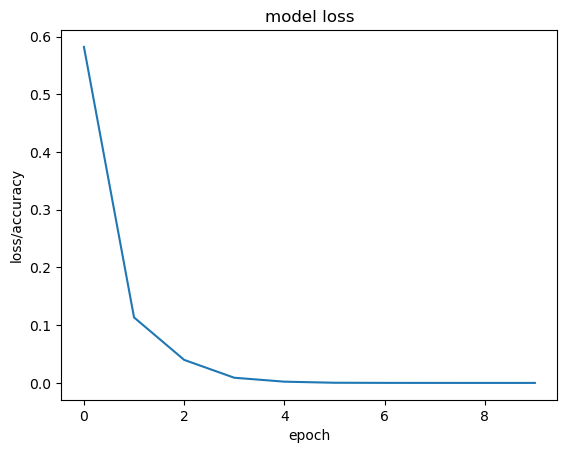

In [4]:
#Training Data Set
DirektoriDataSet="C:\\Temp\\dataimage"
#   Data Set disimpan dalam direktori yang sama dengan nama kelas    

#b. Label Data Set 
LabelKelas=("TAtas",
            "TSamping","TTurun","TBungkuk")

#c. Inisialisasi parameter Training
JumlahEpoh = 10;

#d. training
ModelCNN,history = TrainingCNN(JumlahEpoh,DirektoriDataSet,LabelKelas )
ModelCNN.summary()

#c. Menampilkan Grafik Loss dan accuracy
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.show()





In [5]:
LabelKelas=['TAtas','TSamping',"TTurun","TBungkuk"]

PredictPose(0,LabelKelas)

In [2]:
LabelKelas=("TAtas",
            "TSamping","TTurun","TBungkuk")
DirKlasifikasi="TAtas"
Res = TesPosePrediction(DirektoriDataSet,DirKlasifikasi,LabelKelas)
print(Res[0])
print(Res[1])

NameError: name 'DirektoriDataSet' is not defined

2022-10-20-135917022309.jpg
2022-10-20-135917278160.jpg
2022-10-20-135917487970.jpg
2022-10-20-135917756588.jpg
2022-10-20-135918010808.jpg
2022-10-20-135918222602.jpg
2022-10-20-135918492233.jpg
2022-10-20-135918778212.jpg
2022-10-20-135920059239.jpg
2022-10-20-135920311085.jpg
2022-10-20-135920586027.jpg
2022-10-20-135920840949.jpg
2022-10-20-135921118659.jpg
2022-10-20-135921373011.jpg
2022-10-20-135921582100.jpg
2022-10-20-135921784114.jpg
2022-10-20-135922042840.jpg
2022-10-20-135922311087.jpg
2022-10-20-135922581011.jpg
2022-10-20-135924210927.jpg
2022-10-20-135924443846.jpg
2022-10-20-135924651081.jpg
2022-10-20-135924919724.jpg
2022-10-20-135925200802.jpg
2022-10-20-135925466672.jpg
2022-10-20-135925784664.jpg
2022-10-20-135926073343.jpg
2022-10-20-135926312055.jpg
2022-10-20-135926515941.jpg
2022-10-20-135926793207.jpg
2022-10-20-135926994473.jpg
2022-10-20-135927215342.jpg
2022-10-20-135927453316.jpg
2022-10-20-135927720036.jpg
2022-10-20-135927922112.jpg
2022-10-20-135929403

2022-10-20-143235128049.jpg
2022-10-20-143235383630.jpg
2022-10-20-143235590754.jpg
2022-10-20-143235798374.jpg
2022-10-20-143236052930.jpg
2022-10-20-143236262315.jpg
2022-10-20-143236519133.jpg
2022-10-20-143236728006.jpg
2022-10-20-143236932648.jpg
2022-10-20-143237192244.jpg
2022-10-20-143237398964.jpg
2022-10-20-143237648829.jpg
2022-10-20-143237856704.jpg
2022-10-20-143238066290.jpg
2022-10-20-143238326524.jpg
2022-10-20-143238528331.jpg
2022-10-20-143238808418.jpg
2022-10-20-143239057178.jpg
2022-10-20-143239263841.jpg
2022-10-20-143239522003.jpg
2022-10-20-143239729843.jpg
2022-10-20-143239938855.jpg
2022-10-20-143240192955.jpg
2022-10-20-143240408870.jpg
2022-10-20-143240664945.jpg
2022-10-20-143240870266.jpg
2022-10-20-143241081919.jpg
2022-10-20-143241334917.jpg
2022-10-20-143241539921.jpg
2022-10-20-143241801967.jpg
2022-10-20-143242008907.jpg
2022-10-20-143242217876.jpg
2022-10-20-143242470943.jpg
2022-10-20-143242674338.jpg
2022-10-20-143242949448.jpg
2022-10-20-143243208

2022-10-22-124031563689.jpg
2022-10-22-124031815695.jpg
2022-10-22-124032079759.jpg
2022-10-22-124032288518.jpg
2022-10-22-124032547622.jpg
2022-10-22-124032754845.jpg
2022-10-22-124033028465.jpg
2022-10-22-124033278975.jpg
2022-10-22-124033496108.jpg
2022-10-22-124033763673.jpg
2022-10-22-124034029826.jpg
2022-10-22-124034285437.jpg
2022-10-22-124034572476.jpg
2022-10-22-124034826514.jpg
2022-10-22-124035035719.jpg
2022-10-22-124035285480.jpg
2022-10-22-124035487456.jpg
2022-10-22-124035695426.jpg
2022-10-22-124035960295.jpg
2022-10-22-124036227331.jpg
2022-10-22-124036440450.jpg
2022-10-22-124036690058.jpg
2022-10-22-124036894435.jpg
2022-10-22-124037174707.jpg
2022-10-22-124037433568.jpg
2022-10-22-124037699365.jpg
2022-10-22-124037979993.jpg
2022-10-22-124038231310.jpg
2022-10-22-124038437088.jpg
2022-10-22-124038702386.jpg
2022-10-22-124038968732.jpg
2022-10-22-124039178016.jpg
2022-10-22-124039444610.jpg
2022-10-22-124039695533.jpg
2022-10-22-124039920665.jpg
2022-10-22-124040121

2022-10-26-145902880524.jpg
2022-10-26-145903086891.jpg
2022-10-26-145903315212.jpg
2022-10-26-145903546892.jpg
2022-10-26-145903760647.jpg
2022-10-26-145903966780.jpg
2022-10-26-145904214118.jpg
2022-10-26-145904446496.jpg
2022-10-26-145904669054.jpg
2022-10-26-145904897362.jpg
2022-10-26-145905141201.jpg
2022-10-26-145905344238.jpg
2022-10-26-145905569147.jpg
2022-10-26-145905784542.jpg
2022-10-26-145906025912.jpg
2022-10-26-145906275371.jpg
2022-10-26-145906512925.jpg
2022-10-26-145906755582.jpg
2022-10-26-145906987610.jpg
2022-10-26-145907203341.jpg
2022-10-26-145907441182.jpg
2022-10-26-145907647238.jpg
2022-10-26-145907866461.jpg
2022-10-26-145908127837.jpg
2022-10-26-145908330502.jpg
2022-10-26-145908539914.jpg
2022-10-26-145908768019.jpg
2022-10-26-145909017467.jpg
2022-10-26-145909265579.jpg
2022-10-26-145909509999.jpg
2022-10-26-145909759202.jpg
2022-10-26-145910022126.jpg
2022-10-26-145910252334.jpg
2022-10-26-145910465398.jpg
2022-10-26-145910686599.jpg
2022-10-26-145910909

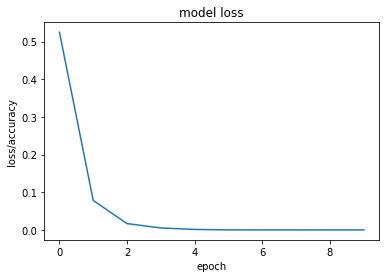

In [4]:
#Training Data Set
DirektoriDataSet="C:\\Temp\\dataimage"
#   Data Set disimpan dalam direktori yang sama dengan nama kelas    

#b. Label Data Set 
LabelKelas=("TAtas",
            "TSamping",
           "TTurun","TBungkuk","TA","TS")

#c. Inisialisasi parameter Training
JumlahEpoh = 10;

#d. training
ModelCNN,history = TrainingCNN(JumlahEpoh,DirektoriDataSet,LabelKelas )
ModelCNN.summary()

#c. Menampilkan Grafik Loss dan accuracy
plt.plot(history.history['loss'])

plt.title('model loss')
plt.ylabel('loss/accuracy')
plt.xlabel('epoch')
plt.show()




In [2]:
LabelKelas=['TAtas','TSamping','TTurun','TBungkuk','TA','TS']

PredictPose(0,LabelKelas)